In [1]:
import sys,os

data_path = os.getcwd()

try:
    import localgraphclustering as lgc
except:
    # when the package is not installed, import the local version instead. 
    # the notebook must be placed in the original "notebooks/" folder
    sys.path.append("../")
    import localgraphclustering as lgc
    
# seed the pseudorandom number generator
from random import seed
from random import random
# seed random number generator
seed(1)

# seed the pseudorandom number generator
from numpy.random import seed as seed_np
from numpy.random import rand as rand_np
# seed random number generator
seed_np(1)

In [2]:
import time
import numpy as np

import matplotlib.pyplot as plt

# Import the graph_tool module for visualization.
from graph_tool.all import * 

import statistics as stat_

# Load graph

In [3]:
# Read graph. This also supports gml format.
#g = lgc.GraphLocal(os.path.join(data_path,'datasets/JohnsHopkins.graphml'),'graphml')
g = lgc.GraphLocal(os.path.join(data_path,'datasets/Colgate88_reduced.graphml'),'graphml')
# To get a quick look at the list of methods and attributes for the graph object 'g' you can type 'g.' + tab
# and scroll up or down.

vol_G = g.vol_G

/usr/local/lib/python3.7/site-packages/localgraphclustering/GraphLocal.py:217: UserWarning:

Loading a graphml is not efficient, we suggest using an edgelist format for this API.



## Load graph using GraphTool. We do this to handle some meta-data which LocalGraphClustering is not handling yet.

In [4]:
g_gtool = load_graph('datasets/Colgate88_reduced.graphml')
remove_self_loops(g_gtool)

n = g_gtool.num_vertices()

## Load coordinates for graph layout

In [5]:
# Load pre-computed coordinates for nodes.
g_v_prop = g_gtool.vertex_properties
xx = g_v_prop.x
yy = g_v_prop.y

pos = g_gtool.new_vertex_property("vector<double>")
for i in range(n):
    pos[i] = [xx[i],yy[i]]

## Load and filter ground truth clusters. This part takes a while to run. The results are saved in results/

In [6]:
g_v_prop = g_gtool.vertex_properties
#feature_list = [g_v_prop.secondMajor,g_v_prop.highSchool,g_v_prop.gender,g_v_prop.dorm,g_v_prop.majorIndex,g_v_prop.year]
feature_list = [g_v_prop.dorm,g_v_prop.majorIndex,g_v_prop.year]

number_feature = 0

ref_nodes = []
info_ref_nodes = []

for kk in feature_list:
    
    feature = kk

    for ff in list(set(feature.a)):
        
        if ff == 0:
            continue

        feature_array = np.zeros(n)
        feature_ff_nodes = []
        for i in range(n):
            feature_array[i] = feature[i]
            if feature_array[i] == ff:
                feature_ff_nodes.append(i)

        g_ff = g_gtool.copy()

        del_list_ff = list(set(range(n)) - set(feature_ff_nodes))

        for v in reversed(sorted(del_list_ff)):
            g_ff.remove_vertex(v)   

        n_ff = g_ff.num_vertices() 

        comp_ff,hist_ff=label_components(g_ff)

        feature_ff_nodes_largest_component = []
        for i in range(n_ff):
            if comp_ff[i] == 0:
                feature_ff_nodes_largest_component.append(feature_ff_nodes[i])    

        vol_ff = sum(g.d[feature_ff_nodes_largest_component])
        
        if vol_ff < 100:
            continue
            
        #temp = np.zeros(n)
        #temp[feature_ff_nodes_largest_component] = 1
        
        #cut_ff = vol_ff - (g.adjacency_matrix.dot(temp).transpose()).dot(temp)
        #cond_ff = cut_ff/min(vol_ff,vol_G - vol_ff)
        cond_ff = g.compute_conductance(feature_ff_nodes_largest_component,cpp=True)
        
        if cond_ff > 0.47:
            continue
            
        print("Reached")
        eig_ff, lambda_ff = lgc.fiedler_local(g, feature_ff_nodes_largest_component)
        lambda_ff = np.real(lambda_ff)
        gap_ff = lambda_ff/cond_ff
        
        print("Number of feature", number_feature, "Feature value ", ff, " gap ",gap_ff, " volume: ", vol_ff, " size:", len(feature_ff_nodes_largest_component), "conductance: ", cond_ff)
        
        if gap_ff >= 0.5 and vol_ff >= 100:
            ref_nodes.append(feature_ff_nodes_largest_component)
            info_ref_nodes.append([number_feature,ff])
            np.save('results/ref_nodes_Colgate88', ref_nodes) 
            np.save('results/info_ref_nodes_Colgate88', info_ref_nodes) 
        
    number_feature += 1

Reached
Number of feature 2 Feature value  2007  gap  [0.90496458]  volume:  68381.0  size: 588 conductance:  0.41600737046840497
Reached
Number of feature 2 Feature value  2008  gap  [0.89580114]  volume:  62429.0  size: 640 conductance:  0.29311698089029137
Reached
Number of feature 2 Feature value  2009  gap  [0.87791738]  volume:  35369.0  size: 638 conductance:  0.11973762334247505


## If you have generated the ground truth datasets once, you can avoid rerunning the above code and simple run the code below.

In [7]:
ref_nodes = np.load('results/ref_nodes_Colgate88.npy') 
info_ref_nodes = np.load('results/info_ref_nodes_Colgate88.npy') 

## Visualize the ground truth clusters

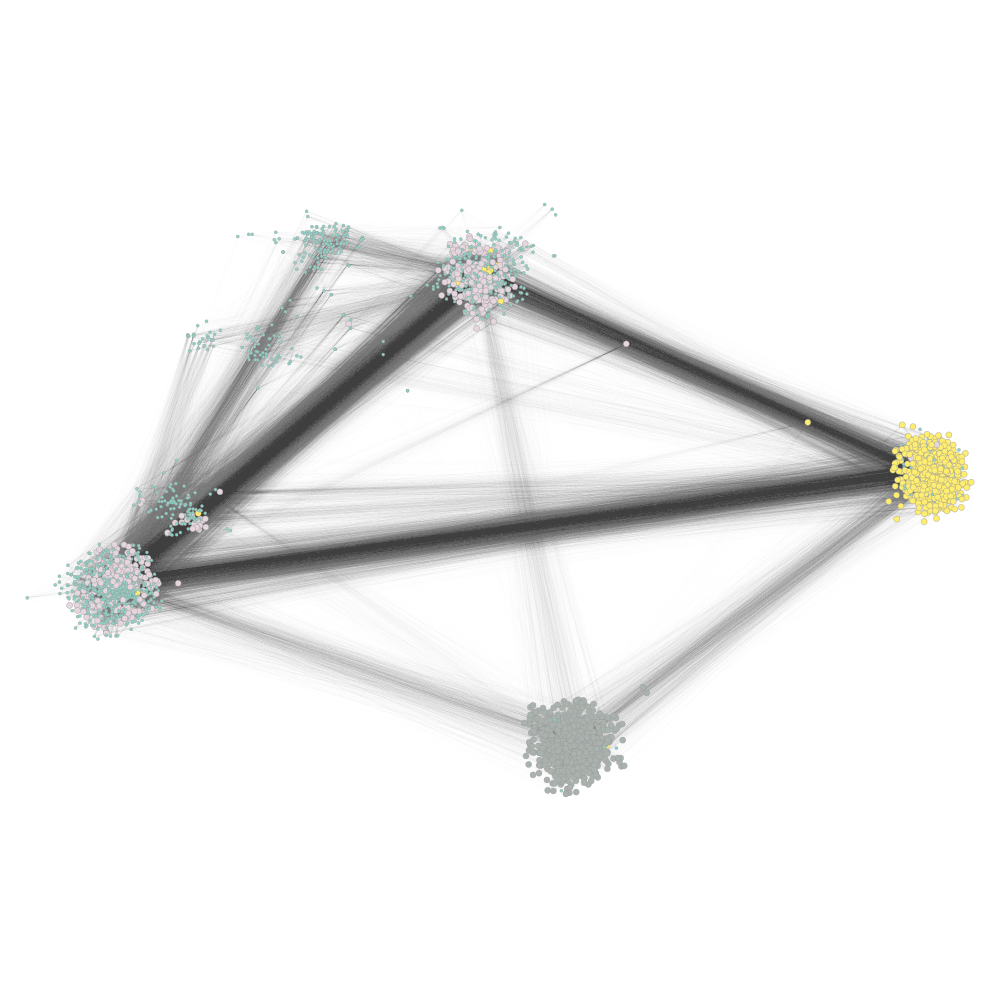

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x13ffc7208, at 0x13ffc0710>

In [8]:
temp = np.zeros(n)
temp = temp + 3

temp2 = np.zeros(n, dtype=int)

counter = 0

for i in ref_nodes:
        
    temp[i] = 6
    
    for j in i:
        temp2[j] = int(info_ref_nodes[counter,1])
    counter += 1

node_size = g_gtool.new_vertex_property("double",temp)

node_colours = g_gtool.new_vertex_property("int",temp2)

c_map = plt.get_cmap('Dark2')

graph_draw(g_gtool, pos, output_size=(1000, 1000),
            vertex_size=node_size, 
            vertex_fill_color=node_colours,
            edge_pen_width=0.1,
            edge_color = [0.0, 0, 0, 0.05]
            )

## Results by spectral algorithm: https://dl.acm.org/citation.cfm?id=1170528 

In [9]:
nodes = {}
external_best_cond_acl = {}
external_best_pre_cond_acl = {}
gap_best_cond_acl = {}
gap_best_pre_acl = {}
vol_best_cond_acl = {}
vol_best_pre_acl = {}
size_clust_best_cond_acl = {}
size_clust_best_pre_acl = {}
f1score_best_cond_acl = {}
f1score_best_pre_acl = {}
true_positives_best_cond_acl = {}
true_positives_best_pre_acl = {}
precision_best_cond_acl = {}
precision_best_pre_acl = {}
recall_best_cond_acl = {}
recall_best_pre_acl = {}
cuts_best_cond_acl = {}
cuts_best_pre_acl = {}
cuts_acl_ALL = {}

ct_outer = 0
for rr in ref_nodes:
    
    how_many = int(len(rr)/2)
    print(how_many)
    
    nodes[ct_outer] = np.random.choice(rr, how_many, replace=False)
    
    eigv, lambda_val = lgc.fiedler_local(g, rr)
    lambda_val = np.real(lambda_val)
    
    step = (2*lambda_val - lambda_val/2)/4
    
    a_list = np.arange(lambda_val/2,2*lambda_val,step)

    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        max_precision = -1
        min_conduct = 100
        
        ct_inner = 0
        for a in a_list:
            
            rho = 0.2/sum(g.d[rr])

            output_pr_clustering = lgc.spectral_clustering(g,ref_node,method="l1reg",alpha=a,rho=rho,epsilon=1.0e-2,iterations=1000)
            
            S_l1pr = output_pr_clustering[0]
            
            cuts_acl_ALL[ct_outer,node,ct_inner] = S_l1pr
            
            size_clust_acl_ = len(S_l1pr)
            
            cond_val_l1pr = output_pr_clustering[1]
            
            vol_ = sum(g.d[S_l1pr])
            true_positives_acl_ = set(rr).intersection(S_l1pr)
            if len(true_positives_acl_) == 0:
                true_positives_acl_ = set(ref_node)
                vol_ = g.d[ref_node][0,0]
            precision = sum(g.d[np.array(list(true_positives_acl_))])/vol_
            recall = sum(g.d[np.array(list(true_positives_acl_))])/sum(g.d[rr])
            f1_score_ = 2*(precision*recall)/(precision + recall)
            
            if f1_score_ >= max_precision:
            
                max_precision = f1_score_
            
                S_smqi, S_smqi_val = lgc.fiedler_local(g, S_l1pr)
                S_smqi_val = np.real(S_smqi_val)

                external_best_pre_cond_acl[ct_outer,node] = cond_val_l1pr
                gap_best_pre_acl[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_l1pr])))/cond_val_l1pr
                vol_best_pre_acl[ct_outer,node] = vol_

                size_clust_best_pre_acl[ct_outer,node] = size_clust_acl_
                true_positives_best_pre_acl[ct_outer,node] = true_positives_acl_
                precision_best_pre_acl[ct_outer,node] = precision
                recall_best_pre_acl[ct_outer,node] = recall
                f1score_best_pre_acl[ct_outer,node] = f1_score_
                
                cuts_best_pre_acl[ct_outer,node] = S_l1pr
                
            if cond_val_l1pr <= min_conduct:
            
                min_conduct = cond_val_l1pr
            
                S_smqi, S_smqi_val = lgc.fiedler_local(g, S_l1pr)
                S_smqi_val = np.real(S_smqi_val)

                external_best_cond_acl[ct_outer,node] = cond_val_l1pr
                gap_best_cond_acl[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_l1pr])))/cond_val_l1pr
                vol_best_cond_acl[ct_outer,node] = vol_

                size_clust_best_cond_acl[ct_outer,node] = size_clust_acl_
                true_positives_best_cond_acl[ct_outer,node] = true_positives_acl_
                precision_best_cond_acl[ct_outer,node] = precision
                recall_best_cond_acl[ct_outer,node] = recall
                f1score_best_cond_acl[ct_outer,node] = f1_score_
                
                cuts_best_cond_acl[ct_outer,node] = S_l1pr

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', external_best_cond_acl[ct_outer,node], 'f1score: ', f1score_best_pre_acl[ct_outer,node], 'precision: ', precision_best_pre_acl[ct_outer,node], 'recall: ', recall_best_pre_acl[ct_outer,node])
        ct += 1
    ct_outer += 1
    
    np.save('results/size_clust_best_cond_acl_Colgate88', size_clust_best_cond_acl) 
    np.save('results/external_best_cond_acl_Colgate88', external_best_cond_acl)
    np.save('results/vol_best_cond_acl_Colgate88', vol_best_cond_acl) 
    np.save('results/gap_best_cond_acl_Colgate88', gap_best_cond_acl) 
    np.save('results/cuts_best_cond_acl_Colgate88', cuts_best_cond_acl) 
    np.save('results/true_positives_best_cond_acl_Colgate88', true_positives_best_cond_acl)
    np.save('results/f1score_best_cond_acl_Colgate88', f1score_best_cond_acl) 
    np.save('results/precision_best_cond_acl_Colgate88', precision_best_cond_acl) 
    np.save('results/recall_best_cond_acl_Colgate88', recall_best_cond_acl) 

    np.save('results/size_clust_best_pre_acl_Colgate88', size_clust_best_pre_acl) 
    np.save('results/external_best_pre_cond_acl_Colgate88', external_best_pre_cond_acl)
    np.save('results/vol_best_pre_acl_Colgate88', vol_best_pre_acl) 
    np.save('results/gap_best_pre_acl_Colgate88', gap_best_pre_acl) 
    np.save('results/cuts_best_pre_acl_Colgate88', cuts_best_pre_acl) 
    np.save('results/true_positives_best_pre_acl_Colgate88', true_positives_best_pre_acl)
    np.save('results/f1score_best_pre_acl_Colgate88', f1score_best_pre_acl) 
    np.save('results/precision_best_pre_acl_Colgate88', precision_best_pre_acl) 
    np.save('results/recall_best_pre_acl_Colgate88', recall_best_pre_acl) 

    np.save('results/cuts_acl_ALL_Colgate88', cuts_acl_ALL) 
    
    np.save('results/nodes_Colgate88', nodes)

294
outer: 0 number of node:  3061  completed:  0.0  degree:  69.0
conductance:  0.38182193639742756 f1score:  0.5054304324518823 precision:  0.5076110684996165 recall:  0.5032684517629166
outer: 0 number of node:  364  completed:  0.003401360544217687  degree:  76.0
conductance:  0.4932163857954732 f1score:  0.3627023974377819 precision:  0.3850399132748596 recall:  0.3428145245024203
outer: 0 number of node:  2987  completed:  0.006802721088435374  degree:  92.0
conductance:  0.4766145606277636 f1score:  0.4937824732861269 precision:  0.5097465279940213 recall:  0.47878796741785
outer: 0 number of node:  1164  completed:  0.01020408163265306  degree:  83.0
conductance:  0.6367288616455093 f1score:  0.5276592097368646 precision:  0.637432955745615 recall:  0.4501396586771179
outer: 0 number of node:  2468  completed:  0.013605442176870748  degree:  97.0
conductance:  0.44898047534525304 f1score:  0.5697932857827686 precision:  0.5660273893530744 recall:  0.5736096284055513
outer: 0 nu

outer: 0 number of node:  3180  completed:  0.13945578231292516  degree:  51.0
conductance:  0.49320565859402843 f1score:  0.5663557026783027 precision:  0.583213250902555 recall:  0.5504452991328
outer: 0 number of node:  2670  completed:  0.14285714285714285  degree:  76.0
conductance:  0.46995030889067957 f1score:  0.8093693581036193 precision:  0.8692418748321247 recall:  0.7572132609935508
outer: 0 number of node:  2249  completed:  0.14625850340136054  degree:  398.0
conductance:  0.5456106214947922 f1score:  0.440029795266024 precision:  0.43526095913929264 recall:  0.44490428627835216
outer: 0 number of node:  1330  completed:  0.14965986394557823  degree:  68.0
conductance:  0.5537956279292532 f1score:  0.5797245413621565 precision:  0.6289042454927988 recall:  0.5376785949313406
outer: 0 number of node:  3203  completed:  0.15306122448979592  degree:  51.0
conductance:  0.6750294732052369 f1score:  0.1308147005911077 precision:  0.157914331216778 recall:  0.11165382196809055


outer: 0 number of node:  2415  completed:  0.2891156462585034  degree:  111.0
conductance:  0.46388548827573217 f1score:  0.6296377607025246 precision:  0.6526979941614088 recall:  0.6081513870812068
outer: 0 number of node:  1974  completed:  0.2925170068027211  degree:  106.0
conductance:  0.5131065875125336 f1score:  0.7103008871139835 precision:  0.7416721045343859 recall:  0.681475848554423
outer: 0 number of node:  2035  completed:  0.29591836734693877  degree:  6.0
conductance:  0.5833881394267015 f1score:  0.42292804577653337 precision:  0.44341605043229976 recall:  0.404249718489054
outer: 0 number of node:  2618  completed:  0.29931972789115646  degree:  125.0
conductance:  0.5082148234900452 f1score:  0.5134411748640276 precision:  0.5504266354358374 recall:  0.4811131747122739
outer: 0 number of node:  1214  completed:  0.30272108843537415  degree:  117.0
conductance:  0.6100417067693295 f1score:  0.42943519403313235 precision:  0.5091233557908245 recall:  0.37131659379067

outer: 0 number of node:  1988  completed:  0.43537414965986393  degree:  158.0
conductance:  0.47300630714465075 f1score:  0.5087373789332903 precision:  0.5112922999660271 recall:  0.5062078647577544
outer: 0 number of node:  2830  completed:  0.4387755102040816  degree:  141.0
conductance:  0.4761400128452152 f1score:  0.5419673812384721 precision:  0.5685131663455363 recall:  0.51779002939413
outer: 0 number of node:  1221  completed:  0.4421768707482993  degree:  58.0
conductance:  0.6010205488898083 f1score:  0.46371124069341474 precision:  0.5051717004551096 recall:  0.42854009154589723
outer: 0 number of node:  1210  completed:  0.445578231292517  degree:  18.0
conductance:  0.5283776301218162 f1score:  0.6804104650087824 precision:  0.6622369878183831 recall:  0.6996095406618797
outer: 0 number of node:  479  completed:  0.4489795918367347  degree:  131.0
conductance:  0.47893587265670423 f1score:  0.5748674443266172 precision:  0.5962852967519917 recall:  0.5549348503239204
o

outer: 0 number of node:  346  completed:  0.5850340136054422  degree:  181.0
conductance:  0.4961744388332461 f1score:  0.46281781985766685 precision:  0.49867414326008747 recall:  0.43177198344569395
outer: 0 number of node:  2051  completed:  0.5884353741496599  degree:  81.0
conductance:  0.6129668116469907 f1score:  0.22617205833782397 precision:  0.27876930987937354 recall:  0.19027215162106434
outer: 0 number of node:  2840  completed:  0.5918367346938775  degree:  169.0
conductance:  0.412175033617212 f1score:  0.5470584447640102 precision:  0.5355221873599283 recall:  0.5591026747195859
outer: 0 number of node:  156  completed:  0.5952380952380952  degree:  133.0
conductance:  0.3452405734349196 f1score:  0.4831598285364361 precision:  0.4708355884924435 recall:  0.49614659042716547
outer: 0 number of node:  911  completed:  0.5986394557823129  degree:  83.0
conductance:  0.4305051035206696 f1score:  0.3071131252574903 precision:  0.29858703609066173 recall:  0.316140448370161

outer: 0 number of node:  1623  completed:  0.7346938775510204  degree:  167.0
conductance:  0.4336188912068889 f1score:  0.5329930571899271 precision:  0.5361238107920162 recall:  0.5298986560594318
outer: 0 number of node:  1333  completed:  0.7380952380952381  degree:  136.0
conductance:  0.5072633427339966 f1score:  0.6014588008977236 precision:  0.6654782809202008 recall:  0.5486758017577982
outer: 0 number of node:  3124  completed:  0.7414965986394558  degree:  86.0
conductance:  0.42950849132896035 f1score:  0.5382560763567756 precision:  0.5447329799023573 recall:  0.5319313844488966
outer: 0 number of node:  3355  completed:  0.7448979591836735  degree:  33.0
conductance:  0.5015054088811559 f1score:  0.14631607126922277 precision:  0.1488463575156971 recall:  0.14387037334932218
outer: 0 number of node:  2852  completed:  0.7482993197278912  degree:  124.0
conductance:  0.5937817443041649 f1score:  0.5339206049761556 precision:  0.5980989696705848 recall:  0.4821807227153741

outer: 0 number of node:  3092  completed:  0.8741496598639455  degree:  160.0
conductance:  0.447397057200082 f1score:  0.5184460125957964 precision:  0.5387720985979908 recall:  0.49959784150568143
outer: 0 number of node:  1528  completed:  0.8775510204081632  degree:  97.0
conductance:  0.4881467437979032 f1score:  0.6122649776315587 precision:  0.6453421483317939 recall:  0.5824132434448166
outer: 0 number of node:  362  completed:  0.8809523809523809  degree:  68.0
conductance:  0.5320202775700158 f1score:  0.6547383815910257 precision:  0.6994431978725173 recall:  0.6154048639241895
outer: 0 number of node:  1658  completed:  0.8843537414965986  degree:  89.0
conductance:  0.5171964475534068 f1score:  0.6905853662386451 precision:  0.7501114425813531 recall:  0.6398122285430163
outer: 0 number of node:  1662  completed:  0.8877551020408163  degree:  368.0
conductance:  0.6137343276243546 f1score:  0.2601471451976877 precision:  0.27585020077030237 recall:  0.24613562246822948
ou

outer: 1 number of node:  246  completed:  0.015625  degree:  110.0
conductance:  0.3647048400909547 f1score:  0.8268295493834275 precision:  0.7944954670289106 recall:  0.8619071264956991
outer: 1 number of node:  1979  completed:  0.01875  degree:  41.0
conductance:  0.3819048656236009 f1score:  0.752312676638864 precision:  0.6603138877796735 recall:  0.8740969741626488
outer: 1 number of node:  68  completed:  0.021875  degree:  129.0
conductance:  0.2573789587042043 f1score:  0.1664789616527888 precision:  0.19646164237313984 recall:  0.1444360793861827
outer: 1 number of node:  3444  completed:  0.025  degree:  80.0
conductance:  0.42478169841188784 f1score:  0.6868948075106031 precision:  0.6171679517949241 recall:  0.7743836998830672
outer: 1 number of node:  2517  completed:  0.028125  degree:  47.0
conductance:  0.36937823150469656 f1score:  0.7556589019672401 precision:  0.6607924759174174 recall:  0.882330327251758
outer: 1 number of node:  3156  completed:  0.03125  degree

outer: 1 number of node:  705  completed:  0.153125  degree:  204.0
conductance:  0.28144484117884716 f1score:  0.5695863904941239 precision:  0.47893121935772703 recall:  0.702574124205097
outer: 1 number of node:  1468  completed:  0.15625  degree:  66.0
conductance:  0.3837906319283963 f1score:  0.6666756954413717 precision:  0.5774514059145777 recall:  0.7885117493472585
outer: 1 number of node:  3441  completed:  0.159375  degree:  92.0
conductance:  0.31590826696605034 f1score:  0.827468263732104 precision:  0.7157959980820733 recall:  0.9804257636675263
outer: 1 number of node:  387  completed:  0.1625  degree:  97.0
conductance:  0.41503071622135296 f1score:  0.6117570251837035 precision:  0.5400291834757764 recall:  0.7054573996059523
outer: 1 number of node:  3392  completed:  0.165625  degree:  1.0
conductance:  0.3686569553385625 f1score:  0.8031289281739645 precision:  0.8028653753801824 recall:  0.8033926540550065
outer: 1 number of node:  1144  completed:  0.16875  degre

outer: 1 number of node:  3320  completed:  0.29375  degree:  171.0
conductance:  0.3270655405086585 f1score:  0.7794104659615085 precision:  0.6766974944557165 recall:  0.9188838520559356
outer: 1 number of node:  2141  completed:  0.296875  degree:  109.0
conductance:  0.30389219302868326 f1score:  0.8954239235043928 precision:  0.8685537905593615 recall:  0.9240096749907896
outer: 1 number of node:  144  completed:  0.3  degree:  58.0
conductance:  0.3473808440800069 f1score:  0.7958155969173414 precision:  0.7032934610230751 recall:  0.9163689951785228
outer: 1 number of node:  500  completed:  0.303125  degree:  16.0
conductance:  0.4363490986625315 f1score:  0.7290874852558753 precision:  0.6402524714091878 recall:  0.8465456758878086
outer: 1 number of node:  955  completed:  0.30625  degree:  84.0
conductance:  0.3406798262098411 f1score:  0.857630325872846 precision:  0.8312762151029061 recall:  0.8857101667494274
outer: 1 number of node:  1669  completed:  0.309375  degree:  

outer: 1 number of node:  2930  completed:  0.434375  degree:  186.0
conductance:  0.38829766896498985 f1score:  0.7266558782613634 precision:  0.6524094159030371 recall:  0.8199714876099249
outer: 1 number of node:  1222  completed:  0.4375  degree:  96.0
conductance:  0.3387993828267968 f1score:  0.8422486819501215 precision:  0.8928020381068571 recall:  0.7971135209598104
outer: 1 number of node:  758  completed:  0.440625  degree:  71.0
conductance:  0.4793696559952277 f1score:  0.20250117220577635 precision:  0.17980711871147345 recall:  0.2317512694420862
outer: 1 number of node:  2656  completed:  0.44375  degree:  85.0
conductance:  0.3431935207037117 f1score:  0.8462172913397321 precision:  0.7773010083673032 recall:  0.928542824648801
outer: 1 number of node:  1012  completed:  0.446875  degree:  106.0
conductance:  0.4051704473450767 f1score:  0.7405316296280574 precision:  0.6631985806615132 recall:  0.8382802864053565
outer: 1 number of node:  1378  completed:  0.45  degre

outer: 1 number of node:  632  completed:  0.575  degree:  122.0
conductance:  0.47734317759116274 f1score:  0.35875293288656007 precision:  0.33716113396832553 recall:  0.3832994281503788
outer: 1 number of node:  1726  completed:  0.578125  degree:  63.0
conductance:  0.42373847328766345 f1score:  0.5563798614810868 precision:  0.47614868176585246 recall:  0.6691281295551746
outer: 1 number of node:  905  completed:  0.58125  degree:  112.0
conductance:  0.3563380119252194 f1score:  0.7530576118442227 precision:  0.6476293724843438 recall:  0.8994858158868475
outer: 1 number of node:  1609  completed:  0.584375  degree:  113.0
conductance:  0.4048774627582893 f1score:  0.5735194173091049 precision:  0.501826045170591 recall:  0.6691121113585032
outer: 1 number of node:  2657  completed:  0.5875  degree:  121.0
conductance:  0.34690328558192574 f1score:  0.8397695046159417 precision:  0.7935286152091797 recall:  0.8917330086978807
outer: 1 number of node:  1194  completed:  0.590625  

outer: 1 number of node:  423  completed:  0.715625  degree:  211.0
conductance:  0.35302461048733746 f1score:  0.7272010750187353 precision:  0.6093721239944131 recall:  0.9015201268641176
outer: 1 number of node:  3035  completed:  0.71875  degree:  175.0
conductance:  0.33638992922736544 f1score:  0.8695310567591555 precision:  0.7965186794439484 recall:  0.9572794694773262
outer: 1 number of node:  2586  completed:  0.721875  degree:  179.0
conductance:  0.40182758664514573 f1score:  0.7468110437099609 precision:  0.6696745167316955 recall:  0.8440308190103958
outer: 1 number of node:  1470  completed:  0.725  degree:  70.0
conductance:  0.34175364734087654 f1score:  0.8553063018305498 precision:  0.8179399467882934 recall:  0.8962501401592209
outer: 1 number of node:  1228  completed:  0.728125  degree:  108.0
conductance:  0.3211497613858928 f1score:  0.8769815683571603 precision:  0.8160602466138865 recall:  0.9477326242611607
outer: 1 number of node:  2679  completed:  0.73125 

outer: 1 number of node:  1344  completed:  0.85625  degree:  104.0
conductance:  0.41181271529219726 f1score:  0.7117039232637603 precision:  0.6224900080415762 recall:  0.8307677521664611
outer: 1 number of node:  1919  completed:  0.859375  degree:  216.0
conductance:  0.37078238259355106 f1score:  0.7665633986746502 precision:  0.6767566506813192 recall:  0.8838520559355427
outer: 1 number of node:  2176  completed:  0.8625  degree:  132.0
conductance:  0.3765324950454452 f1score:  0.7946959304983997 precision:  0.7363903505774619 recall:  0.8630284002626984
outer: 1 number of node:  2117  completed:  0.865625  degree:  119.0
conductance:  0.35832536491515077 f1score:  0.7263686926221269 precision:  0.624393728182855 recall:  0.8681542231975524
outer: 1 number of node:  3437  completed:  0.86875  degree:  108.0
conductance:  0.3179470996614837 f1score:  0.8779598168678345 precision:  0.8320758505938378 recall:  0.9291995707123292
outer: 1 number of node:  537  completed:  0.871875 

outer: 1 number of node:  180  completed:  0.996875  degree:  168.0
conductance:  0.3381997866247403 f1score:  0.8282497287996111 precision:  0.7770509293054074 recall:  0.8866712585497125
319
outer: 2 number of node:  1182  completed:  0.0  degree:  90.0
conductance:  0.13249940243805275 f1score:  0.9646955711977212 precision:  0.9354367513876717 recall:  0.9958438180327406
outer: 2 number of node:  1309  completed:  0.003134796238244514  degree:  71.0
conductance:  0.13160757015444854 f1score:  0.9720146926328921 precision:  0.9534207091581466 recall:  0.9913483559048885
outer: 2 number of node:  838  completed:  0.006269592476489028  degree:  6.0
conductance:  0.25061466116057574 f1score:  0.8701819782040331 precision:  0.8024252261714367 recall:  0.950436823206763
outer: 2 number of node:  3353  completed:  0.009404388714733543  degree:  72.0
conductance:  0.11607563048473273 f1score:  0.9788228053488502 precision:  0.9686072585333444 recall:  0.9892561282479007
outer: 2 number of 

outer: 2 number of node:  2596  completed:  0.13166144200626959  degree:  32.0
conductance:  0.12597225999456077 f1score:  0.9709588433440995 precision:  0.9524612455806364 recall:  0.9901891486895303
outer: 2 number of node:  3455  completed:  0.13479623824451412  degree:  167.0
conductance:  0.12643241188290882 f1score:  0.971424613892929 precision:  0.952207679356976 recall:  0.9914331759450367
outer: 2 number of node:  2585  completed:  0.13793103448275862  degree:  172.0
conductance:  0.30686914108092833 f1score:  0.5850709788645563 precision:  0.476385088311596 recall:  0.7580084254573214
outer: 2 number of node:  351  completed:  0.14106583072100312  degree:  68.0
conductance:  0.14197432209258964 f1score:  0.9580996008832686 precision:  0.9303713174577806 recall:  0.9875314540982216
outer: 2 number of node:  1543  completed:  0.14420062695924765  degree:  31.0
conductance:  0.12925207603387867 f1score:  0.9730507149240394 precision:  0.9612657599249593 recall:  0.98512821962735

outer: 2 number of node:  3220  completed:  0.26332288401253917  degree:  35.0
conductance:  0.11684805069568811 f1score:  0.978175932127707 precision:  0.9656977545116407 recall:  0.9909808023975798
outer: 2 number of node:  1789  completed:  0.2664576802507837  degree:  47.0
conductance:  0.12342731442980927 f1score:  0.9660270352118492 precision:  0.9413042895082758 recall:  0.9920834629195058
outer: 2 number of node:  2066  completed:  0.26959247648902823  degree:  77.0
conductance:  0.10936589426946025 f1score:  0.9817377177749146 precision:  0.9726654641320938 recall:  0.9909808023975798
outer: 2 number of node:  3147  completed:  0.2727272727272727  degree:  99.0
conductance:  0.14311321998154738 f1score:  0.9528265851795263 precision:  0.9206010280743376 recall:  0.9873900873646414
outer: 2 number of node:  3166  completed:  0.27586206896551724  degree:  13.0
conductance:  0.12629158702457133 f1score:  0.9685733475121733 precision:  0.9587800216072467 recall:  0.978568803189233

outer: 2 number of node:  1583  completed:  0.3949843260188088  degree:  87.0
conductance:  0.19230193200539164 f1score:  0.9278413384417548 precision:  0.8734960810743347 recall:  0.989397494981481
outer: 2 number of node:  798  completed:  0.3981191222570533  degree:  94.0
conductance:  0.1188746244195575 f1score:  0.976219199356601 precision:  0.9579024708827691 recall:  0.9952500777517035
outer: 2 number of node:  1935  completed:  0.4012539184952978  degree:  58.0
conductance:  0.12262219917578669 f1score:  0.9726982363560617 precision:  0.9558145247127535 recall:  0.9901891486895303
outer: 2 number of node:  393  completed:  0.4043887147335423  degree:  55.0
conductance:  0.11614636713664442 f1score:  0.9783405624737653 precision:  0.968421927370433 recall:  0.9884644745398513
outer: 2 number of node:  3107  completed:  0.40752351097178685  degree:  179.0
conductance:  0.1867611061923858 f1score:  0.9307180328313294 precision:  0.8939638560491641 recall:  0.9706239927620233
outer

outer: 2 number of node:  428  completed:  0.5266457680250783  degree:  23.0
conductance:  0.16995435909337048 f1score:  0.9344571813890763 precision:  0.8933498362600243 recall:  0.9795300969775792
outer: 2 number of node:  2932  completed:  0.5297805642633229  degree:  84.0
conductance:  0.11378788727659812 f1score:  0.9785219528544297 precision:  0.9667761251690168 recall:  0.990556702196839
outer: 2 number of node:  2588  completed:  0.5329153605015674  degree:  32.0
conductance:  0.12167427362796393 f1score:  0.9782190993113701 precision:  0.9705554937103418 recall:  0.9860046933755549
outer: 2 number of node:  2469  completed:  0.5360501567398119  degree:  106.0
conductance:  0.11154772117220577 f1score:  0.9840013425446816 precision:  0.9735451199601517 recall:  0.9946846108173825
outer: 2 number of node:  2520  completed:  0.5391849529780565  degree:  23.0
conductance:  0.11507947477539737 f1score:  0.9783909202728391 precision:  0.9674913614374568 recall:  0.9895388617150612
o

outer: 2 number of node:  3480  completed:  0.658307210031348  degree:  89.0
conductance:  0.12209988742758299 f1score:  0.9753168965036912 precision:  0.961231157848494 recall:  0.9898215951822217
outer: 2 number of node:  1319  completed:  0.6614420062695925  degree:  25.0
conductance:  0.11802093035998028 f1score:  0.973215900710996 precision:  0.9581118842803134 recall:  0.9888037547004439
outer: 2 number of node:  533  completed:  0.664576802507837  degree:  1.0
conductance:  0.141727199354318 f1score:  0.9619652876383739 precision:  0.9386602098466506 recall:  0.9864570669230117
outer: 2 number of node:  304  completed:  0.6677115987460815  degree:  72.0
conductance:  0.12490442381212452 f1score:  0.9729819833585686 precision:  0.9563626433642818 recall:  0.9901891486895303
outer: 2 number of node:  3164  completed:  0.670846394984326  degree:  110.0
conductance:  0.11934447650677846 f1score:  0.9714158911557078 precision:  0.9533674524963249 recall:  0.9901608753428144
outer: 2 

outer: 2 number of node:  950  completed:  0.7899686520376176  degree:  148.0
conductance:  0.12252028854824167 f1score:  0.969332599460886 precision:  0.9677073940486925 recall:  0.9709632729226159
outer: 2 number of node:  1548  completed:  0.7931034482758621  degree:  44.0
conductance:  0.10801160455255523 f1score:  0.9845682912787678 precision:  0.9779904039276948 recall:  0.9912352625180243
outer: 2 number of node:  719  completed:  0.7962382445141066  degree:  40.0
conductance:  0.11575057227171186 f1score:  0.9791539103812971 precision:  0.9641007371680689 recall:  0.9946846108173825
outer: 2 number of node:  3039  completed:  0.799373040752351  degree:  110.0
conductance:  0.11804688583714801 f1score:  0.9772593609096256 precision:  0.9680954362602303 recall:  0.9865984336565919
outer: 2 number of node:  1983  completed:  0.8025078369905956  degree:  93.0
conductance:  0.1299897091480258 f1score:  0.9690835531130474 precision:  0.9470743819496923 recall:  0.9921400096129379
out

outer: 2 number of node:  2151  completed:  0.9216300940438872  degree:  119.0
conductance:  0.11711513012792236 f1score:  0.9775128767046802 precision:  0.9653451698279665 recall:  0.989991235262518
outer: 2 number of node:  266  completed:  0.9247648902821317  degree:  4.0
conductance:  0.12171916917885886 f1score:  0.9758689148002125 precision:  0.9652349475896783 recall:  0.9867398003901722
outer: 2 number of node:  1925  completed:  0.9278996865203761  degree:  125.0
conductance:  0.12094607693798987 f1score:  0.9758520342492585 precision:  0.9658791924003656 recall:  0.9860329667222709
outer: 2 number of node:  3356  completed:  0.9310344827586207  degree:  91.0
conductance:  0.17720499395892067 f1score:  0.9330599091841218 precision:  0.881871727748691 recall:  0.990556702196839
outer: 2 number of node:  2605  completed:  0.9341692789968652  degree:  25.0
conductance:  0.1136871739670448 f1score:  0.979413407821229 precision:  0.967762413402887 recall:  0.9913483559048885
outer:

## Improve the results found by the spectral algorithm using MQI

In [10]:
nodes = np.load('results/nodes_Colgate88.npy')
nodes = nodes[()]

external_cond_acl_flow = {}
gap_acl_flow = {}
vol_acl_flow = {}
size_clust_acl_flow = {}
f1score_acl_flow = {}
true_positives_acl_flow = {}
precision_acl_flow = {}
recall_acl_flow = {}
cuts_acl_flow = {}

cuts_best_cond_acl = np.load('results/cuts_best_cond_acl_Colgate88.npy')
cuts_best_cond_acl = cuts_best_cond_acl[()]

ct_outer = 0
for rr in ref_nodes:
    
    how_many = int(len(rr)/2)
    print(how_many)

    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        ref_set = cuts_best_cond_acl[ct_outer,node]

        output_mqi = lgc.flow_clustering(g,ref_set,method="mqi")
        
        S_flowI = output_mqi[0]
        
        cuts_acl_flow[ct_outer,node] = S_flowI

        S_smqi, S_smqi_val = lgc.fiedler_local(g, S_flowI)
        S_smqi_val = np.real(S_smqi_val)

        cond_val_acl_flow = output_mqi[1]

        external_cond_acl_flow[ct_outer,node] = cond_val_acl_flow
        gap_acl_flow[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_flowI])))/cond_val_acl_flow
        vol_acl_flow[ct_outer,node] = sum(g.d[S_flowI])
        size_clust_acl_flow[ct_outer,node] = len(S_flowI)
            
        true_positives_acl_flow[ct_outer,node] = set(rr).intersection(S_flowI)
        if len(true_positives_acl_flow[ct_outer,node]) == 0:
            true_positives_acl_flow[ct_outer,node] = set(ref_node)
            vol_acl_flow[ct_outer,node] = g.d[ref_node][0]
        precision_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/vol_acl_flow[ct_outer,node]
        recall_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/sum(g.d[rr])
        f1score_acl_flow[ct_outer,node] = 2*(precision_acl_flow[ct_outer,node]*recall_acl_flow[ct_outer,node])/(precision_acl_flow[ct_outer,node] + recall_acl_flow[ct_outer,node])
            

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', cond_val_acl_flow, 'f1score: ', f1score_acl_flow[ct_outer,node], 'precision: ', precision_acl_flow[ct_outer,node], 'recall: ', recall_acl_flow[ct_outer,node])
        
        ct += 1
    ct_outer += 1

    np.save('results/size_clust_acl_flow_mqi_Colgate88', size_clust_acl_flow) 
    np.save('results/external_cond_acl_flow_mqi_Colgate88', external_cond_acl_flow)
    np.save('results/vol_acl_flow_mqi_Colgate88', vol_acl_flow) 
    np.save('results/gap_acl_flow_mqi_Colgate88', gap_acl_flow) 
    np.save('results/cuts_acl_flow_mqi_Colgate88', cuts_acl_flow) 
    np.save('results/true_positives_acl_flow_mqi_Colgate88', true_positives_acl_flow)
    np.save('results/recall_acl_flow_mqi_Colgate88', recall_acl_flow) 
    np.save('results/precision_acl_flow_mqi_Colgate88', precision_acl_flow) 
    np.save('results/f1score_acl_flow_mqi_Colgate88', f1score_acl_flow) 

294
outer: 0 number of node:  3061  completed:  0.0  degree:  69.0
conductance:  0.37012322828892896 f1score:  0.48394294243464075 precision:  0.5106099719123927 recall:  0.4599230780479958
outer: 0 number of node:  364  completed:  0.003401360544217687  degree:  76.0
conductance:  0.48486111938372345 f1score:  0.3088725704853976 precision:  0.3641074513074037 recall:  0.26818853190213654
outer: 0 number of node:  2987  completed:  0.006802721088435374  degree:  92.0
conductance:  0.4665435139573071 f1score:  0.49941266900547915 precision:  0.5417692939244664 recall:  0.4631988417835364
outer: 0 number of node:  1164  completed:  0.01020408163265306  degree:  83.0
conductance:  0.6223008849557522 f1score:  0.5646199886964821 precision:  0.770417193426043 recall:  0.4455916117050058
outer: 0 number of node:  2468  completed:  0.013605442176870748  degree:  97.0
conductance:  0.4430791585065386 f1score:  0.5829745552290485 precision:  0.6062922484048265 recall:  0.5613840101782659
outer:

outer: 0 number of node:  2249  completed:  0.14625850340136054  degree:  398.0
conductance:  0.5131942604020747 f1score:  0.14893347680232927 precision:  0.2672547609131867 recall:  0.10323042950527193
outer: 0 number of node:  1330  completed:  0.14965986394557823  degree:  68.0
conductance:  0.5364427641990505 f1score:  0.6278177331682429 precision:  0.7857174257077545 recall:  0.5227621707784326
outer: 0 number of node:  3203  completed:  0.15306122448979592  degree:  51.0
conductance:  0.6425636267232238 f1score:  0.08145540144281989 precision:  0.13301961823966066 recall:  0.05870051622526725
outer: 0 number of node:  2426  completed:  0.1564625850340136  degree:  114.0
conductance:  0.4441125549361694 f1score:  0.781448959005143 precision:  0.8990506268906604 recall:  0.6910545326918296
outer: 0 number of node:  635  completed:  0.1598639455782313  degree:  85.0
conductance:  0.4699383736660153 f1score:  0.7736688458533777 precision:  0.883830602735608 recall:  0.687925008408768

outer: 0 number of node:  3333  completed:  0.2857142857142857  degree:  111.0
conductance:  0.5176353338681057 f1score:  0.7095690284879475 precision:  0.944505214030482 recall:  0.568228016554306
outer: 0 number of node:  2415  completed:  0.2891156462585034  degree:  111.0
conductance:  0.45310547528115597 f1score:  0.644776357827476 precision:  0.7103785705485841 recall:  0.5902663020429652
outer: 0 number of node:  1974  completed:  0.2925170068027211  degree:  106.0
conductance:  0.49927431059506533 f1score:  0.7518805515744811 precision:  0.8423258345428156 recall:  0.6789751539170238
outer: 0 number of node:  2035  completed:  0.29591836734693877  degree:  6.0
conductance:  0.5148555994182422 f1score:  0.10137733502219484 precision:  0.23072927488053188 recall:  0.06495956479138942
outer: 0 number of node:  2618  completed:  0.29931972789115646  degree:  125.0
conductance:  0.4961493228119428 f1score:  0.5001692829833442 precision:  0.5744717174399636 recall:  0.442886181834135

outer: 0 number of node:  789  completed:  0.42517006802721086  degree:  213.0
conductance:  0.4604972064944317 f1score:  0.6623945316672006 precision:  0.7558026172709887 recall:  0.5895351047805677
outer: 0 number of node:  2418  completed:  0.42857142857142855  degree:  1.0
conductance:  0.5843035200657444 f1score:  0.32033611723113187 precision:  0.5352006574441858 recall:  0.22857226422544275
outer: 0 number of node:  2801  completed:  0.43197278911564624  degree:  74.0
conductance:  0.45906159661996887 f1score:  0.4066660197086925 precision:  0.5125194574160552 recall:  0.3370526900747284
outer: 0 number of node:  1988  completed:  0.43537414965986393  degree:  158.0
conductance:  0.4656311693397073 f1score:  0.5127706829539145 precision:  0.5424287415770668 recall:  0.48618768371331217
outer: 0 number of node:  2830  completed:  0.4387755102040816  degree:  141.0
conductance:  0.4666276043910593 f1score:  0.5516739446870451 precision:  0.6008926878866735 recall:  0.5099077229054

outer: 0 number of node:  1744  completed:  0.5714285714285714  degree:  131.0
conductance:  0.40848849063690507 f1score:  0.5003057316641457 precision:  0.5560980844556528 recall:  0.45468770564923006
outer: 0 number of node:  2471  completed:  0.5748299319727891  degree:  139.0
conductance:  0.46271075405992484 f1score:  0.37139895717122806 precision:  0.40461331586387617 recall:  0.34322399496936284
outer: 0 number of node:  2485  completed:  0.5782312925170068  degree:  29.0
conductance:  0.445231241943174 f1score:  0.8528277737780977 precision:  0.9413198184675696 recall:  0.7795440253871689
outer: 0 number of node:  2019  completed:  0.5816326530612245  degree:  122.0
conductance:  0.45466638661345654 f1score:  0.6325719248205365 precision:  0.6948470209339774 recall:  0.5805413784530791
outer: 0 number of node:  346  completed:  0.5850340136054422  degree:  181.0
conductance:  0.46800683485777467 f1score:  0.4472173780539424 precision:  0.5309880389988944 recall:  0.386276889779

outer: 0 number of node:  211  completed:  0.7108843537414966  degree:  47.0
conductance:  0.5195032485435497 f1score:  0.6924208843512698 precision:  0.9137877298554338 recall:  0.5573916731255758
outer: 0 number of node:  2050  completed:  0.7142857142857143  degree:  83.0
conductance:  0.49583701738874153 f1score:  0.427915773341268 precision:  0.4834585912172119 recall:  0.38382006697766924
outer: 0 number of node:  855  completed:  0.717687074829932  degree:  62.0
conductance:  0.49575376319928105 f1score:  0.7125457299519005 precision:  0.903617164682094 recall:  0.5881750778725084
outer: 0 number of node:  720  completed:  0.7210884353741497  degree:  122.0
conductance:  0.46710463495216087 f1score:  0.5898264095938515 precision:  0.6800412505013081 recall:  0.5207440663342157
outer: 0 number of node:  1157  completed:  0.7244897959183674  degree:  60.0
conductance:  0.6918092275790565 f1score:  0.061500453368726754 precision:  0.30326594090202175 recall:  0.03422003188020064
ou

outer: 0 number of node:  1975  completed:  0.8537414965986394  degree:  163.0
conductance:  0.44806732369128377 f1score:  0.7479695916262368 precision:  0.7831338794317164 recall:  0.7158274959418552
outer: 0 number of node:  2395  completed:  0.8571428571428571  degree:  232.0
conductance:  0.483111417479955 f1score:  0.40640611463317866 precision:  0.45526611762144903 recall:  0.36701715388777584
outer: 0 number of node:  1911  completed:  0.8605442176870748  degree:  282.0
conductance:  0.3602593673887446 f1score:  0.46825384650784646 precision:  0.4923625336709841 recall:  0.446395928693643
outer: 0 number of node:  580  completed:  0.8639455782312925  degree:  11.0
conductance:  0.5593937772155594 f1score:  0.7133932485751863 precision:  0.95005716787895 recall:  0.5711235577134
outer: 0 number of node:  3314  completed:  0.8673469387755102  degree:  65.0
conductance:  0.5334729477826617 f1score:  0.6312033907398465 precision:  0.8122569212712586 recall:  0.5161521475263596
outer

320
outer: 1 number of node:  1116  completed:  0.0  degree:  186.0
conductance:  0.28832809691023037 f1score:  0.9284941122445632 precision:  0.9511920563181505 recall:  0.9068541863557
outer: 1 number of node:  998  completed:  0.003125  degree:  189.0
conductance:  0.28273276262525715 f1score:  0.9351371174768753 precision:  0.9518382108965425 recall:  0.9190119976293069
outer: 1 number of node:  71  completed:  0.00625  degree:  125.0
conductance:  0.30184726053706745 f1score:  0.9073623885783982 precision:  0.9481963892865872 recall:  0.8699002066347371
outer: 1 number of node:  1183  completed:  0.009375  degree:  104.0
conductance:  0.2882538062430892 f1score:  0.9320375534179219 precision:  0.9609254061410224 recall:  0.9048358935751013
outer: 1 number of node:  372  completed:  0.0125  degree:  177.0
conductance:  0.2852453608247423 f1score:  0.9383360150828091 precision:  0.9522969072164948 recall:  0.9247785484310176
outer: 1 number of node:  246  completed:  0.015625  degre

outer: 1 number of node:  1646  completed:  0.1375  degree:  74.0
conductance:  0.31674474178314715 f1score:  0.8671367536211748 precision:  0.9469152426650482 recall:  0.7997565234105944
outer: 1 number of node:  3398  completed:  0.140625  degree:  48.0
conductance:  0.4147065400800992 f1score:  0.8477306527620992 precision:  0.9618207322775417 recall:  0.7578369027214916
outer: 1 number of node:  3000  completed:  0.14375  degree:  63.0
conductance:  0.28462818994662686 f1score:  0.9245057913138577 precision:  0.9575074224716401 recall:  0.8937032468884653
outer: 1 number of node:  2297  completed:  0.146875  degree:  120.0
conductance:  0.28077888389172434 f1score:  0.9325593615553877 precision:  0.9566088904610306 recall:  0.9096894071665412
outer: 1 number of node:  3337  completed:  0.15  degree:  52.0
conductance:  0.38908641636351154 f1score:  0.6635569288998625 precision:  0.6161164115587892 recall:  0.7189126848099441
outer: 1 number of node:  705  completed:  0.153125  degr

outer: 1 number of node:  947  completed:  0.275  degree:  133.0
conductance:  0.28626108302782666 f1score:  0.9539196448676295 precision:  0.9578481564624751 recall:  0.9500232263851736
outer: 1 number of node:  2044  completed:  0.278125  degree:  130.0
conductance:  0.3278891913412218 f1score:  0.8855641060876734 precision:  0.9546506675555062 recall:  0.8258021111983213
outer: 1 number of node:  1260  completed:  0.28125  degree:  91.0
conductance:  0.45506127343452957 f1score:  0.5312244383117628 precision:  0.5081015471907812 recall:  0.5565522433484439
outer: 1 number of node:  511  completed:  0.284375  degree:  48.0
conductance:  0.2999860617464632 f1score:  0.9124973920300439 precision:  0.9525054010732456 recall:  0.8757148120264621
outer: 1 number of node:  754  completed:  0.2875  degree:  83.0
conductance:  0.28291641765559633 f1score:  0.9262608063209745 precision:  0.9568172116451805 recall:  0.89759566867962
outer: 1 number of node:  2668  completed:  0.290625  degree:

outer: 1 number of node:  2822  completed:  0.415625  degree:  74.0
conductance:  0.2922636103151863 f1score:  0.9108594827226006 precision:  0.9521804458732266 recall:  0.8729757003956494
outer: 1 number of node:  3086  completed:  0.41875  degree:  77.0
conductance:  0.27113567539838823 f1score:  0.938189809539313 precision:  0.9536992603134153 recall:  0.9231767287638758
outer: 1 number of node:  2614  completed:  0.421875  degree:  55.0
conductance:  0.3156383500245115 f1score:  0.920021749132126 precision:  0.9628125218852861 recall:  0.8808726713546589
outer: 1 number of node:  359  completed:  0.425  degree:  203.0
conductance:  0.3638618658191543 f1score:  0.865887346423341 precision:  0.956726483469633 recall:  0.7908023514712713
outer: 1 number of node:  1341  completed:  0.428125  degree:  77.0
conductance:  0.2782491127260436 f1score:  0.9253365570440546 precision:  0.9508196721311475 recall:  0.9011837447340179
outer: 1 number of node:  3085  completed:  0.43125  degree:  

outer: 1 number of node:  2744  completed:  0.553125  degree:  166.0
conductance:  0.30339116031732194 f1score:  0.9192045682228009 precision:  0.9598640048818761 recall:  0.8818497813516154
outer: 1 number of node:  2361  completed:  0.55625  degree:  142.0
conductance:  0.299843235340743 f1score:  0.9045989161255683 precision:  0.9496591689711659 recall:  0.8636210735395409
outer: 1 number of node:  2447  completed:  0.559375  degree:  96.0
conductance:  0.3572379613876766 f1score:  0.8911720527016007 precision:  0.9600007396996819 recall:  0.8315526438033606
outer: 1 number of node:  778  completed:  0.5625  degree:  144.0
conductance:  0.2708746857218473 f1score:  0.9385848557594498 precision:  0.9539003572846367 recall:  0.9237533838440468
outer: 1 number of node:  2659  completed:  0.565625  degree:  91.0
conductance:  0.28392494843977933 f1score:  0.9338565389782744 precision:  0.955700129110146 recall:  0.9129891556808535
outer: 1 number of node:  2859  completed:  0.56875  deg

outer: 1 number of node:  2385  completed:  0.690625  degree:  88.0
conductance:  0.3273555784212847 f1score:  0.9030491301036344 precision:  0.9694620020579157 recall:  0.8451520927773951
outer: 1 number of node:  1030  completed:  0.69375  degree:  89.0
conductance:  0.3175210988550418 f1score:  0.8648277062304212 precision:  0.9466956240117353 recall:  0.795992247192811
outer: 1 number of node:  1620  completed:  0.696875  degree:  44.0
conductance:  0.29137211197791046 f1score:  0.9416065541665306 precision:  0.9596966017398826 recall:  0.9241858751541752
outer: 1 number of node:  3263  completed:  0.7  degree:  81.0
conductance:  0.3783938268076593 f1score:  0.6336410653697446 precision:  0.5737613344072332 recall:  0.7074756923865512
outer: 1 number of node:  1991  completed:  0.703125  degree:  69.0
conductance:  0.27114700701299566 f1score:  0.9421792288932571 precision:  0.9598331505301293 recall:  0.9251629851511317
outer: 1 number of node:  1275  completed:  0.70625  degree:

outer: 1 number of node:  2373  completed:  0.828125  degree:  32.0
conductance:  0.32042937725206105 f1score:  0.8742679926539382 precision:  0.9519686079197087 recall:  0.8082942222364606
outer: 1 number of node:  1067  completed:  0.83125  degree:  97.0
conductance:  0.39147975473235636 f1score:  0.6510204973558849 precision:  0.5969782385080887 recall:  0.7158211728523602
outer: 1 number of node:  2026  completed:  0.834375  degree:  29.0
conductance:  0.31494661921708184 f1score:  0.9403693412349078 precision:  0.9629188209225811 recall:  0.9188518156625927
outer: 1 number of node:  2353  completed:  0.8375  degree:  70.0
conductance:  0.41550488599348534 f1score:  0.8044506309977045 precision:  0.9475135722041259 recall:  0.6989219753640136
outer: 1 number of node:  2651  completed:  0.840625  degree:  38.0
conductance:  0.3391704254001946 f1score:  0.9199253555697522 precision:  0.9678783054744848 recall:  0.8764997036633616
outer: 1 number of node:  268  completed:  0.84375  de

outer: 1 number of node:  867  completed:  0.96875  degree:  16.0
conductance:  0.3497596656217346 f1score:  0.8184695182219642 precision:  0.9431556948798329 recall:  0.7229012157811273
outer: 1 number of node:  2634  completed:  0.971875  degree:  3.0
conductance:  0.2965931863727455 f1score:  0.0017877954671464294 precision:  0.0030445506397410206 recall:  0.0012654375370420798
outer: 1 number of node:  2935  completed:  0.975  degree:  155.0
conductance:  0.2966032490661107 f1score:  0.9266735564741966 precision:  0.9659108678655199 recall:  0.8904996075541816
outer: 1 number of node:  2074  completed:  0.978125  degree:  58.0
conductance:  0.38486811599962906 f1score:  0.6773884796101861 precision:  0.6188148324788363 recall:  0.7482099665219689
outer: 1 number of node:  1282  completed:  0.98125  degree:  161.0
conductance:  0.280062197650311 f1score:  0.9198314340573025 precision:  0.9559778852798895 recall:  0.8863188582229412
outer: 1 number of node:  1612  completed:  0.98437

outer: 2 number of node:  494  completed:  0.10344827586206896  degree:  24.0
conductance:  0.12215116279069767 f1score:  0.977568834296034 precision:  0.9913372093023256 recall:  0.9641776697107637
outer: 2 number of node:  3096  completed:  0.10658307210031348  degree:  47.0
conductance:  0.10774429738101943 f1score:  0.9893762609517628 precision:  0.9874119966206703 recall:  0.9913483559048885
outer: 2 number of node:  3470  completed:  0.109717868338558  degree:  49.0
conductance:  0.10807684712387508 f1score:  0.9887313601446001 precision:  0.9876435241346235 recall:  0.9898215951822217
outer: 2 number of node:  962  completed:  0.11285266457680251  degree:  12.0
conductance:  0.1147078305445958 f1score:  0.9823660332134909 precision:  0.9915041903061371 recall:  0.9733947807401963
outer: 2 number of node:  1945  completed:  0.11598746081504702  degree:  17.0
conductance:  0.10856368410650252 f1score:  0.9883592800836324 precision:  0.9876895276279752 recall:  0.9890299414741723
o

outer: 2 number of node:  1073  completed:  0.23510971786833856  degree:  76.0
conductance:  0.10787270626039405 f1score:  0.988679671399938 precision:  0.9871747893001099 recall:  0.9901891486895303
outer: 2 number of node:  980  completed:  0.23824451410658307  degree:  40.0
conductance:  0.10939489094458117 f1score:  0.987329958426426 precision:  0.9876092675888992 recall:  0.9870508072040487
outer: 2 number of node:  2827  completed:  0.2413793103448276  degree:  109.0
conductance:  0.10990225244368891 f1score:  0.986782520095098 precision:  0.9878169712423857 recall:  0.9857502332551104
outer: 2 number of node:  2082  completed:  0.2445141065830721  degree:  29.0
conductance:  0.10788042712647564 f1score:  0.9891338093759702 precision:  0.9874059673738483 recall:  0.9908677090107156
outer: 2 number of node:  2081  completed:  0.2476489028213166  degree:  82.0
conductance:  0.10848270995059986 f1score:  0.9884735994575812 precision:  0.9876923076923076 recall:  0.9892561282479007
o

outer: 2 number of node:  2065  completed:  0.3730407523510972  degree:  124.0
conductance:  0.1078735275883447 f1score:  0.9893444358196317 precision:  0.9877134644648594 recall:  0.9909808023975798
outer: 2 number of node:  2105  completed:  0.3761755485893417  degree:  20.0
conductance:  0.11128244667180673 f1score:  0.9829800534181963 precision:  0.987892287044176 recall:  0.9781164296417767
outer: 2 number of node:  1314  completed:  0.3793103448275862  degree:  72.0
conductance:  0.10840246035776763 f1score:  0.9888859075567356 precision:  0.9878675018339823 recall:  0.9899064152223699
outer: 2 number of node:  1534  completed:  0.3824451410658307  degree:  3.0
conductance:  0.11607322470327902 f1score:  0.9801043240315822 precision:  0.9881598988418542 recall:  0.972179026831406
outer: 2 number of node:  2240  completed:  0.38557993730407525  degree:  43.0
conductance:  0.10787878787878788 f1score:  0.9887075828581109 precision:  0.98723044397463 recall:  0.9901891486895303
oute

outer: 2 number of node:  374  completed:  0.5109717868338558  degree:  1.0
conductance:  0.10814087922623579 f1score:  0.9888750847074769 precision:  0.9875645038490821 recall:  0.9901891486895303
outer: 2 number of node:  1082  completed:  0.5141065830721003  degree:  15.0
conductance:  0.11392186736424527 f1score:  0.9832943725411939 precision:  0.9915198206226464 recall:  0.9752042749300235
outer: 2 number of node:  1177  completed:  0.5172413793103449  degree:  36.0
conductance:  0.11266076021720492 f1score:  0.9825892920592959 precision:  0.9879108316661903 recall:  0.9773247759337272
outer: 2 number of node:  1890  completed:  0.5203761755485894  degree:  11.0
conductance:  0.1100158622252436 f1score:  0.9869115503799187 precision:  0.987820077045094 recall:  0.9860046933755549
outer: 2 number of node:  1614  completed:  0.5235109717868338  degree:  24.0
conductance:  0.10789703684907948 f1score:  0.9886219260848697 precision:  0.9872282838535059 recall:  0.990019508609234
outer

outer: 2 number of node:  3326  completed:  0.64576802507837  degree:  12.0
conductance:  0.11200847724604061 f1score:  0.9851748570127764 precision:  0.9915513933041212 recall:  0.9788798100031101
outer: 2 number of node:  2663  completed:  0.6489028213166145  degree:  76.0
conductance:  0.1078735275883447 f1score:  0.9893444358196317 precision:  0.9877134644648594 recall:  0.9909808023975798
outer: 2 number of node:  1595  completed:  0.6520376175548589  degree:  130.0
conductance:  0.1078735275883447 f1score:  0.9893444358196317 precision:  0.9877134644648594 recall:  0.9909808023975798
outer: 2 number of node:  1290  completed:  0.6551724137931034  degree:  9.0
conductance:  0.10957271747148613 f1score:  0.9864193160093465 precision:  0.9881404982125631 recall:  0.9847041194266165
outer: 2 number of node:  3480  completed:  0.658307210031348  degree:  89.0
conductance:  0.10808294540837918 f1score:  0.9887592848871691 precision:  0.9876992523628156 recall:  0.9898215951822217
outer

outer: 2 number of node:  554  completed:  0.780564263322884  degree:  134.0
conductance:  0.10789177001127395 f1score:  0.9892588462787053 precision:  0.9877113866967305 recall:  0.9908111623172835
outer: 2 number of node:  2201  completed:  0.7836990595611285  degree:  113.0
conductance:  0.10831945346243965 f1score:  0.9886145327155611 precision:  0.9878609942692601 recall:  0.9893692216347649
outer: 2 number of node:  514  completed:  0.786833855799373  degree:  98.0
conductance:  0.10786744815148783 f1score:  0.9893165107187717 precision:  0.9876577998196574 recall:  0.9909808023975798
outer: 2 number of node:  950  completed:  0.7899686520376176  degree:  148.0
conductance:  0.11503610160227828 f1score:  0.9786117606798608 precision:  0.9871415010212007 recall:  0.9702281659079985
outer: 2 number of node:  1548  completed:  0.7931034482758621  degree:  44.0
conductance:  0.10773822933093039 f1score:  0.9892354791834201 precision:  0.9872437485920252 recall:  0.9912352625180243
ou

outer: 2 number of node:  571  completed:  0.9153605015673981  degree:  30.0
conductance:  0.10869933864676955 f1score:  0.988028437760597 precision:  0.9878469278164038 recall:  0.9882100144194068
outer: 2 number of node:  335  completed:  0.9184952978056427  degree:  34.0
conductance:  0.10926983767886432 f1score:  0.9877422912160156 precision:  0.9878400542955715 recall:  0.9876445474850858
outer: 2 number of node:  2151  completed:  0.9216300940438872  degree:  119.0
conductance:  0.10805933111499634 f1score:  0.9886913921870367 precision:  0.9873949579831933 recall:  0.989991235262518
outer: 2 number of node:  266  completed:  0.9247648902821317  degree:  4.0
conductance:  0.11016133597509199 f1score:  0.9872841200016973 precision:  0.9878290404755166 recall:  0.9867398003901722
outer: 2 number of node:  1925  completed:  0.9278996865203761  degree:  125.0
conductance:  0.1097391747614058 f1score:  0.9868421052631579 precision:  0.9876525728526522 recall:  0.9860329667222709
outer

## Improve the results found by the spectral algorithm using FlowImprove (SimpleLocal with delta=0)

In [11]:
nodes = np.load('results/nodes_Colgate88.npy')
nodes = nodes[()]

external_cond_acl_flow = {}
gap_acl_flow = {}
vol_acl_flow = {}
size_clust_acl_flow = {}
f1score_acl_flow = {}
true_positives_acl_flow = {}
precision_acl_flow = {}
recall_acl_flow = {}
cuts_acl_flow = {}

cuts_best_cond_acl = np.load('results/cuts_best_cond_acl_Colgate88.npy')
cuts_best_cond_acl = cuts_best_cond_acl[()]

ct_outer = 0
for rr in ref_nodes:
    
    how_many = int(len(rr)/2)
    print(how_many)

    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        ref_set = cuts_best_cond_acl[ct_outer,node]

        output_mqi = lgc.flow_clustering(g,ref_set,method="sl",delta=0)
        
        S_flowI = output_mqi[0]
        
        cuts_acl_flow[ct_outer,node] = S_flowI

        S_smqi, S_smqi_val = lgc.fiedler_local(g, S_flowI)
        S_smqi_val = np.real(S_smqi_val)

        cond_val_acl_flow = output_mqi[1]

        external_cond_acl_flow[ct_outer,node] = cond_val_acl_flow
        gap_acl_flow[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_flowI])))/cond_val_acl_flow
        vol_acl_flow[ct_outer,node] = sum(g.d[S_flowI])
        size_clust_acl_flow[ct_outer,node] = len(S_flowI)
            
        true_positives_acl_flow[ct_outer,node] = set(rr).intersection(S_flowI)
        if len(true_positives_acl_flow[ct_outer,node]) == 0:
            true_positives_acl_flow[ct_outer,node] = set(ref_node)
            vol_acl_flow[ct_outer,node] = g.d[ref_node][0]
        precision_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/vol_acl_flow[ct_outer,node]
        recall_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/sum(g.d[rr])
        f1score_acl_flow[ct_outer,node] = 2*(precision_acl_flow[ct_outer,node]*recall_acl_flow[ct_outer,node])/(precision_acl_flow[ct_outer,node] + recall_acl_flow[ct_outer,node])
            

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', cond_val_acl_flow, 'f1score: ', f1score_acl_flow[ct_outer,node], 'precision: ', precision_acl_flow[ct_outer,node], 'recall: ', recall_acl_flow[ct_outer,node])
        
        ct += 1
    ct_outer += 1

    np.save('results/size_clust_acl_flow_flowImprove_Colgate88', size_clust_acl_flow) 
    np.save('results/external_cond_acl_flow_flowImprove_Colgate88', external_cond_acl_flow)
    np.save('results/vol_acl_flow_flowImprove_Colgate88', vol_acl_flow) 
    np.save('results/gap_acl_flow_flowImprove_Colgate88', gap_acl_flow) 
    np.save('results/cuts_acl_flow_flowImprove_Colgate88', cuts_acl_flow) 
    np.save('results/true_positives_acl_flow_flowImprove_Colgate88', true_positives_acl_flow)
    np.save('results/recall_acl_flow_flowImprove_Colgate88', recall_acl_flow) 
    np.save('results/precision_acl_flow_flowImprove_Colgate88', precision_acl_flow) 
    np.save('results/f1score_acl_flow_flowImprove_Colgate88', f1score_acl_flow) 

294
outer: 0 number of node:  3061  completed:  0.0  degree:  69.0
conductance:  0.3509496284062758 f1score:  0.48186536314534867 precision:  0.497623981428104 recall:  0.4670741872742428
outer: 0 number of node:  364  completed:  0.003401360544217687  degree:  76.0
conductance:  0.4836306459764521 f1score:  0.3347673311221307 precision:  0.381633378881755 recall:  0.29815299571518405
outer: 0 number of node:  2987  completed:  0.006802721088435374  degree:  92.0
conductance:  0.10911606109370148 f1score:  0.3986695661806288 precision:  0.24896146214479456 recall:  1.0
outer: 0 number of node:  1164  completed:  0.01020408163265306  degree:  83.0
conductance:  0.6210610092769916 f1score:  0.5663425056175636 precision:  0.7647673290720521 recall:  0.44967169242918353
outer: 0 number of node:  2468  completed:  0.013605442176870748  degree:  97.0
conductance:  0.10766371980404302 f1score:  0.3987823262350962 precision:  0.24904941580956266 recall:  1.0
outer: 0 number of node:  2849  com

outer: 0 number of node:  2249  completed:  0.14625850340136054  degree:  398.0
conductance:  0.11974777873316136 f1score:  0.39805342033954544 precision:  0.2484810825738746 recall:  1.0
outer: 0 number of node:  1330  completed:  0.14965986394557823  degree:  68.0
conductance:  0.10773216196429578 f1score:  0.3987776750750103 precision:  0.2490457876258322 recall:  1.0
outer: 0 number of node:  3203  completed:  0.15306122448979592  degree:  51.0
conductance:  0.6412106281893366 f1score:  0.09822500219557179 precision:  0.14760396504193796 recall:  0.07360231643292728
outer: 0 number of node:  2426  completed:  0.1564625850340136  degree:  114.0
conductance:  0.10789340244520818 f1score:  0.3987590715195834 precision:  0.24903127594796567 recall:  1.0
outer: 0 number of node:  635  completed:  0.1598639455782313  degree:  85.0
conductance:  0.10782491127260437 f1score:  0.3987637222457102 precision:  0.24903490370888326 recall:  1.0
outer: 0 number of node:  769  completed:  0.163265

outer: 0 number of node:  1974  completed:  0.2925170068027211  degree:  106.0
conductance:  0.11143262411347518 f1score:  0.3984709382111026 precision:  0.2488065610036531 recall:  1.0
outer: 0 number of node:  2035  completed:  0.29591836734693877  degree:  6.0
conductance:  0.11164242918623948 f1score:  0.3988207024460801 precision:  0.24907935235944414 recall:  1.0
outer: 0 number of node:  2618  completed:  0.29931972789115646  degree:  125.0
conductance:  0.10911606109370148 f1score:  0.3986695661806288 precision:  0.24896146214479456 recall:  1.0
outer: 0 number of node:  1214  completed:  0.30272108843537415  degree:  117.0
conductance:  0.5928182807399347 f1score:  0.4381164341217983 precision:  0.626550598476605 recall:  0.33681870695076116
outer: 0 number of node:  1175  completed:  0.30612244897959184  degree:  127.0
conductance:  0.11105434936852561 f1score:  0.3984535241469327 precision:  0.24879298237954384 recall:  1.0
outer: 0 number of node:  3275  completed:  0.30952

outer: 0 number of node:  2830  completed:  0.4387755102040816  degree:  141.0
conductance:  0.1076819103401667 f1score:  0.3987753495356534 precision:  0.24904397357360858 recall:  1.0
outer: 0 number of node:  1221  completed:  0.4421768707482993  degree:  58.0
conductance:  0.5721143161918307 f1score:  0.5054551548346696 precision:  0.6367838570603138 recall:  0.4190345271347304
outer: 0 number of node:  1210  completed:  0.445578231292517  degree:  18.0
conductance:  0.10895680840364307 f1score:  0.39910351851473563 precision:  0.24930001604129906 recall:  1.0
outer: 0 number of node:  479  completed:  0.4489795918367347  degree:  131.0
conductance:  0.10766371980404302 f1score:  0.3987823262350962 precision:  0.24904941580956266 recall:  1.0
outer: 0 number of node:  2265  completed:  0.4523809523809524  degree:  117.0
conductance:  0.10839772150470926 f1score:  0.3987172198655996 precision:  0.24899863085527849 recall:  1.0
outer: 0 number of node:  2255  completed:  0.4557823129

outer: 0 number of node:  346  completed:  0.5850340136054422  degree:  181.0
conductance:  0.46549351731622707 f1score:  0.44380730121686945 precision:  0.5159789918409271 recall:  0.389347918281394
outer: 0 number of node:  2051  completed:  0.5884353741496599  degree:  81.0
conductance:  0.5874946296969497 f1score:  0.18128548256285482 precision:  0.29548233583396677 recall:  0.13075269446191193
outer: 0 number of node:  2840  completed:  0.5918367346938775  degree:  169.0
conductance:  0.3638900176080184 f1score:  0.5280041628284733 precision:  0.5085195719897061 recall:  0.549041400388997
outer: 0 number of node:  156  completed:  0.5952380952380952  degree:  133.0
conductance:  0.3314216810775837 f1score:  0.4604758587821241 precision:  0.46175224986765484 recall:  0.4592065047308463
outer: 0 number of node:  911  completed:  0.5986394557823129  degree:  83.0
conductance:  0.1076819103401667 f1score:  0.3987753495356534 precision:  0.24904397357360858 recall:  1.0
outer: 0 number

outer: 0 number of node:  853  completed:  0.7312925170068028  degree:  175.0
conductance:  0.10954523587174916 f1score:  0.39857196980736165 precision:  0.24888534626149686 recall:  1.0
outer: 0 number of node:  1623  completed:  0.7346938775510204  degree:  167.0
conductance:  0.3872454135905034 f1score:  0.536478384348375 precision:  0.5824354648075507 recall:  0.4972433863207616
outer: 0 number of node:  1333  completed:  0.7380952380952381  degree:  136.0
conductance:  0.4767655552638488 f1score:  0.6510180648441128 precision:  0.8124835914938304 recall:  0.5430894546730817
outer: 0 number of node:  3124  completed:  0.7414965986394558  degree:  86.0
conductance:  0.3745808717866837 f1score:  0.5112089824518553 precision:  0.5346798658789718 recall:  0.4897120545180679
outer: 0 number of node:  3355  completed:  0.7448979591836735  degree:  33.0
conductance:  0.2808873267458054 f1score:  0.0181511612547301 precision:  0.01936467935539492 recall:  0.01708076804960442
outer: 0 numbe

outer: 0 number of node:  1528  completed:  0.8775510204081632  degree:  97.0
conductance:  0.10789340244520818 f1score:  0.3987590715195834 precision:  0.24903127594796567 recall:  1.0
outer: 0 number of node:  362  completed:  0.8809523809523809  degree:  68.0
conductance:  0.11181763987850228 f1score:  0.3984442372683836 precision:  0.2487857410526852 recall:  1.0
outer: 0 number of node:  1658  completed:  0.8843537414965986  degree:  89.0
conductance:  0.4795823915617264 f1score:  0.7545891532272111 precision:  0.9326660208804219 recall:  0.633611675757886
outer: 0 number of node:  1662  completed:  0.8877551020408163  degree:  368.0
conductance:  0.11201920329199291 f1score:  0.39817394671488004 precision:  0.24857502217439983 recall:  1.0
outer: 0 number of node:  597  completed:  0.891156462585034  degree:  237.0
conductance:  0.48633344223020797 f1score:  0.17459305699580452 precision:  0.24980943046934553 recall:  0.13418932159517996
outer: 0 number of node:  1561  completed:

outer: 1 number of node:  68  completed:  0.021875  degree:  129.0
conductance:  0.10798226782278975 f1score:  0.0046593961097094495 precision:  0.006384699026960716 recall:  0.0036681670377548894
outer: 1 number of node:  3444  completed:  0.025  degree:  80.0
conductance:  0.31285224886727814 f1score:  0.8741379162632901 precision:  0.9396250046045603 recall:  0.817184321389098
outer: 1 number of node:  2517  completed:  0.028125  degree:  47.0
conductance:  0.26991340662040164 f1score:  0.9508862426603741 precision:  0.9311551925320887 recall:  0.9714715917282032
outer: 1 number of node:  3156  completed:  0.03125  degree:  109.0
conductance:  0.2788515483196744 f1score:  0.8010226042495467 precision:  0.6755624003080138 recall:  0.9837094939851672
outer: 1 number of node:  3183  completed:  0.034375  degree:  118.0
conductance:  0.27226160379384984 f1score:  0.9350131763021766 precision:  0.9497678415043209 recall:  0.9207099264764773
outer: 1 number of node:  177  completed:  0.03

outer: 1 number of node:  3441  completed:  0.159375  degree:  92.0
conductance:  0.2636348120219088 f1score:  0.9676066772805372 precision:  0.952443016959146 recall:  0.9832609844783674
outer: 1 number of node:  387  completed:  0.1625  degree:  97.0
conductance:  0.3643820502025232 f1score:  0.7036173939532404 precision:  0.6706638986077438 recall:  0.7399766134328597
outer: 1 number of node:  3392  completed:  0.165625  degree:  1.0
conductance:  0.30384129252074515 f1score:  0.8830969065117075 precision:  0.94649301166859 recall:  0.8276602220122059
outer: 1 number of node:  1144  completed:  0.16875  degree:  106.0
conductance:  0.2776782515227517 f1score:  0.9204064771976206 precision:  0.9503847400658579 recall:  0.8922616091880377
outer: 1 number of node:  2379  completed:  0.171875  degree:  31.0
conductance:  0.2751226902934686 f1score:  0.9373695706896412 precision:  0.9505451072099075 recall:  0.9245542936776178
outer: 1 number of node:  2755  completed:  0.175  degree:  4

outer: 1 number of node:  2141  completed:  0.296875  degree:  109.0
conductance:  0.2681691153638726 f1score:  0.9417884126907085 precision:  0.9513311216068248 recall:  0.9324352464399558
outer: 1 number of node:  144  completed:  0.3  degree:  58.0
conductance:  0.27060038401342434 f1score:  0.9460154654920181 precision:  0.9494651241589622 recall:  0.9425907831296353
outer: 1 number of node:  500  completed:  0.303125  degree:  16.0
conductance:  0.27648884291414216 f1score:  0.9277884085233354 precision:  0.9394118516329245 recall:  0.9164490861618799
outer: 1 number of node:  955  completed:  0.30625  degree:  84.0
conductance:  0.27116160368815345 f1score:  0.9373193465623072 precision:  0.9503910430558986 recall:  0.924602348267632
outer: 1 number of node:  1669  completed:  0.309375  degree:  47.0
conductance:  0.30220571357025106 f1score:  0.7540484359105586 precision:  0.6226080424031218 recall:  0.9558378317768985
outer: 1 number of node:  1676  completed:  0.3125  degree: 

outer: 1 number of node:  2930  completed:  0.434375  degree:  186.0
conductance:  0.30547288959860636 f1score:  0.8889456086168611 precision:  0.9479930318647021 recall:  0.8368226305082573
outer: 1 number of node:  1222  completed:  0.4375  degree:  96.0
conductance:  0.30687217088773333 f1score:  0.8739591512714532 precision:  0.9472522539373761 recall:  0.8111935158339874
outer: 1 number of node:  758  completed:  0.440625  degree:  71.0
conductance:  0.1222788327929597 f1score:  0.3682031890310115 precision:  0.22581312467790754 recall:  0.9966682150923449
outer: 1 number of node:  2656  completed:  0.44375  degree:  85.0
conductance:  0.2690490062795365 f1score:  0.9504013138298301 precision:  0.955331132258691 recall:  0.9455221131205049
outer: 1 number of node:  1012  completed:  0.446875  degree:  106.0
conductance:  0.2830078694258234 f1score:  0.919788664745437 precision:  0.9521319457541104 recall:  0.8895705521472392
outer: 1 number of node:  1378  completed:  0.45  degree

outer: 1 number of node:  1018  completed:  0.571875  degree:  120.0
conductance:  0.27106178122492647 f1score:  0.9373839496781265 precision:  0.9577928590532228 recall:  0.9178266510756219
outer: 1 number of node:  632  completed:  0.575  degree:  122.0
conductance:  0.13285615052399505 f1score:  0.3666485957737681 precision:  0.22464482354003068 recall:  0.9966682150923449
outer: 1 number of node:  1726  completed:  0.578125  degree:  63.0
conductance:  0.11421463304308492 f1score:  0.36910747071717337 precision:  0.22649373530289682 recall:  0.9966682150923449
outer: 1 number of node:  905  completed:  0.58125  degree:  112.0
conductance:  0.280308624684882 f1score:  0.8719665746855737 precision:  0.7825239998981437 recall:  0.9844943856220667
outer: 1 number of node:  1609  completed:  0.584375  degree:  113.0
conductance:  0.2794443623466824 f1score:  0.7498261495479888 precision:  0.6054972661445249 recall:  0.9844943856220667
outer: 1 number of node:  2657  completed:  0.5875  

outer: 1 number of node:  1647  completed:  0.709375  degree:  112.0
conductance:  0.2744498471101308 f1score:  0.9313356668520396 precision:  0.9514261366484535 recall:  0.9120761184705826
outer: 1 number of node:  3308  completed:  0.7125  degree:  89.0
conductance:  0.2709350177050435 f1score:  0.9545487240555294 precision:  0.9525313427122213 recall:  0.9565746688237838
outer: 1 number of node:  423  completed:  0.715625  degree:  211.0
conductance:  0.26977307599127837 f1score:  0.9453290870488323 precision:  0.9492530081563434 recall:  0.9414374729692931
outer: 1 number of node:  3035  completed:  0.71875  degree:  175.0
conductance:  0.26588539205494127 f1score:  0.961267521740857 precision:  0.9532652868348928 recall:  0.9694052443575902
outer: 1 number of node:  2586  completed:  0.721875  degree:  179.0
conductance:  0.27547021301018315 f1score:  0.9346578938839011 precision:  0.945738976436056 recall:  0.923833474827404
outer: 1 number of node:  1470  completed:  0.725  degr

outer: 1 number of node:  613  completed:  0.846875  degree:  131.0
conductance:  0.29290626174911766 f1score:  0.8395107742852804 precision:  0.7375717075182225 recall:  0.9741466305723302
outer: 1 number of node:  2693  completed:  0.85  degree:  212.0
conductance:  0.26666451258522084 f1score:  0.9494317404908025 precision:  0.9535041519919868 recall:  0.9453939675471336
outer: 1 number of node:  2681  completed:  0.853125  degree:  107.0
conductance:  0.26856322589064335 f1score:  0.9423678404306046 precision:  0.9510146156857627 recall:  0.9338768841403835
outer: 1 number of node:  1344  completed:  0.85625  degree:  104.0
conductance:  0.28152957916946075 f1score:  0.9382536214291494 precision:  0.9481362751672364 recall:  0.9285748610421439
outer: 1 number of node:  1919  completed:  0.859375  degree:  216.0
conductance:  0.2765601472310524 f1score:  0.9292874737109141 precision:  0.9499581729964865 recall:  0.9094971888064841
outer: 1 number of node:  2176  completed:  0.8625  

outer: 1 number of node:  1612  completed:  0.984375  degree:  187.0
conductance:  0.11420817549612709 f1score:  0.36898508339240854 precision:  0.22641894056320802 recall:  0.9963318329622451
outer: 1 number of node:  52  completed:  0.9875  degree:  136.0
conductance:  0.2717106867127184 f1score:  0.94289817190248 precision:  0.9498252742787485 recall:  0.9360713770843678
outer: 1 number of node:  2451  completed:  0.990625  degree:  50.0
conductance:  0.28282793867120953 f1score:  0.9207869296369987 precision:  0.9500340715502555 recall:  0.8932867737750084
outer: 1 number of node:  2210  completed:  0.99375  degree:  67.0
conductance:  0.35506499682942294 f1score:  0.8080394710035166 precision:  0.9038324350031706 recall:  0.7306059683800797
outer: 1 number of node:  180  completed:  0.996875  degree:  168.0
conductance:  0.27613628801490653 f1score:  0.9324530549956339 precision:  0.9504558461436081 recall:  0.9151195758381522
319
outer: 2 number of node:  1182  completed:  0.0  d

outer: 2 number of node:  1945  completed:  0.11598746081504702  degree:  17.0
conductance:  0.10768797521824838 f1score:  0.9892069583374483 precision:  0.987243030132357 recall:  0.9911787158245922
outer: 2 number of node:  262  completed:  0.11912225705329153  degree:  27.0
conductance:  0.10766978263317942 f1score:  0.9892925160471187 precision:  0.9872451852686114 recall:  0.9913483559048885
outer: 2 number of node:  1545  completed:  0.12225705329153605  degree:  23.0
conductance:  0.10766371980404302 f1score:  0.9892646042292663 precision:  0.9871895940086717 recall:  0.9913483559048885
outer: 2 number of node:  2293  completed:  0.12539184952978055  degree:  77.0
conductance:  0.10768797521824838 f1score:  0.9892069583374483 precision:  0.987243030132357 recall:  0.9911787158245922
outer: 2 number of node:  1274  completed:  0.12852664576802508  degree:  111.0
conductance:  0.10766978263317942 f1score:  0.9892925160471187 precision:  0.9872451852686114 recall:  0.99134835590488

outer: 2 number of node:  2082  completed:  0.2445141065830721  degree:  29.0
conductance:  0.10766978263317942 f1score:  0.9892925160471187 precision:  0.9872451852686114 recall:  0.9913483559048885
outer: 2 number of node:  2081  completed:  0.2476489028213166  degree:  82.0
conductance:  0.10768797521824838 f1score:  0.9892069583374483 precision:  0.987243030132357 recall:  0.9911787158245922
outer: 2 number of node:  2393  completed:  0.2507836990595611  degree:  25.0
conductance:  0.10768797521824838 f1score:  0.9892069583374483 precision:  0.987243030132357 recall:  0.9911787158245922
outer: 2 number of node:  2495  completed:  0.25391849529780564  degree:  7.0
conductance:  0.10766371980404302 f1score:  0.9892646042292663 precision:  0.9871895940086717 recall:  0.9913483559048885
outer: 2 number of node:  3038  completed:  0.25705329153605017  degree:  35.0
conductance:  0.10768797521824838 f1score:  0.9892069583374483 precision:  0.987243030132357 recall:  0.9911787158245922
ou

outer: 2 number of node:  2065  completed:  0.3730407523510972  degree:  124.0
conductance:  0.10766978263317942 f1score:  0.9892925160471187 precision:  0.9872451852686114 recall:  0.9913483559048885
outer: 2 number of node:  2105  completed:  0.3761755485893417  degree:  20.0
conductance:  0.10766371980404302 f1score:  0.9892646042292663 precision:  0.9871895940086717 recall:  0.9913483559048885
outer: 2 number of node:  1314  completed:  0.3793103448275862  degree:  72.0
conductance:  0.10766978263317942 f1score:  0.9892925160471187 precision:  0.9872451852686114 recall:  0.9913483559048885
outer: 2 number of node:  1534  completed:  0.3824451410658307  degree:  3.0
conductance:  0.10766978263317942 f1score:  0.9892925160471187 precision:  0.9872451852686114 recall:  0.9913483559048885
outer: 2 number of node:  2240  completed:  0.38557993730407525  degree:  43.0
conductance:  0.10766978263317942 f1score:  0.9892925160471187 precision:  0.9872451852686114 recall:  0.9913483559048885

outer: 2 number of node:  1634  completed:  0.5015673981191222  degree:  55.0
conductance:  0.10766371980404302 f1score:  0.9892646042292663 precision:  0.9871895940086717 recall:  0.9913483559048885
outer: 2 number of node:  1604  completed:  0.5047021943573667  degree:  114.0
conductance:  0.10766371980404302 f1score:  0.9892646042292663 precision:  0.9871895940086717 recall:  0.9913483559048885
outer: 2 number of node:  2097  completed:  0.5078369905956113  degree:  39.0
conductance:  0.10766371980404302 f1score:  0.9892646042292663 precision:  0.9871895940086717 recall:  0.9913483559048885
outer: 2 number of node:  374  completed:  0.5109717868338558  degree:  1.0
conductance:  0.10766371980404302 f1score:  0.9892646042292663 precision:  0.9871895940086717 recall:  0.9913483559048885
outer: 2 number of node:  1082  completed:  0.5141065830721003  degree:  15.0
conductance:  0.10766371980404302 f1score:  0.9892646042292663 precision:  0.9871895940086717 recall:  0.9913483559048885
o

outer: 2 number of node:  1767  completed:  0.6332288401253918  degree:  54.0
conductance:  0.10766978263317942 f1score:  0.9892925160471187 precision:  0.9872451852686114 recall:  0.9913483559048885
outer: 2 number of node:  1383  completed:  0.6363636363636364  degree:  51.0
conductance:  0.10798226782278975 f1score:  0.9842495367510808 precision:  0.977416566760532 recall:  0.9911787158245922
outer: 2 number of node:  2803  completed:  0.6394984326018809  degree:  15.0
conductance:  0.10768797521824838 f1score:  0.9892069583374483 precision:  0.987243030132357 recall:  0.9911787158245922
outer: 2 number of node:  1339  completed:  0.6426332288401254  degree:  38.0
conductance:  0.1076819103401667 f1score:  0.9891790465710134 precision:  0.9871874296012615 recall:  0.9911787158245922
outer: 2 number of node:  3326  completed:  0.64576802507837  degree:  12.0
conductance:  0.1076819103401667 f1score:  0.9891790465710134 precision:  0.9871874296012615 recall:  0.9911787158245922
outer:

outer: 2 number of node:  2765  completed:  0.7648902821316614  degree:  27.0
conductance:  0.10766371980404302 f1score:  0.9892646042292663 precision:  0.9871895940086717 recall:  0.9913483559048885
outer: 2 number of node:  2986  completed:  0.768025078369906  degree:  29.0
conductance:  0.10766978263317942 f1score:  0.9892925160471187 precision:  0.9872451852686114 recall:  0.9913483559048885
outer: 2 number of node:  2211  completed:  0.7711598746081505  degree:  51.0
conductance:  0.10766371980404302 f1score:  0.9892646042292663 precision:  0.9871895940086717 recall:  0.9913483559048885
outer: 2 number of node:  667  completed:  0.774294670846395  degree:  37.0
conductance:  0.10766978263317942 f1score:  0.9892925160471187 precision:  0.9872451852686114 recall:  0.9913483559048885
outer: 2 number of node:  124  completed:  0.7774294670846394  degree:  40.0
conductance:  0.10768797521824838 f1score:  0.9892069583374483 precision:  0.987243030132357 recall:  0.9911787158245922
outer

outer: 2 number of node:  1804  completed:  0.896551724137931  degree:  34.0
conductance:  0.10766978263317942 f1score:  0.9892925160471187 precision:  0.9872451852686114 recall:  0.9913483559048885
outer: 2 number of node:  1535  completed:  0.8996865203761756  degree:  25.0
conductance:  0.10766371980404302 f1score:  0.9892646042292663 precision:  0.9871895940086717 recall:  0.9913483559048885
outer: 2 number of node:  787  completed:  0.9028213166144201  degree:  6.0
conductance:  0.10768797521824838 f1score:  0.9892069583374483 precision:  0.987243030132357 recall:  0.9911787158245922
outer: 2 number of node:  757  completed:  0.9059561128526645  degree:  33.0
conductance:  0.10768797521824838 f1score:  0.9892069583374483 precision:  0.987243030132357 recall:  0.9911787158245922
outer: 2 number of node:  1607  completed:  0.9090909090909091  degree:  63.0
conductance:  0.10768797521824838 f1score:  0.9892069583374483 precision:  0.987243030132357 recall:  0.9911787158245922
outer: 

## Improve the results found by the spectral algorithm using Local FlowImprove (or SimpleLocal since they solve the same optimization problem using a different solver for the subproblem).

In [12]:
nodes = np.load('results/nodes_Colgate88.npy')
nodes = nodes[()]

external_cond_acl_flow = {}
gap_acl_flow = {}
vol_acl_flow = {}
size_clust_acl_flow = {}
f1score_acl_flow = {}
true_positives_acl_flow = {}
precision_acl_flow = {}
recall_acl_flow = {}
cuts_acl_flow = {}

cuts_best_cond_acl = np.load('results/cuts_best_cond_acl_Colgate88.npy')
cuts_best_cond_acl = cuts_best_cond_acl[()]

ct_outer = 0
for rr in ref_nodes:
    
    how_many = int(len(rr)/2)
    print(how_many)

    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        ref_set = cuts_best_cond_acl[ct_outer,node]
        
        vol_ref_set = sum(g.d[ref_set])
        dec = (1 - min(vol_ref_set/(vol_G - vol_ref_set),1))/3
        delta = vol_ref_set/(vol_G - vol_ref_set) + dec
        
        output_mqi = lgc.flow_clustering(g,ref_set,method="sl",delta=delta)
        
        S_flowI = output_mqi[0]
        
        cuts_acl_flow[ct_outer,node] = S_flowI

        S_smqi, S_smqi_val = lgc.fiedler_local(g, S_flowI)
        S_smqi_val = np.real(S_smqi_val)

        cond_val_acl_flow = output_mqi[1]

        external_cond_acl_flow[ct_outer,node] = cond_val_acl_flow
        gap_acl_flow[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_flowI])))/cond_val_acl_flow
        vol_acl_flow[ct_outer,node] = sum(g.d[S_flowI])
        size_clust_acl_flow[ct_outer,node] = len(S_flowI)
            
        true_positives_acl_flow[ct_outer,node] = set(rr).intersection(S_flowI)
        if len(true_positives_acl_flow[ct_outer,node]) == 0:
            true_positives_acl_flow[ct_outer,node] = set(ref_node)
            vol_acl_flow[ct_outer,node] = g.d[ref_node][0]
        precision_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/vol_acl_flow[ct_outer,node]
        recall_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/sum(g.d[rr])
        f1score_acl_flow[ct_outer,node] = 2*(precision_acl_flow[ct_outer,node]*recall_acl_flow[ct_outer,node])/(precision_acl_flow[ct_outer,node] + recall_acl_flow[ct_outer,node])
            

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', cond_val_acl_flow, 'f1score: ', f1score_acl_flow[ct_outer,node], 'precision: ', precision_acl_flow[ct_outer,node], 'recall: ', recall_acl_flow[ct_outer,node])
        
        ct += 1
    ct_outer += 1

    np.save('results/size_clust_acl_flow_localflowImprove_parameter1_Colgate88', size_clust_acl_flow) 
    np.save('results/external_cond_acl_flow_localflowImprove_parameter1_Colgate88', external_cond_acl_flow)
    np.save('results/vol_acl_flow_localflowImprove_parameter1_Colgate88', vol_acl_flow) 
    np.save('results/gap_acl_flow_localflowImprove_parameter1_Colgate88', gap_acl_flow) 
    np.save('results/cuts_acl_flow_localflowImprove_parameter1_Colgate88', cuts_acl_flow) 
    np.save('results/true_positives_acl_flow_localflowImprove_parameter1_Colgate88', true_positives_acl_flow)
    np.save('results/recall_acl_flow_localflowImprove_parameter1_Colgate88', recall_acl_flow) 
    np.save('results/precision_acl_flow_localflowImprove_parameter1_Colgate88', precision_acl_flow) 
    np.save('results/f1score_acl_flow_localflowImprove_parameter1_Colgate88', f1score_acl_flow) 

294
outer: 0 number of node:  3061  completed:  0.0  degree:  69.0
conductance:  0.36132526282255495 f1score:  0.48647082593148877 precision:  0.5081713921631092 recall:  0.4665477252453167
outer: 0 number of node:  364  completed:  0.003401360544217687  degree:  76.0
conductance:  0.48477268215207464 f1score:  0.308881609418026 precision:  0.3641056184236649 recall:  0.2682031558473845
outer: 0 number of node:  2987  completed:  0.006802721088435374  degree:  92.0
conductance:  0.4657389406187114 f1score:  0.4987285366756154 precision:  0.5401616699068863 recall:  0.4631988417835364
outer: 0 number of node:  1164  completed:  0.01020408163265306  degree:  83.0
conductance:  0.622218851132686 f1score:  0.5646280562941826 precision:  0.7704035194174758 recall:  0.4456062356502537
outer: 0 number of node:  2468  completed:  0.013605442176870748  degree:  97.0
conductance:  0.4424940805051302 f1score:  0.5829303656694323 precision:  0.6060773480662983 recall:  0.5614863777950015
outer: 0 

outer: 0 number of node:  2670  completed:  0.14285714285714285  degree:  76.0
conductance:  0.4482839726376448 f1score:  0.816750418760469 precision:  0.955722377937631 recall:  0.7130635702899928
outer: 0 number of node:  2249  completed:  0.14625850340136054  degree:  398.0
conductance:  0.5120456866230475 f1score:  0.1488894982177132 precision:  0.26697174842101284 recall:  0.10323042950527193
outer: 0 number of node:  1330  completed:  0.14965986394557823  degree:  68.0
conductance:  0.5361019556141507 f1score:  0.6278810441562547 precision:  0.7856515051637003 recall:  0.5228791623404162
outer: 0 number of node:  3203  completed:  0.15306122448979592  degree:  51.0
conductance:  0.6419106929905923 f1score:  0.08144548488875812 precision:  0.1329667417516894 recall:  0.05870051622526725
outer: 0 number of node:  2426  completed:  0.1564625850340136  degree:  114.0
conductance:  0.4436697384900088 f1score:  0.780633092108502 precision:  0.8892274333140177 recall:  0.695675699390181

outer: 0 number of node:  235  completed:  0.282312925170068  degree:  70.0
conductance:  0.5706234658811978 f1score:  0.4377650746819104 precision:  0.512793323514973 recall:  0.38188970620493995
outer: 0 number of node:  3333  completed:  0.2857142857142857  degree:  111.0
conductance:  0.5174057042102505 f1score:  0.7167195287720888 precision:  0.9422430841811813 recall:  0.5783039148301429
outer: 0 number of node:  2415  completed:  0.2891156462585034  degree:  111.0
conductance:  0.4525373238332491 f1score:  0.6449627933600458 precision:  0.7066355416964271 recall:  0.593191091092555
outer: 0 number of node:  1974  completed:  0.2925170068027211  degree:  106.0
conductance:  0.49872542203682907 f1score:  0.7465254904481113 precision:  0.8282617608784784 recall:  0.679472368055454
outer: 0 number of node:  2035  completed:  0.29591836734693877  degree:  6.0
conductance:  0.5148555994182422 f1score:  0.10137733502219484 precision:  0.23072927488053188 recall:  0.06495956479138942
ou

outer: 0 number of node:  389  completed:  0.4217687074829932  degree:  63.0
conductance:  0.6027416821362274 f1score:  0.31089049719653256 precision:  0.4084202008662954 recall:  0.25096152440005265
outer: 0 number of node:  789  completed:  0.42517006802721086  degree:  213.0
conductance:  0.4601477521624531 f1score:  0.6680135781767617 precision:  0.7579537439210009 recall:  0.5971541802547491
outer: 0 number of node:  2418  completed:  0.42857142857142855  degree:  1.0
conductance:  0.5841149875160268 f1score:  0.3189177608422857 precision:  0.5273635198056549 recall:  0.22857226422544275
outer: 0 number of node:  2801  completed:  0.43197278911564624  degree:  74.0
conductance:  0.4589234497632123 f1score:  0.4066409075671766 precision:  0.5124396913978255 recall:  0.3370526900747284
outer: 0 number of node:  1988  completed:  0.43537414965986393  degree:  158.0
conductance:  0.46444362268276607 f1score:  0.5124753021182741 precision:  0.5379519912535975 recall:  0.489302584051125

outer: 0 number of node:  3162  completed:  0.564625850340136  degree:  98.0
conductance:  0.45074938483334576 f1score:  0.6946281499692686 precision:  0.7900417567668332 recall:  0.6197774235533262
outer: 0 number of node:  2085  completed:  0.5680272108843537  degree:  123.0
conductance:  0.46758687599223847 f1score:  0.7200196952511584 precision:  0.9028267772093844 recall:  0.5987774381772715
outer: 0 number of node:  1744  completed:  0.5714285714285714  degree:  131.0
conductance:  0.40801134349521445 f1score:  0.503986346263251 precision:  0.5574087203119461 recall:  0.45990845410274783
outer: 0 number of node:  2471  completed:  0.5748299319727891  degree:  139.0
conductance:  0.4626855379523161 f1score:  0.37139601860936167 precision:  0.4046063406140638 recall:  0.34322399496936284
outer: 0 number of node:  2485  completed:  0.5782312925170068  degree:  29.0
conductance:  0.44449520328917314 f1score:  0.8523724011333254 precision:  0.938240151807991 recall:  0.780904052295228

outer: 0 number of node:  2285  completed:  0.7074829931972789  degree:  42.0
conductance:  0.5018303843807199 f1score:  0.0008303595259042515 precision:  0.0012812690665039658 recall:  0.0006142057004138576
outer: 0 number of node:  211  completed:  0.7108843537414966  degree:  47.0
conductance:  0.5190956877703866 f1score:  0.688395061728395 precision:  0.8916360422384518 recall:  0.5606089410801246
outer: 0 number of node:  2050  completed:  0.7142857142857143  degree:  83.0
conductance:  0.4932594179160892 f1score:  0.4354203646925932 precision:  0.485663888838892 recall:  0.39459791462540766
outer: 0 number of node:  855  completed:  0.717687074829932  degree:  62.0
conductance:  0.49406915117355094 f1score:  0.722994246478448 precision:  0.8813830234710187 recall:  0.6128602974510463
outer: 0 number of node:  720  completed:  0.7210884353741497  degree:  122.0
conductance:  0.46681363093597866 f1score:  0.5956552892131318 precision:  0.6719573803618996 recall:  0.5349146692794782

outer: 0 number of node:  1226  completed:  0.8469387755102041  degree:  131.0
conductance:  0.45224086870681146 f1score:  0.7053120615637944 precision:  0.828766041461007 recall:  0.6138693496731549
outer: 0 number of node:  949  completed:  0.8503401360544217  degree:  116.0
conductance:  0.5476639126443446 f1score:  0.416834434069688 precision:  0.55271295356815 recall:  0.33458124332782496
outer: 0 number of node:  1975  completed:  0.8537414965986394  degree:  163.0
conductance:  0.44743168016194335 f1score:  0.7448352366407575 precision:  0.775161310728745 recall:  0.7167926763282199
outer: 0 number of node:  2395  completed:  0.8571428571428571  degree:  232.0
conductance:  0.4828249120388843 f1score:  0.4063666318542086 precision:  0.4551670354383547 recall:  0.36701715388777584
outer: 0 number of node:  1911  completed:  0.8605442176870748  degree:  282.0
conductance:  0.3588209634199539 f1score:  0.48267694559059804 precision:  0.4984420764005733 recall:  0.46787850426288
out

outer: 0 number of node:  3191  completed:  0.9897959183673469  degree:  86.0
conductance:  0.41179764467076135 f1score:  0.5763017016123892 precision:  0.6329466113706756 recall:  0.528962723563563
outer: 0 number of node:  1684  completed:  0.9931972789115646  degree:  60.0
conductance:  0.4559865092748735 f1score:  0.4186684001535076 precision:  0.4507251264755481 recall:  0.39086880858718065
outer: 0 number of node:  839  completed:  0.9965986394557823  degree:  93.0
conductance:  0.4804751057598438 f1score:  0.6831023658219125 precision:  0.8165676863000325 recall:  0.587136777759904
320
outer: 1 number of node:  1116  completed:  0.0  degree:  186.0
conductance:  0.27588455894342084 f1score:  0.940957829329584 precision:  0.9493885537257459 recall:  0.932675519390027
outer: 1 number of node:  998  completed:  0.003125  degree:  189.0
conductance:  0.2725136787898294 f1score:  0.948711156066116 precision:  0.9509172835532668 recall:  0.9465152413141329
outer: 1 number of node:  71

outer: 1 number of node:  3406  completed:  0.128125  degree:  153.0
conductance:  0.3541595344060253 f1score:  0.8040672376677506 precision:  0.9390619650804519 recall:  0.7030066155152253
outer: 1 number of node:  3143  completed:  0.13125  degree:  10.0
conductance:  0.45820959519763693 f1score:  0.6412063988261376 precision:  0.6384570185329289 recall:  0.6439795607810472
outer: 1 number of node:  2263  completed:  0.134375  degree:  234.0
conductance:  0.26791137824099237 f1score:  0.9554113627817293 precision:  0.9544262924006522 recall:  0.9563984686603982
outer: 1 number of node:  1646  completed:  0.1375  degree:  74.0
conductance:  0.31235676447383254 f1score:  0.871946949326924 precision:  0.9472517563962881 recall:  0.8077335853529609
outer: 1 number of node:  3398  completed:  0.140625  degree:  48.0
conductance:  0.4086145271702914 f1score:  0.8510227780259044 precision:  0.9619353405625896 recall:  0.7630428166397027
outer: 1 number of node:  3000  completed:  0.14375  d

outer: 1 number of node:  2209  completed:  0.265625  degree:  56.0
conductance:  0.31053457732940615 f1score:  0.9020885098381574 precision:  0.9476710347625179 recall:  0.8606897435486713
outer: 1 number of node:  1298  completed:  0.26875  degree:  49.0
conductance:  0.2800189762965724 f1score:  0.9261753808151503 precision:  0.9529150641297165 recall:  0.9008954171939323
outer: 1 number of node:  945  completed:  0.271875  degree:  135.0
conductance:  0.3065843254145323 f1score:  0.8970757074356723 precision:  0.9483284844806968 recall:  0.85107882554582
outer: 1 number of node:  947  completed:  0.275  degree:  133.0
conductance:  0.271513213580363 f1score:  0.961030524372757 precision:  0.9507194582902285 recall:  0.9715677009082317
outer: 1 number of node:  2044  completed:  0.278125  degree:  130.0
conductance:  0.3154293775348263 f1score:  0.9045736492668227 precision:  0.9501851525304179 recall:  0.8631405276393983
outer: 1 number of node:  1260  completed:  0.28125  degree: 

outer: 1 number of node:  1817  completed:  0.403125  degree:  44.0
conductance:  0.3533664798050829 f1score:  0.8481649426101744 precision:  0.9485173226630746 recall:  0.7670153294142146
outer: 1 number of node:  3418  completed:  0.40625  degree:  129.0
conductance:  0.27115958706492554 f1score:  0.9321513195522511 precision:  0.9513350344390521 recall:  0.9137259927277387
outer: 1 number of node:  2601  completed:  0.409375  degree:  70.0
conductance:  0.2829903719086275 f1score:  0.9150593225956122 precision:  0.9477405735665128 recall:  0.8845568565890852
outer: 1 number of node:  343  completed:  0.4125  degree:  146.0
conductance:  0.10900447427293065 f1score:  0.00466447361720763 precision:  0.006403803131991051 recall:  0.0036681670377548894
outer: 1 number of node:  2822  completed:  0.415625  degree:  74.0
conductance:  0.28141702069343566 f1score:  0.9190348081619137 precision:  0.9509387419487461 recall:  0.8892021336237966
outer: 1 number of node:  3086  completed:  0.41

outer: 1 number of node:  318  completed:  0.540625  degree:  103.0
conductance:  0.268637323371772 f1score:  0.9474915120283228 precision:  0.9541010232255969 recall:  0.940972945265822
outer: 1 number of node:  104  completed:  0.54375  degree:  46.0
conductance:  0.3487323943661972 f1score:  0.8923332410738998 precision:  0.9365492957746478 recall:  0.8521039901327908
outer: 1 number of node:  3423  completed:  0.546875  degree:  40.0
conductance:  0.2996555287633483 f1score:  0.9136601681481297 precision:  0.9480365139510851 recall:  0.8816895993849012
outer: 1 number of node:  2434  completed:  0.55  degree:  59.0
conductance:  0.26629488183314426 f1score:  0.9548196144308454 precision:  0.9536600565666896 recall:  0.9559819955469413
outer: 1 number of node:  2744  completed:  0.553125  degree:  166.0
conductance:  0.2976397854971479 f1score:  0.9204929618210823 precision:  0.9509512586672132 recall:  0.8919252270579379
outer: 1 number of node:  2361  completed:  0.55625  degree: 

outer: 1 number of node:  1900  completed:  0.678125  degree:  57.0
conductance:  0.2756258361945291 f1score:  0.9470859511834557 precision:  0.9500781791511518 recall:  0.94411251181342
outer: 1 number of node:  1665  completed:  0.68125  degree:  108.0
conductance:  0.2634222919937206 f1score:  0.9624749264641755 precision:  0.95287284144427 recall:  0.9722725015617741
outer: 1 number of node:  80  completed:  0.684375  degree:  123.0
conductance:  0.4434041890119593 f1score:  0.5159495123350545 precision:  0.46710210229707444 recall:  0.5762065706642746
outer: 1 number of node:  128  completed:  0.6875  degree:  77.0
conductance:  0.33388731926209075 f1score:  0.8903604329999486 precision:  0.9583956567503186 recall:  0.8313444072466322
outer: 1 number of node:  2385  completed:  0.690625  degree:  88.0
conductance:  0.31840813841028764 f1score:  0.9035962219798246 precision:  0.9569617079199054 recall:  0.8558682663505742
outer: 1 number of node:  1030  completed:  0.69375  degree:

outer: 1 number of node:  1519  completed:  0.815625  degree:  144.0
conductance:  0.4323831044672345 f1score:  0.5006047236907161 precision:  0.47664986383915636 recall:  0.5270947796697047
outer: 1 number of node:  1584  completed:  0.81875  degree:  136.0
conductance:  0.4107446142844373 f1score:  0.7914944437705852 precision:  0.9478635916689014 recall:  0.6794118118182255
outer: 1 number of node:  1522  completed:  0.821875  degree:  106.0
conductance:  0.287317620650954 f1score:  0.9227038396502659 precision:  0.9511274359759209 recall:  0.8959297762257925
outer: 1 number of node:  815  completed:  0.825  degree:  62.0
conductance:  0.26691449814126395 f1score:  0.9665876571986549 precision:  0.9506350681536555 recall:  0.9830847843149818
outer: 1 number of node:  2373  completed:  0.828125  degree:  32.0
conductance:  0.31750720064576493 f1score:  0.8796114180163846 precision:  0.9435139151332808 recall:  0.8238158548110653
outer: 1 number of node:  1067  completed:  0.83125  de

outer: 1 number of node:  588  completed:  0.953125  degree:  40.0
conductance:  0.27631880921936985 f1score:  0.9396666963728724 precision:  0.9506573554965411 recall:  0.9289272613689151
outer: 1 number of node:  1070  completed:  0.95625  degree:  99.0
conductance:  0.27469248472343466 f1score:  0.9562638519061818 precision:  0.9518927069280216 recall:  0.960675327171667
outer: 1 number of node:  717  completed:  0.959375  degree:  93.0
conductance:  0.344841487997068 f1score:  0.8913409516320653 precision:  0.9555250137438153 recall:  0.835236829037787
outer: 1 number of node:  1563  completed:  0.9625  degree:  119.0
conductance:  0.3370721085679563 f1score:  0.732493759766937 precision:  0.6556993113226656 recall:  0.8296624965961332
outer: 1 number of node:  669  completed:  0.965625  degree:  56.0
conductance:  0.3919702755702343 f1score:  0.8324584663672278 precision:  0.9526060480957788 recall:  0.7392237581893031
outer: 1 number of node:  867  completed:  0.96875  degree:  1

outer: 2 number of node:  984  completed:  0.08463949843260188  degree:  53.0
conductance:  0.1089736399326977 f1score:  0.9823030029987752 precision:  0.9782950084127875 recall:  0.9863439735361474
outer: 2 number of node:  394  completed:  0.0877742946708464  degree:  30.0
conductance:  0.10766371980404302 f1score:  0.9892646042292663 precision:  0.9871895940086717 recall:  0.9913483559048885
outer: 2 number of node:  3199  completed:  0.09090909090909091  degree:  52.0
conductance:  0.10766371980404302 f1score:  0.9892646042292663 precision:  0.9871895940086717 recall:  0.9913483559048885
outer: 2 number of node:  264  completed:  0.09404388714733543  degree:  70.0
conductance:  0.10768797521824838 f1score:  0.9892069583374483 precision:  0.987243030132357 recall:  0.9911787158245922
outer: 2 number of node:  1769  completed:  0.09717868338557993  degree:  59.0
conductance:  0.10766371980404302 f1score:  0.9892646042292663 precision:  0.9871895940086717 recall:  0.9913483559048885
o

outer: 2 number of node:  1463  completed:  0.21316614420062696  degree:  43.0
conductance:  0.10782324427911172 f1score:  0.9888360408169027 precision:  0.9872336827866081 recall:  0.9904436088099748
outer: 2 number of node:  2005  completed:  0.21630094043887146  degree:  19.0
conductance:  0.10768797521824838 f1score:  0.9892069583374483 precision:  0.987243030132357 recall:  0.9911787158245922
outer: 2 number of node:  548  completed:  0.219435736677116  degree:  16.0
conductance:  0.10766978263317942 f1score:  0.9892925160471187 precision:  0.9872451852686114 recall:  0.9913483559048885
outer: 2 number of node:  1124  completed:  0.2225705329153605  degree:  30.0
conductance:  0.10766978263317942 f1score:  0.9892925160471187 precision:  0.9872451852686114 recall:  0.9913483559048885
outer: 2 number of node:  2473  completed:  0.22570532915360503  degree:  164.0
conductance:  0.10766978263317942 f1score:  0.9892925160471187 precision:  0.9872451852686114 recall:  0.9913483559048885

outer: 2 number of node:  1491  completed:  0.34169278996865204  degree:  114.0
conductance:  0.10766978263317942 f1score:  0.9892925160471187 precision:  0.9872451852686114 recall:  0.9913483559048885
outer: 2 number of node:  2942  completed:  0.3448275862068966  degree:  98.0
conductance:  0.10766978263317942 f1score:  0.9892925160471187 precision:  0.9872451852686114 recall:  0.9913483559048885
outer: 2 number of node:  2551  completed:  0.34796238244514105  degree:  5.0
conductance:  0.10827954285075586 f1score:  0.983641576254989 precision:  0.9778970017045295 recall:  0.989454041674913
outer: 2 number of node:  2818  completed:  0.3510971786833856  degree:  78.0
conductance:  0.10766978263317942 f1score:  0.9892925160471187 precision:  0.9872451852686114 recall:  0.9913483559048885
outer: 2 number of node:  1681  completed:  0.3542319749216301  degree:  97.0
conductance:  0.10766978263317942 f1score:  0.9892925160471187 precision:  0.9872451852686114 recall:  0.9913483559048885


outer: 2 number of node:  1814  completed:  0.4702194357366771  degree:  79.0
conductance:  0.10766978263317942 f1score:  0.9892925160471187 precision:  0.9872451852686114 recall:  0.9913483559048885
outer: 2 number of node:  1852  completed:  0.47335423197492166  degree:  68.0
conductance:  0.10766978263317942 f1score:  0.9892925160471187 precision:  0.9872451852686114 recall:  0.9913483559048885
outer: 2 number of node:  1950  completed:  0.47648902821316613  degree:  35.0
conductance:  0.10766371980404302 f1score:  0.9892646042292663 precision:  0.9871895940086717 recall:  0.9913483559048885
outer: 2 number of node:  424  completed:  0.47962382445141066  degree:  43.0
conductance:  0.10768797521824838 f1score:  0.9892069583374483 precision:  0.987243030132357 recall:  0.9911787158245922
outer: 2 number of node:  2012  completed:  0.4827586206896552  degree:  12.0
conductance:  0.10766978263317942 f1score:  0.9892925160471187 precision:  0.9872451852686114 recall:  0.9913483559048885

outer: 2 number of node:  2377  completed:  0.6018808777429467  degree:  170.0
conductance:  0.10768797521824838 f1score:  0.9892069583374483 precision:  0.987243030132357 recall:  0.9911787158245922
outer: 2 number of node:  2106  completed:  0.6050156739811913  degree:  69.0
conductance:  0.10766371980404302 f1score:  0.9892646042292663 precision:  0.9871895940086717 recall:  0.9913483559048885
outer: 2 number of node:  688  completed:  0.6081504702194357  degree:  61.0
conductance:  0.10804931109499638 f1score:  0.984064136585092 precision:  0.9774083784236068 recall:  0.9908111623172835
outer: 2 number of node:  3399  completed:  0.6112852664576802  degree:  91.0
conductance:  0.10766978263317942 f1score:  0.9892925160471187 precision:  0.9872451852686114 recall:  0.9913483559048885
outer: 2 number of node:  3019  completed:  0.6144200626959248  degree:  12.0
conductance:  0.10768797521824838 f1score:  0.9892069583374483 precision:  0.987243030132357 recall:  0.9911787158245922
out

outer: 2 number of node:  1803  completed:  0.7335423197492164  degree:  18.0
conductance:  0.10768797521824838 f1score:  0.9892069583374483 precision:  0.987243030132357 recall:  0.9911787158245922
outer: 2 number of node:  3366  completed:  0.7366771159874608  degree:  45.0
conductance:  0.10766978263317942 f1score:  0.9892925160471187 precision:  0.9872451852686114 recall:  0.9913483559048885
outer: 2 number of node:  228  completed:  0.7398119122257053  degree:  37.0
conductance:  0.10766978263317942 f1score:  0.9892925160471187 precision:  0.9872451852686114 recall:  0.9913483559048885
outer: 2 number of node:  545  completed:  0.7429467084639498  degree:  48.0
conductance:  0.10766978263317942 f1score:  0.9892925160471187 precision:  0.9872451852686114 recall:  0.9913483559048885
outer: 2 number of node:  3023  completed:  0.7460815047021944  degree:  62.0
conductance:  0.10766371980404302 f1score:  0.9892646042292663 precision:  0.9871895940086717 recall:  0.9913483559048885
out

outer: 2 number of node:  51  completed:  0.8652037617554859  degree:  42.0
conductance:  0.10768797521824838 f1score:  0.9892069583374483 precision:  0.987243030132357 recall:  0.9911787158245922
outer: 2 number of node:  12  completed:  0.8683385579937304  degree:  54.0
conductance:  0.10766978263317942 f1score:  0.9892925160471187 precision:  0.9872451852686114 recall:  0.9913483559048885
outer: 2 number of node:  3081  completed:  0.8714733542319749  degree:  32.0
conductance:  0.10766978263317942 f1score:  0.9892925160471187 precision:  0.9872451852686114 recall:  0.9913483559048885
outer: 2 number of node:  2148  completed:  0.8746081504702194  degree:  167.0
conductance:  0.10768797521824838 f1score:  0.9892069583374483 precision:  0.987243030132357 recall:  0.9911787158245922
outer: 2 number of node:  2344  completed:  0.877742946708464  degree:  75.0
conductance:  0.10766978263317942 f1score:  0.9892925160471187 precision:  0.9872451852686114 recall:  0.9913483559048885
outer:

outer: 2 number of node:  1653  completed:  0.9968652037617555  degree:  70.0
conductance:  0.10839131528208568 f1score:  0.9831075383664062 precision:  0.977366082655713 recall:  0.9889168480873081


## Improve the results found by the spectral algorithm using Local FlowImprove. Again, we use the SimpleLocal algorithm to solve the Local FlowImprove problem. This time we set a larger delta parameter. This will produce worse quality solutions, but the running time decreases.

In [13]:
nodes = np.load('results/nodes_Colgate88.npy')
nodes = nodes[()]

external_cond_acl_flow = {}
gap_acl_flow = {}
vol_acl_flow = {}
size_clust_acl_flow = {}
f1score_acl_flow = {}
true_positives_acl_flow = {}
precision_acl_flow = {}
recall_acl_flow = {}
cuts_acl_flow = {}

cuts_best_cond_acl = np.load('results/cuts_best_cond_acl_Colgate88.npy')
cuts_best_cond_acl = cuts_best_cond_acl[()]

ct_outer = 0
for rr in ref_nodes:
    
    how_many = int(len(rr)/2)
    print(how_many)

    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        ref_set = cuts_best_cond_acl[ct_outer,node]

        vol_ref_set = sum(g.d[ref_set])
        dec = (1 - min(vol_ref_set/(vol_G - vol_ref_set),1))/3
        delta = vol_ref_set/(vol_G - vol_ref_set) + 2*dec
        
        output_mqi = lgc.flow_clustering(g,ref_set,method="sl",delta=delta)
        
        S_flowI = output_mqi[0]
        
        cuts_acl_flow[ct_outer,node] = S_flowI

        S_smqi, S_smqi_val = lgc.fiedler_local(g, S_flowI)
        S_smqi_val = np.real(S_smqi_val)

        cond_val_acl_flow = output_mqi[1]

        external_cond_acl_flow[ct_outer,node] = cond_val_acl_flow
        gap_acl_flow[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_flowI])))/cond_val_acl_flow
        vol_acl_flow[ct_outer,node] = sum(g.d[S_flowI])
        size_clust_acl_flow[ct_outer,node] = len(S_flowI)
            
        true_positives_acl_flow[ct_outer,node] = set(rr).intersection(S_flowI)
        if len(true_positives_acl_flow[ct_outer,node]) == 0:
            true_positives_acl_flow[ct_outer,node] = set(ref_node)
            vol_acl_flow[ct_outer,node] = g.d[ref_node][0]
        precision_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/vol_acl_flow[ct_outer,node]
        recall_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/sum(g.d[rr])
        f1score_acl_flow[ct_outer,node] = 2*(precision_acl_flow[ct_outer,node]*recall_acl_flow[ct_outer,node])/(precision_acl_flow[ct_outer,node] + recall_acl_flow[ct_outer,node])
            

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', cond_val_acl_flow, 'f1score: ', f1score_acl_flow[ct_outer,node], 'precision: ', precision_acl_flow[ct_outer,node], 'recall: ', recall_acl_flow[ct_outer,node])
        
        ct += 1
    ct_outer += 1

    np.save('results/size_clust_acl_flow_localflowImprove_parameter2_Colgate88', size_clust_acl_flow) 
    np.save('results/external_cond_acl_flow_localflowImprove_parameter2_Colgate88', external_cond_acl_flow)
    np.save('results/vol_acl_flow_localflowImprove_parameter2_Colgate88', vol_acl_flow) 
    np.save('results/gap_acl_flow_localflowImprove_parameter2_Colgate88', gap_acl_flow) 
    np.save('results/cuts_acl_flow_localflowImprove_parameter2_Colgate88', cuts_acl_flow) 
    np.save('results/true_positives_acl_flow_localflowImprove_parameter2_Colgate88', true_positives_acl_flow)
    np.save('results/recall_acl_flow_localflowImprove_parameter2_Colgate88', recall_acl_flow) 
    np.save('results/precision_acl_flow_localflowImprove_parameter2_Colgate88', precision_acl_flow) 
    np.save('results/f1score_acl_flow_localflowImprove_parameter2_Colgate88', f1score_acl_flow) 

294
outer: 0 number of node:  3061  completed:  0.0  degree:  69.0
conductance:  0.3690940126896196 f1score:  0.4890135577372604 precision:  0.5137524557956779 recall:  0.4665477252453167
outer: 0 number of node:  364  completed:  0.003401360544217687  degree:  76.0
conductance:  0.48477268215207464 f1score:  0.308881609418026 precision:  0.3641056184236649 recall:  0.2682031558473845
outer: 0 number of node:  2987  completed:  0.006802721088435374  degree:  92.0
conductance:  0.4657389406187114 f1score:  0.4987285366756154 precision:  0.5401616699068863 recall:  0.4631988417835364
outer: 0 number of node:  1164  completed:  0.01020408163265306  degree:  83.0
conductance:  0.622218851132686 f1score:  0.5646280562941826 precision:  0.7704035194174758 recall:  0.4456062356502537
outer: 0 number of node:  2468  completed:  0.013605442176870748  degree:  97.0
conductance:  0.4424940805051302 f1score:  0.5829303656694323 precision:  0.6060773480662983 recall:  0.5614863777950015
outer: 0 nu

outer: 0 number of node:  2670  completed:  0.14285714285714285  degree:  76.0
conductance:  0.4482839726376448 f1score:  0.816750418760469 precision:  0.955722377937631 recall:  0.7130635702899928
outer: 0 number of node:  2249  completed:  0.14625850340136054  degree:  398.0
conductance:  0.5121988122706812 f1score:  0.14889577928241474 precision:  0.26701214207360896 recall:  0.10323042950527193
outer: 0 number of node:  1330  completed:  0.14965986394557823  degree:  68.0
conductance:  0.5363752252846279 f1score:  0.6278067071189595 precision:  0.7856828871598751 recall:  0.5227621707784326
outer: 0 number of node:  3203  completed:  0.15306122448979592  degree:  51.0
conductance:  0.6419106929905923 f1score:  0.08144548488875812 precision:  0.1329667417516894 recall:  0.05870051622526725
outer: 0 number of node:  2426  completed:  0.1564625850340136  degree:  114.0
conductance:  0.44394772385717274 f1score:  0.7814101928101332 precision:  0.8989480092072973 recall:  0.691054532691

outer: 0 number of node:  235  completed:  0.282312925170068  degree:  70.0
conductance:  0.5706234658811978 f1score:  0.4377650746819104 precision:  0.512793323514973 recall:  0.38188970620493995
outer: 0 number of node:  3333  completed:  0.2857142857142857  degree:  111.0
conductance:  0.517502680805433 f1score:  0.7167455095789608 precision:  0.9423328964613368 recall:  0.5783039148301429
outer: 0 number of node:  2415  completed:  0.2891156462585034  degree:  111.0
conductance:  0.4525373238332491 f1score:  0.6449627933600458 precision:  0.7066355416964271 recall:  0.593191091092555
outer: 0 number of node:  1974  completed:  0.2925170068027211  degree:  106.0
conductance:  0.49916551774181844 f1score:  0.7518723938302093 precision:  0.8422828532036862 recall:  0.6789897778622717
outer: 0 number of node:  2035  completed:  0.29591836734693877  degree:  6.0
conductance:  0.5148555994182422 f1score:  0.10137733502219484 precision:  0.23072927488053188 recall:  0.06495956479138942
ou

outer: 0 number of node:  389  completed:  0.4217687074829932  degree:  63.0
conductance:  0.6029233870967742 f1score:  0.3171356918777357 precision:  0.4318296370967742 recall:  0.250581301823606
outer: 0 number of node:  789  completed:  0.42517006802721086  degree:  213.0
conductance:  0.4604400705598366 f1score:  0.6678065381720606 precision:  0.7578683501996101 recall:  0.5968763252950381
outer: 0 number of node:  2418  completed:  0.42857142857142855  degree:  1.0
conductance:  0.5842078623249536 f1score:  0.3189275220372184 precision:  0.5274169056858444 recall:  0.22857226422544275
outer: 0 number of node:  2801  completed:  0.43197278911564624  degree:  74.0
conductance:  0.45906159661996887 f1score:  0.4066660197086925 precision:  0.5125194574160552 recall:  0.3370526900747284
outer: 0 number of node:  1988  completed:  0.43537414965986393  degree:  158.0
conductance:  0.46542621684264746 f1score:  0.5116888490448934 precision:  0.5374388359515838 recall:  0.48829353182901686

outer: 0 number of node:  3162  completed:  0.564625850340136  degree:  98.0
conductance:  0.45072807314595326 f1score:  0.6937754556300654 precision:  0.7931482108590134 recall:  0.6165309077082816
outer: 0 number of node:  2085  completed:  0.5680272108843537  degree:  123.0
conductance:  0.46758687599223847 f1score:  0.7200196952511584 precision:  0.9028267772093844 recall:  0.5987774381772715
outer: 0 number of node:  1744  completed:  0.5714285714285714  degree:  131.0
conductance:  0.40801134349521445 f1score:  0.503986346263251 precision:  0.5574087203119461 recall:  0.45990845410274783
outer: 0 number of node:  2471  completed:  0.5748299319727891  degree:  139.0
conductance:  0.4626855379523161 f1score:  0.37139601860936167 precision:  0.4046063406140638 recall:  0.34322399496936284
outer: 0 number of node:  2485  completed:  0.5782312925170068  degree:  29.0
conductance:  0.4450167894375978 f1score:  0.8521339272884035 precision:  0.9382746435540866 recall:  0.780479957883037

outer: 0 number of node:  1536  completed:  0.7040816326530612  degree:  106.0
conductance:  0.47367957164577046 f1score:  0.5802362786118632 precision:  0.7272546988960624 recall:  0.48266331290855646
outer: 0 number of node:  2285  completed:  0.7074829931972789  degree:  42.0
conductance:  0.5019532461090097 f1score:  0.0008346996571769264 precision:  0.0013021640726731567 recall:  0.0006142057004138576
outer: 0 number of node:  211  completed:  0.7108843537414966  degree:  47.0
conductance:  0.5187847421889975 f1score:  0.6924089831724439 precision:  0.9134320490703469 recall:  0.5575086646875594
outer: 0 number of node:  2050  completed:  0.7142857142857143  degree:  83.0
conductance:  0.4955793728122406 f1score:  0.4345128954871853 precision:  0.48531269171087293 recall:  0.393340255334084
outer: 0 number of node:  855  completed:  0.717687074829932  degree:  62.0
conductance:  0.49406915117355094 f1score:  0.722994246478448 precision:  0.8813830234710187 recall:  0.6128602974510

outer: 0 number of node:  3174  completed:  0.8435374149659864  degree:  28.0
conductance:  0.5122226996223513 f1score:  0.6786025115006837 precision:  0.8639786526763302 recall:  0.5587224521431392
outer: 0 number of node:  1226  completed:  0.8469387755102041  degree:  131.0
conductance:  0.45224086870681146 f1score:  0.7053120615637944 precision:  0.828766041461007 recall:  0.6138693496731549
outer: 0 number of node:  949  completed:  0.8503401360544217  degree:  116.0
conductance:  0.5487038111820468 f1score:  0.416228481860516 precision:  0.5522586573805378 recall:  0.33396703762741115
outer: 0 number of node:  1975  completed:  0.8537414965986394  degree:  163.0
conductance:  0.44743168016194335 f1score:  0.7448352366407575 precision:  0.775161310728745 recall:  0.7167926763282199
outer: 0 number of node:  2395  completed:  0.8571428571428571  degree:  232.0
conductance:  0.4828249120388843 f1score:  0.4063666318542086 precision:  0.4551670354383547 recall:  0.36701715388777584
o

outer: 0 number of node:  577  completed:  0.9829931972789115  degree:  233.0
conductance:  0.4563037549821691 f1score:  0.6872840389139258 precision:  0.8365848542059996 recall:  0.5832029364882058
outer: 0 number of node:  85  completed:  0.9863945578231292  degree:  88.0
conductance:  0.46614950634696756 f1score:  0.42901893428209215 precision:  0.4867307549550887 recall:  0.3835422120179582
outer: 0 number of node:  3191  completed:  0.9897959183673469  degree:  86.0
conductance:  0.41179764467076135 f1score:  0.5763017016123892 precision:  0.6329466113706756 recall:  0.528962723563563
outer: 0 number of node:  1684  completed:  0.9931972789115646  degree:  60.0
conductance:  0.4563244373966733 f1score:  0.4187405509991462 precision:  0.4508924052768312 recall:  0.39086880858718065
outer: 0 number of node:  839  completed:  0.9965986394557823  degree:  93.0
conductance:  0.4804751057598438 f1score:  0.6831023658219125 precision:  0.8165676863000325 recall:  0.587136777759904
320
ou

outer: 1 number of node:  935  completed:  0.121875  degree:  110.0
conductance:  0.3336185105969279 f1score:  0.8548819153514434 precision:  0.9462959362239938 recall:  0.7795735956046068
outer: 1 number of node:  1894  completed:  0.125  degree:  79.0
conductance:  0.363467773137833 f1score:  0.7291057052597867 precision:  0.6681920670286713 recall:  0.8022393438946643
outer: 1 number of node:  3406  completed:  0.128125  degree:  153.0
conductance:  0.3575791830612378 f1score:  0.7974914691506041 precision:  0.939892611030195 recall:  0.6925627512854603
outer: 1 number of node:  3143  completed:  0.13125  degree:  10.0
conductance:  0.45787533398721547 f1score:  0.6572888132079663 precision:  0.675601176987858 recall:  0.6399429752198498
outer: 1 number of node:  2263  completed:  0.134375  degree:  234.0
conductance:  0.26791137824099237 f1score:  0.9554113627817293 precision:  0.9544262924006522 recall:  0.9563984686603982
outer: 1 number of node:  1646  completed:  0.1375  degree

outer: 1 number of node:  2717  completed:  0.259375  degree:  133.0
conductance:  0.32383143482408394 f1score:  0.8701549718703621 precision:  0.9431195406168752 recall:  0.8076695125662753
outer: 1 number of node:  1346  completed:  0.2625  degree:  97.0
conductance:  0.2683128751333365 f1score:  0.9571862024912169 precision:  0.9542755249876614 recall:  0.9601146902881673
outer: 1 number of node:  2209  completed:  0.265625  degree:  56.0
conductance:  0.3111032656663725 f1score:  0.9021909824570243 precision:  0.9482082965578111 recall:  0.8604334524019286
outer: 1 number of node:  1298  completed:  0.26875  degree:  49.0
conductance:  0.2827759994551522 f1score:  0.9236140342189318 precision:  0.9526833753320166 recall:  0.8962661583558923
outer: 1 number of node:  945  completed:  0.271875  degree:  135.0
conductance:  0.3101306720275704 f1score:  0.8941349743103579 precision:  0.9480363296955773 recall:  0.8460330935943231
outer: 1 number of node:  947  completed:  0.275  degree

outer: 1 number of node:  96  completed:  0.396875  degree:  97.0
conductance:  0.4621777052170204 f1score:  0.4455519943566072 precision:  0.42733383341422876 recall:  0.46539268609139983
outer: 1 number of node:  436  completed:  0.4  degree:  105.0
conductance:  0.2743213907073019 f1score:  0.9340675573646718 precision:  0.9576931491173452 recall:  0.9115795543737686
outer: 1 number of node:  1817  completed:  0.403125  degree:  44.0
conductance:  0.3560130355297671 f1score:  0.8471792324816191 precision:  0.9490700262300295 recall:  0.7650450912236301
outer: 1 number of node:  3418  completed:  0.40625  degree:  129.0
conductance:  0.27169830219862773 f1score:  0.9316275647837815 precision:  0.9512862890435886 recall:  0.9127649009274535
outer: 1 number of node:  2601  completed:  0.409375  degree:  70.0
conductance:  0.28677804460876627 f1score:  0.9115784224087773 precision:  0.9473920630258634 recall:  0.8783738326739176
outer: 1 number of node:  343  completed:  0.4125  degree:

outer: 1 number of node:  2034  completed:  0.534375  degree:  98.0
conductance:  0.4283746943593491 f1score:  0.5056777776946052 precision:  0.47464939152918695 recall:  0.5410466289705105
outer: 1 number of node:  1719  completed:  0.5375  degree:  73.0
conductance:  0.3168315098468271 f1score:  0.9048798032688158 precision:  0.9468884026258205 recall:  0.8664402761537107
outer: 1 number of node:  318  completed:  0.540625  degree:  103.0
conductance:  0.2687427912341407 f1score:  0.9473811559369606 precision:  0.9540913299868414 recall:  0.9407647087090936
outer: 1 number of node:  104  completed:  0.54375  degree:  46.0
conductance:  0.3517143867090845 f1score:  0.8909242158156107 precision:  0.9369741958289148 recall:  0.8491886783385927
outer: 1 number of node:  3423  completed:  0.546875  degree:  40.0
conductance:  0.30419653420558146 f1score:  0.9083691255577332 precision:  0.9475085252975155 recall:  0.8723349725287927
outer: 1 number of node:  2434  completed:  0.55  degree:

outer: 1 number of node:  165  completed:  0.671875  degree:  57.0
conductance:  0.3564705179996418 f1score:  0.835694000709975 precision:  0.9369564784780402 recall:  0.7541847538804082
outer: 1 number of node:  3125  completed:  0.675  degree:  70.0
conductance:  0.33950854115282725 f1score:  0.882796763510976 precision:  0.9448433360738102 recall:  0.8283970590590911
outer: 1 number of node:  1900  completed:  0.678125  degree:  57.0
conductance:  0.28590211353252476 f1score:  0.9369296288785236 precision:  0.9491174440390494 recall:  0.9250508577744317
outer: 1 number of node:  1665  completed:  0.68125  degree:  108.0
conductance:  0.26379288676636925 f1score:  0.9621128603719712 precision:  0.9528402664320724 recall:  0.9715677009082317
outer: 1 number of node:  80  completed:  0.684375  degree:  123.0
conductance:  0.444912718853248 f1score:  0.5150925653412965 precision:  0.46668747886261347 recall:  0.5747008601771613
outer: 1 number of node:  128  completed:  0.6875  degree: 

outer: 1 number of node:  2562  completed:  0.809375  degree:  54.0
conductance:  0.312867909996149 f1score:  0.8860123119015048 precision:  0.9501751297427151 recall:  0.8299668423328902
outer: 1 number of node:  1805  completed:  0.8125  degree:  149.0
conductance:  0.29667271414228596 f1score:  0.9039781211724635 precision:  0.9490074507248164 recall:  0.8630284002626984
outer: 1 number of node:  1519  completed:  0.815625  degree:  144.0
conductance:  0.4327198956672946 f1score:  0.5005363704836464 precision:  0.4766700478191566 recall:  0.5269185795063192
outer: 1 number of node:  1584  completed:  0.81875  degree:  136.0
conductance:  0.4107446142844373 f1score:  0.7914944437705852 precision:  0.9478635916689014 recall:  0.6794118118182255
outer: 1 number of node:  1522  completed:  0.821875  degree:  106.0
conductance:  0.28851101531751033 f1score:  0.9218130779392338 precision:  0.9511679814622345 recall:  0.8942158291819507
outer: 1 number of node:  815  completed:  0.825  deg

outer: 1 number of node:  3011  completed:  0.946875  degree:  192.0
conductance:  0.2645421889212648 f1score:  0.9666593344436415 precision:  0.9485222700152629 recall:  0.9855035320123661
outer: 1 number of node:  42  completed:  0.95  degree:  60.0
conductance:  0.37823190398138845 f1score:  0.7111333202975065 precision:  0.6489848252524718 recall:  0.7864454019766455
outer: 1 number of node:  588  completed:  0.953125  degree:  40.0
conductance:  0.2795503988397389 f1score:  0.9372486901425613 precision:  0.9507877908893138 recall:  0.9240897659741466
outer: 1 number of node:  1070  completed:  0.95625  degree:  99.0
conductance:  0.2779471139268787 f1score:  0.9552809132478496 precision:  0.9534972790961174 recall:  0.9570712329205978
outer: 1 number of node:  717  completed:  0.959375  degree:  93.0
conductance:  0.3479085003404553 f1score:  0.889147711701836 precision:  0.955335946557721 recall:  0.8315366256066892
outer: 1 number of node:  1563  completed:  0.9625  degree:  119

outer: 2 number of node:  3430  completed:  0.07836990595611286  degree:  89.0
conductance:  0.10796480144404332 f1score:  0.9884362866219555 precision:  0.9872236010830325 recall:  0.9896519551019254
outer: 2 number of node:  2951  completed:  0.08150470219435736  degree:  6.0
conductance:  0.10773737430639664 f1score:  0.9891071227000791 precision:  0.987240514886066 recall:  0.9909808023975798
outer: 2 number of node:  984  completed:  0.08463949843260188  degree:  53.0
conductance:  0.1089736399326977 f1score:  0.9823030029987752 precision:  0.9782950084127875 recall:  0.9863439735361474
outer: 2 number of node:  394  completed:  0.0877742946708464  degree:  30.0
conductance:  0.10787270626039405 f1score:  0.988679671399938 precision:  0.9871747893001099 recall:  0.9901891486895303
outer: 2 number of node:  3199  completed:  0.09090909090909091  degree:  52.0
conductance:  0.10773130544993663 f1score:  0.9890792109941587 precision:  0.9871849035347134 recall:  0.9909808023975798
ou

conductance:  0.10794653431842535 f1score:  0.9885219748415243 precision:  0.9872257627883368 recall:  0.9898215951822217
outer: 2 number of node:  2107  completed:  0.21003134796238246  degree:  73.0
conductance:  0.10773737430639664 f1score:  0.9891071227000791 precision:  0.987240514886066 recall:  0.9909808023975798
outer: 2 number of node:  1463  completed:  0.21316614420062696  degree:  43.0
conductance:  0.10860278932925967 f1score:  0.990554031505416 precision:  0.990834252736994 recall:  0.9902739687296785
outer: 2 number of node:  2005  completed:  0.21630094043887146  degree:  19.0
conductance:  0.10768797521824838 f1score:  0.9892069583374483 precision:  0.987243030132357 recall:  0.9911787158245922
outer: 2 number of node:  548  completed:  0.219435736677116  degree:  16.0
conductance:  0.10883236077276075 f1score:  0.9867130789149722 precision:  0.9876494249617586 recall:  0.9857785066018264
outer: 2 number of node:  1124  completed:  0.2225705329153605  degree:  30.0
con

outer: 2 number of node:  2564  completed:  0.3385579937304075  degree:  7.0
conductance:  0.10787878787878788 f1score:  0.9887075828581109 precision:  0.98723044397463 recall:  0.9901891486895303
outer: 2 number of node:  1491  completed:  0.34169278996865204  degree:  114.0
conductance:  0.10773737430639664 f1score:  0.9891071227000791 precision:  0.987240514886066 recall:  0.9909808023975798
outer: 2 number of node:  2942  completed:  0.3448275862068966  degree:  98.0
conductance:  0.10773737430639664 f1score:  0.9891071227000791 precision:  0.987240514886066 recall:  0.9909808023975798
outer: 2 number of node:  2551  completed:  0.34796238244514105  degree:  5.0
conductance:  0.1085496866606983 f1score:  0.9830270133449581 precision:  0.977870411817368 recall:  0.9882382877661229
outer: 2 number of node:  2818  completed:  0.3510971786833856  degree:  78.0
conductance:  0.10787878787878788 f1score:  0.9887075828581109 precision:  0.98723044397463 recall:  0.9901891486895303
outer: 

outer: 2 number of node:  1814  completed:  0.4702194357366771  degree:  79.0
conductance:  0.10766978263317942 f1score:  0.9892925160471187 precision:  0.9872451852686114 recall:  0.9913483559048885
outer: 2 number of node:  1852  completed:  0.47335423197492166  degree:  68.0
conductance:  0.10794653431842535 f1score:  0.9885219748415243 precision:  0.9872257627883368 recall:  0.9898215951822217
outer: 2 number of node:  1950  completed:  0.47648902821316613  degree:  35.0
conductance:  0.10794044665012408 f1score:  0.9884940635014753 precision:  0.9871700879765396 recall:  0.9898215951822217
outer: 2 number of node:  424  completed:  0.47962382445141066  degree:  43.0
conductance:  0.10863352103907864 f1score:  0.9867624596933868 precision:  0.9871813011120858 recall:  0.9863439735361474
outer: 2 number of node:  2012  completed:  0.4827586206896552  degree:  12.0
conductance:  0.10766978263317942 f1score:  0.9892925160471187 precision:  0.9872451852686114 recall:  0.991348355904888

outer: 2 number of node:  2377  completed:  0.6018808777429467  degree:  170.0
conductance:  0.10883852691218131 f1score:  0.986684401930125 precision:  0.9876487252124646 recall:  0.9857219599083944
outer: 2 number of node:  2106  completed:  0.6050156739811913  degree:  69.0
conductance:  0.10766371980404302 f1score:  0.9892646042292663 precision:  0.9871895940086717 recall:  0.9913483559048885
outer: 2 number of node:  688  completed:  0.6081504702194357  degree:  61.0
conductance:  0.10804931109499638 f1score:  0.984064136585092 precision:  0.9774083784236068 recall:  0.9908111623172835
outer: 2 number of node:  3399  completed:  0.6112852664576802  degree:  91.0
conductance:  0.10773737430639664 f1score:  0.9891071227000791 precision:  0.987240514886066 recall:  0.9909808023975798
outer: 2 number of node:  3019  completed:  0.6144200626959248  degree:  12.0
conductance:  0.10867104369481549 f1score:  0.990368432218372 precision:  0.99083088068825 recall:  0.9899064152223699
outer:

outer: 2 number of node:  3366  completed:  0.7366771159874608  degree:  45.0
conductance:  0.10773737430639664 f1score:  0.9891071227000791 precision:  0.987240514886066 recall:  0.9909808023975798
outer: 2 number of node:  228  completed:  0.7398119122257053  degree:  37.0
conductance:  0.10773737430639664 f1score:  0.9891071227000791 precision:  0.987240514886066 recall:  0.9909808023975798
outer: 2 number of node:  545  completed:  0.7429467084639498  degree:  48.0
conductance:  0.10780501549732319 f1score:  0.9889216613274249 precision:  0.9872358410819949 recall:  0.9906132488902711
outer: 2 number of node:  3023  completed:  0.7460815047021944  degree:  62.0
conductance:  0.10766371980404302 f1score:  0.9892646042292663 precision:  0.9871895940086717 recall:  0.9913483559048885
outer: 2 number of node:  3176  completed:  0.7492163009404389  degree:  129.0
conductance:  0.10773737430639664 f1score:  0.9891071227000791 precision:  0.987240514886066 recall:  0.9909808023975798
oute

outer: 2 number of node:  12  completed:  0.8683385579937304  degree:  54.0
conductance:  0.10794653431842535 f1score:  0.9885219748415243 precision:  0.9872257627883368 recall:  0.9898215951822217
outer: 2 number of node:  3081  completed:  0.8714733542319749  degree:  32.0
conductance:  0.10787270626039405 f1score:  0.9887361318917087 precision:  0.9872311638526369 recall:  0.9902456953829625
outer: 2 number of node:  2148  completed:  0.8746081504702194  degree:  167.0
conductance:  0.10789703684907948 f1score:  0.9886219260848697 precision:  0.9872282838535059 recall:  0.990019508609234
outer: 2 number of node:  2344  completed:  0.877742946708464  degree:  75.0
conductance:  0.10787878787878788 f1score:  0.9887075828581109 precision:  0.98723044397463 recall:  0.9901891486895303
outer: 2 number of node:  640  completed:  0.8808777429467085  degree:  44.0
conductance:  0.10842093491388952 f1score:  0.9834263463457834 precision:  0.9779411764705882 recall:  0.9889733947807402
outer:

## Improve the results found by the spectral algorithm using Local FlowImprove. Again, we use the SimpleLocal algorithm to solve the Local FlowImprove problem. This time we set an even larger delta parameter. This will produce evem worse quality solutions, but the running time decreases even more.

In [14]:
nodes = np.load('results/nodes_Colgate88.npy')
nodes = nodes[()]

external_cond_acl_flow = {}
gap_acl_flow = {}
vol_acl_flow = {}
size_clust_acl_flow = {}
f1score_acl_flow = {}
true_positives_acl_flow = {}
precision_acl_flow = {}
recall_acl_flow = {}
cuts_acl_flow = {}

cuts_best_cond_acl = np.load('results/cuts_best_cond_acl_Colgate88.npy')
cuts_best_cond_acl = cuts_best_cond_acl[()]

ct_outer = 0
for rr in ref_nodes:

    how_many = int(len(rr)/2)
    print(how_many)
    
    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        ref_set = cuts_best_cond_acl[ct_outer,node]

        vol_ref_set = sum(g.d[ref_set])
        dec = (1 - min(vol_ref_set/(vol_G - vol_ref_set),1))/3
        delta = vol_ref_set/(vol_G - vol_ref_set) + 3*dec
        
        output_mqi = lgc.flow_clustering(g,ref_set,method="sl",delta=delta)
        
        S_flowI = output_mqi[0]
        
        cuts_acl_flow[ct_outer,node] = S_flowI

        S_smqi, S_smqi_val = lgc.fiedler_local(g, S_flowI)
        S_smqi_val = np.real(S_smqi_val)

        cond_val_acl_flow = output_mqi[1]

        external_cond_acl_flow[ct_outer,node] = cond_val_acl_flow
        gap_acl_flow[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_flowI])))/cond_val_acl_flow
        vol_acl_flow[ct_outer,node] = sum(g.d[S_flowI])
        size_clust_acl_flow[ct_outer,node] = len(S_flowI)
            
        true_positives_acl_flow[ct_outer,node] = set(rr).intersection(S_flowI)
        if len(true_positives_acl_flow[ct_outer,node]) == 0:
            true_positives_acl_flow[ct_outer,node] = set(ref_node)
            vol_acl_flow[ct_outer,node] = g.d[ref_node][0]
        precision_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/vol_acl_flow[ct_outer,node]
        recall_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/sum(g.d[rr])
        f1score_acl_flow[ct_outer,node] = 2*(precision_acl_flow[ct_outer,node]*recall_acl_flow[ct_outer,node])/(precision_acl_flow[ct_outer,node] + recall_acl_flow[ct_outer,node])
            

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', cond_val_acl_flow, 'f1score: ', f1score_acl_flow[ct_outer,node], 'precision: ', precision_acl_flow[ct_outer,node], 'recall: ', recall_acl_flow[ct_outer,node])
        
        ct += 1
    ct_outer += 1

    np.save('results/size_clust_acl_flow_localflowImprove_parameter3_Colgate88', size_clust_acl_flow) 
    np.save('results/external_cond_acl_flow_localflowImprove_parameter3_Colgate88', external_cond_acl_flow)
    np.save('results/vol_acl_flow_localflowImprove_parameter3_Colgate88', vol_acl_flow) 
    np.save('results/gap_acl_flow_localflowImprove_parameter3_Colgate88', gap_acl_flow) 
    np.save('results/cuts_acl_flow_localflowImprove_parameter3_Colgate88', cuts_acl_flow) 
    np.save('results/true_positives_acl_flow_localflowImprove_parameter3_Colgate88', true_positives_acl_flow)
    np.save('results/recall_acl_flow_localflowImprove_parameter3_Colgate88', recall_acl_flow) 
    np.save('results/precision_acl_flow_localflowImprove_parameter3_Colgate88', precision_acl_flow) 
    np.save('results/f1score_acl_flow_localflowImprove_parameter3_Colgate88', f1score_acl_flow) 

294
outer: 0 number of node:  3061  completed:  0.0  degree:  69.0
conductance:  0.36946400090219267 f1score:  0.48911477018366906 precision:  0.5139759307889352 recall:  0.4665477252453167
outer: 0 number of node:  364  completed:  0.003401360544217687  degree:  76.0
conductance:  0.48477268215207464 f1score:  0.308881609418026 precision:  0.3641056184236649 recall:  0.2682031558473845
outer: 0 number of node:  2987  completed:  0.006802721088435374  degree:  92.0
conductance:  0.4663003788008054 f1score:  0.4988542134234214 precision:  0.540456608538375 recall:  0.4631988417835364
outer: 0 number of node:  1164  completed:  0.01020408163265306  degree:  83.0
conductance:  0.622218851132686 f1score:  0.5646280562941826 precision:  0.7704035194174758 recall:  0.4456062356502537
outer: 0 number of node:  2468  completed:  0.013605442176870748  degree:  97.0
conductance:  0.44273218176650775 f1score:  0.5830011767832062 precision:  0.6062304607319923 recall:  0.5614863777950015
outer: 0 

outer: 0 number of node:  2670  completed:  0.14285714285714285  degree:  76.0
conductance:  0.44835832598255415 f1score:  0.8167777815002177 precision:  0.9557973145153387 recall:  0.7130635702899928
outer: 0 number of node:  2249  completed:  0.14625850340136054  degree:  398.0
conductance:  0.5131369728174453 f1score:  0.14893190569122844 precision:  0.26724464299235257 recall:  0.10323042950527193
outer: 0 number of node:  1330  completed:  0.14965986394557823  degree:  68.0
conductance:  0.5363752252846279 f1score:  0.6278067071189595 precision:  0.7856828871598751 recall:  0.5227621707784326
outer: 0 number of node:  3203  completed:  0.15306122448979592  degree:  51.0
conductance:  0.6419106929905923 f1score:  0.08144548488875812 precision:  0.1329667417516894 recall:  0.05870051622526725
outer: 0 number of node:  2426  completed:  0.1564625850340136  degree:  114.0
conductance:  0.44394772385717274 f1score:  0.7814101928101332 precision:  0.8989480092072973 recall:  0.691054532

outer: 0 number of node:  235  completed:  0.282312925170068  degree:  70.0
conductance:  0.570738413197172 f1score:  0.4377834217651151 precision:  0.5128436763550668 recall:  0.38188970620493995
outer: 0 number of node:  3333  completed:  0.2857142857142857  degree:  111.0
conductance:  0.5176353338681057 f1score:  0.7095690284879475 precision:  0.944505214030482 recall:  0.568228016554306
outer: 0 number of node:  2415  completed:  0.2891156462585034  degree:  111.0
conductance:  0.4528946359485553 f1score:  0.6448796545883924 precision:  0.7066850231780001 recall:  0.5930156037495795
outer: 0 number of node:  1974  completed:  0.2925170068027211  degree:  106.0
conductance:  0.49916551774181844 f1score:  0.7518723938302093 precision:  0.8422828532036862 recall:  0.6789897778622717
outer: 0 number of node:  2035  completed:  0.29591836734693877  degree:  6.0
conductance:  0.5148555994182422 f1score:  0.10137733502219484 precision:  0.23072927488053188 recall:  0.06495956479138942
ou

outer: 0 number of node:  389  completed:  0.4217687074829932  degree:  63.0
conductance:  0.6029233870967742 f1score:  0.3171356918777357 precision:  0.4318296370967742 recall:  0.250581301823606
outer: 0 number of node:  789  completed:  0.42517006802721086  degree:  213.0
conductance:  0.4604400705598366 f1score:  0.6678065381720606 precision:  0.7578683501996101 recall:  0.5968763252950381
outer: 0 number of node:  2418  completed:  0.42857142857142855  degree:  1.0
conductance:  0.5842492723848656 f1score:  0.32033283462791795 precision:  0.5351823317925013 recall:  0.22857226422544275
outer: 0 number of node:  2801  completed:  0.43197278911564624  degree:  74.0
conductance:  0.45906159661996887 f1score:  0.4066660197086925 precision:  0.5125194574160552 recall:  0.3370526900747284
outer: 0 number of node:  1988  completed:  0.43537414965986393  degree:  158.0
conductance:  0.46553552492046657 f1score:  0.5127548659736574 precision:  0.5423933436658781 recall:  0.4861876837133121

outer: 0 number of node:  3162  completed:  0.564625850340136  degree:  98.0
conductance:  0.450915454528348 f1score:  0.6936572199730094 precision:  0.7931053948779707 recall:  0.6163700443105541
outer: 0 number of node:  2085  completed:  0.5680272108843537  degree:  123.0
conductance:  0.46767222369233485 f1score:  0.7200450193002664 precision:  0.9029064126312075 recall:  0.5987774381772715
outer: 0 number of node:  1744  completed:  0.5714285714285714  degree:  131.0
conductance:  0.40801134349521445 f1score:  0.503986346263251 precision:  0.5574087203119461 recall:  0.45990845410274783
outer: 0 number of node:  2471  completed:  0.5748299319727891  degree:  139.0
conductance:  0.4626855379523161 f1score:  0.37139601860936167 precision:  0.4046063406140638 recall:  0.34322399496936284
outer: 0 number of node:  2485  completed:  0.5782312925170068  degree:  29.0
conductance:  0.445108657430199 f1score:  0.8521679427097887 precision:  0.9383571277867642 recall:  0.7804799578830377
o

outer: 0 number of node:  1536  completed:  0.7040816326530612  degree:  106.0
conductance:  0.47367957164577046 f1score:  0.5802362786118632 precision:  0.7272546988960624 recall:  0.48266331290855646
outer: 0 number of node:  2285  completed:  0.7074829931972789  degree:  42.0
conductance:  0.5019532461090097 f1score:  0.0008346996571769264 precision:  0.0013021640726731567 recall:  0.0006142057004138576
outer: 0 number of node:  211  completed:  0.7108843537414966  degree:  47.0
conductance:  0.5191505680456354 f1score:  0.6924970255124747 precision:  0.9137385551986962 recall:  0.5575086646875594
outer: 0 number of node:  2050  completed:  0.7142857142857143  degree:  83.0
conductance:  0.49567822148438206 f1score:  0.43453044475678115 precision:  0.4853564790587726 recall:  0.393340255334084
outer: 0 number of node:  855  completed:  0.717687074829932  degree:  62.0
conductance:  0.49542912333505534 f1score:  0.7126003082319179 precision:  0.9035511331731093 recall:  0.58827744548

outer: 0 number of node:  3174  completed:  0.8435374149659864  degree:  28.0
conductance:  0.5134021552114462 f1score:  0.6780272405000309 precision:  0.8638277641945123 recall:  0.5580058788259896
outer: 0 number of node:  1226  completed:  0.8469387755102041  degree:  131.0
conductance:  0.45231607629427795 f1score:  0.7053357641543515 precision:  0.8288314970580105 recall:  0.6138693496731549
outer: 0 number of node:  949  completed:  0.8503401360544217  degree:  116.0
conductance:  0.5488427213582606 f1score:  0.4162474482356372 precision:  0.552325440781677 recall:  0.33396703762741115
outer: 0 number of node:  1975  completed:  0.8537414965986394  degree:  163.0
conductance:  0.4479572138358809 f1score:  0.744586902165239 precision:  0.77511946580588 recall:  0.7163685819160293
outer: 0 number of node:  2395  completed:  0.8571428571428571  degree:  232.0
conductance:  0.4828249120388843 f1score:  0.4063666318542086 precision:  0.4551670354383547 recall:  0.36701715388777584
out

outer: 0 number of node:  577  completed:  0.9829931972789115  degree:  233.0
conductance:  0.4563840053707045 f1score:  0.6873077287650693 precision:  0.8366550581127009 recall:  0.5832029364882058
outer: 0 number of node:  85  completed:  0.9863945578231292  degree:  88.0
conductance:  0.4662212323682257 f1score:  0.4290329704484668 precision:  0.4867668893838159 recall:  0.3835422120179582
outer: 0 number of node:  3191  completed:  0.9897959183673469  degree:  86.0
conductance:  0.4133045233962665 f1score:  0.5762277420440073 precision:  0.6370479260387517 recall:  0.5260086866234773
outer: 0 number of node:  1684  completed:  0.9931972789115646  degree:  60.0
conductance:  0.4563244373966733 f1score:  0.4187405509991462 precision:  0.4508924052768312 recall:  0.39086880858718065
outer: 0 number of node:  839  completed:  0.9965986394557823  degree:  93.0
conductance:  0.4804751057598438 f1score:  0.6831023658219125 precision:  0.8165676863000325 recall:  0.587136777759904
320
oute

outer: 1 number of node:  935  completed:  0.121875  degree:  110.0
conductance:  0.33332026271934123 f1score:  0.8505915334026836 precision:  0.9458484462307617 recall:  0.7727658620192539
outer: 1 number of node:  1894  completed:  0.125  degree:  79.0
conductance:  0.3661741876773192 f1score:  0.7274649479048947 precision:  0.6676168299341577 recall:  0.7990997773470663
outer: 1 number of node:  3406  completed:  0.128125  degree:  153.0
conductance:  0.3575791830612378 f1score:  0.7974914691506041 precision:  0.939892611030195 recall:  0.6925627512854603
outer: 1 number of node:  3143  completed:  0.13125  degree:  10.0
conductance:  0.458322759647431 f1score:  0.6570126215669173 precision:  0.6754639733373936 recall:  0.6395425203030642
outer: 1 number of node:  2263  completed:  0.134375  degree:  234.0
conductance:  0.26791137824099237 f1score:  0.9554113627817293 precision:  0.9544262924006522 recall:  0.9563984686603982
outer: 1 number of node:  1646  completed:  0.1375  degre

outer: 1 number of node:  2717  completed:  0.259375  degree:  133.0
conductance:  0.326129776577185 f1score:  0.8686320591691437 precision:  0.9429530830847731 recall:  0.805170673885534
outer: 1 number of node:  1346  completed:  0.2625  degree:  97.0
conductance:  0.26993551682308625 f1score:  0.9558606023296904 precision:  0.9541594841345847 recall:  0.9575677970174118
outer: 1 number of node:  2209  completed:  0.265625  degree:  56.0
conductance:  0.3111032656663725 f1score:  0.9021909824570243 precision:  0.9482082965578111 recall:  0.8604334524019286
outer: 1 number of node:  1298  completed:  0.26875  degree:  49.0
conductance:  0.2854651162790698 f1score:  0.9239841533715439 precision:  0.9551812585499316 recall:  0.894760447868779
outer: 1 number of node:  945  completed:  0.271875  degree:  135.0
conductance:  0.31143237314345307 f1score:  0.8932168785950882 precision:  0.94794476211026 recall:  0.8444633103205241
outer: 1 number of node:  947  completed:  0.275  degree:  1

outer: 1 number of node:  96  completed:  0.396875  degree:  97.0
conductance:  0.46236907143697775 f1score:  0.44539703232238026 precision:  0.42722431446392845 recall:  0.46518444953467136
outer: 1 number of node:  436  completed:  0.4  degree:  105.0
conductance:  0.2743213907073019 f1score:  0.9340675573646718 precision:  0.9576931491173452 recall:  0.9115795543737686
outer: 1 number of node:  1817  completed:  0.403125  degree:  44.0
conductance:  0.3534787081677526 f1score:  0.8394314387243085 precision:  0.9482782966534202 recall:  0.7529994073267231
outer: 1 number of node:  3418  completed:  0.40625  degree:  129.0
conductance:  0.2734730779533887 f1score:  0.9301308971241927 precision:  0.951161934101259 recall:  0.9100097710999696
outer: 1 number of node:  2601  completed:  0.409375  degree:  70.0
conductance:  0.2923527259421881 f1score:  0.9080302448632138 precision:  0.9478682069241894 recall:  0.8714059171218504
outer: 1 number of node:  343  completed:  0.4125  degree: 

outer: 1 number of node:  2034  completed:  0.534375  degree:  98.0
conductance:  0.42907367562474513 f1score:  0.5058784765385134 precision:  0.4750031641564359 recall:  0.5410466289705105
outer: 1 number of node:  1719  completed:  0.5375  degree:  73.0
conductance:  0.3152533647128043 f1score:  0.8847342424475889 precision:  0.9501360594248731 recall:  0.8277563311922344
outer: 1 number of node:  318  completed:  0.540625  degree:  103.0
conductance:  0.2688308312211607 f1score:  0.9473047420085984 precision:  0.954084616884383 recall:  0.9406205449390508
outer: 1 number of node:  104  completed:  0.54375  degree:  46.0
conductance:  0.35130294945360185 f1score:  0.8977302797244581 precision:  0.9609480647637147 recall:  0.842316871966554
outer: 1 number of node:  3423  completed:  0.546875  degree:  40.0
conductance:  0.30445376542457836 f1score:  0.908196119646998 precision:  0.9474911673077258 recall:  0.8720306267920358
outer: 1 number of node:  2434  completed:  0.55  degree:  

outer: 1 number of node:  165  completed:  0.671875  degree:  57.0
conductance:  0.3580527480413851 f1score:  0.834783998863152 precision:  0.9368458824233 recall:  0.7527751525733233
outer: 1 number of node:  3125  completed:  0.675  degree:  70.0
conductance:  0.34269941125763437 f1score:  0.8807715986045556 precision:  0.9446288722190636 recall:  0.8250012013647503
outer: 1 number of node:  1900  completed:  0.678125  degree:  57.0
conductance:  0.29061512237906895 f1score:  0.9346714853161424 precision:  0.9501547321561553 recall:  0.9196847618895064
outer: 1 number of node:  1665  completed:  0.68125  degree:  108.0
conductance:  0.26379288676636925 f1score:  0.9621128603719712 precision:  0.9528402664320724 recall:  0.9715677009082317
outer: 1 number of node:  80  completed:  0.684375  degree:  123.0
conductance:  0.444912718853248 f1score:  0.5150925653412965 precision:  0.46668747886261347 recall:  0.5747008601771613
outer: 1 number of node:  128  completed:  0.6875  degree:  7

outer: 1 number of node:  2562  completed:  0.809375  degree:  54.0
conductance:  0.31362902041415774 f1score:  0.8854500816930566 precision:  0.9501211631663974 recall:  0.8290217687292765
outer: 1 number of node:  1805  completed:  0.8125  degree:  149.0
conductance:  0.29667271414228596 f1score:  0.9039781211724635 precision:  0.9490074507248164 recall:  0.8630284002626984
outer: 1 number of node:  1519  completed:  0.815625  degree:  144.0
conductance:  0.4327198956672946 f1score:  0.5005363704836464 precision:  0.4766700478191566 recall:  0.5269185795063192
outer: 1 number of node:  1584  completed:  0.81875  degree:  136.0
conductance:  0.4114779030237967 f1score:  0.7917603905134356 precision:  0.9486267668634818 recall:  0.6794118118182255
outer: 1 number of node:  1522  completed:  0.821875  degree:  106.0
conductance:  0.29182359789084433 f1score:  0.9198368103541017 precision:  0.951465452304321 recall:  0.8902433164074388
outer: 1 number of node:  815  completed:  0.825  de

outer: 1 number of node:  3011  completed:  0.946875  degree:  192.0
conductance:  0.26530738242602914 f1score:  0.9660739832413652 precision:  0.9484789084566825 recall:  0.9843342036553525
outer: 1 number of node:  42  completed:  0.95  degree:  60.0
conductance:  0.37831262939958593 f1score:  0.7028466312120192 precision:  0.6353131469979296 recall:  0.7864454019766455
outer: 1 number of node:  588  completed:  0.953125  degree:  40.0
conductance:  0.2815675371528812 f1score:  0.9361605144275772 precision:  0.951676430675537 recall:  0.9211424177866055
outer: 1 number of node:  1070  completed:  0.95625  degree:  99.0
conductance:  0.2834754625905068 f1score:  0.9535154400019265 precision:  0.9556556717618665 recall:  0.9513847731022441
outer: 1 number of node:  717  completed:  0.959375  degree:  93.0
conductance:  0.34882092851879143 f1score:  0.8891516506867508 precision:  0.9558953574060427 recall:  0.8311201524932323
outer: 1 number of node:  1563  completed:  0.9625  degree:  

outer: 2 number of node:  3430  completed:  0.07836990595611286  degree:  89.0
conductance:  0.10796480144404332 f1score:  0.9884362866219555 precision:  0.9872236010830325 recall:  0.9896519551019254
outer: 2 number of node:  2951  completed:  0.08150470219435736  degree:  6.0
conductance:  0.10773737430639664 f1score:  0.9891071227000791 precision:  0.987240514886066 recall:  0.9909808023975798
outer: 2 number of node:  984  completed:  0.08463949843260188  degree:  53.0
conductance:  0.10947551759979773 f1score:  0.981399543443339 precision:  0.9782565946568531 recall:  0.9845627526930363
outer: 2 number of node:  394  completed:  0.0877742946708464  degree:  30.0
conductance:  0.10787270626039405 f1score:  0.988679671399938 precision:  0.9871747893001099 recall:  0.9901891486895303
outer: 2 number of node:  3199  completed:  0.09090909090909091  degree:  52.0
conductance:  0.10773130544993663 f1score:  0.9890792109941587 precision:  0.9871849035347134 recall:  0.9909808023975798
ou

outer: 2 number of node:  641  completed:  0.20689655172413793  degree:  90.0
conductance:  0.10794653431842535 f1score:  0.9885219748415243 precision:  0.9872257627883368 recall:  0.9898215951822217
outer: 2 number of node:  2107  completed:  0.21003134796238246  degree:  73.0
conductance:  0.10773737430639664 f1score:  0.9891071227000791 precision:  0.987240514886066 recall:  0.9909808023975798
outer: 2 number of node:  1463  completed:  0.21316614420062696  degree:  43.0
conductance:  0.10860278932925967 f1score:  0.990554031505416 precision:  0.990834252736994 recall:  0.9902739687296785
outer: 2 number of node:  2005  completed:  0.21630094043887146  degree:  19.0
conductance:  0.10768797521824838 f1score:  0.9892069583374483 precision:  0.987243030132357 recall:  0.9911787158245922
outer: 2 number of node:  548  completed:  0.219435736677116  degree:  16.0
conductance:  0.10883236077276075 f1score:  0.9867130789149722 precision:  0.9876494249617586 recall:  0.9857785066018264
out

outer: 2 number of node:  127  completed:  0.335423197492163  degree:  130.0
conductance:  0.10796480144404332 f1score:  0.9884362866219555 precision:  0.9872236010830325 recall:  0.9896519551019254
outer: 2 number of node:  2564  completed:  0.3385579937304075  degree:  7.0
conductance:  0.10815082411379544 f1score:  0.9880933885114617 precision:  0.9872149469406186 recall:  0.9889733947807402
outer: 2 number of node:  1491  completed:  0.34169278996865204  degree:  114.0
conductance:  0.10773737430639664 f1score:  0.9891071227000791 precision:  0.987240514886066 recall:  0.9909808023975798
outer: 2 number of node:  2942  completed:  0.3448275862068966  degree:  98.0
conductance:  0.10773737430639664 f1score:  0.9891071227000791 precision:  0.987240514886066 recall:  0.9909808023975798
outer: 2 number of node:  2551  completed:  0.34796238244514105  degree:  5.0
conductance:  0.10888870213183181 f1score:  0.9823544310922242 precision:  0.9778412751771858 recall:  0.9869094404704685
ou

outer: 2 number of node:  3229  completed:  0.4670846394984326  degree:  108.0
conductance:  0.10794044665012408 f1score:  0.9884940635014753 precision:  0.9871700879765396 recall:  0.9898215951822217
outer: 2 number of node:  1814  completed:  0.4702194357366771  degree:  79.0
conductance:  0.10766978263317942 f1score:  0.9892925160471187 precision:  0.9872451852686114 recall:  0.9913483559048885
outer: 2 number of node:  1852  completed:  0.47335423197492166  degree:  68.0
conductance:  0.10794653431842535 f1score:  0.9885219748415243 precision:  0.9872257627883368 recall:  0.9898215951822217
outer: 2 number of node:  1950  completed:  0.47648902821316613  degree:  35.0
conductance:  0.10794044665012408 f1score:  0.9884940635014753 precision:  0.9871700879765396 recall:  0.9898215951822217
outer: 2 number of node:  424  completed:  0.47962382445141066  degree:  43.0
conductance:  0.10901360544217686 f1score:  0.985916290393353 precision:  0.9871598639455782 recall:  0.984675846079900

outer: 2 number of node:  2377  completed:  0.6018808777429467  degree:  170.0
conductance:  0.10911308392659613 f1score:  0.986067453912157 precision:  0.987633661400573 recall:  0.9845062059996041
outer: 2 number of node:  2106  completed:  0.6050156739811913  degree:  69.0
conductance:  0.10766371980404302 f1score:  0.9892646042292663 precision:  0.9871895940086717 recall:  0.9913483559048885
outer: 2 number of node:  688  completed:  0.6081504702194357  degree:  61.0
conductance:  0.10804931109499638 f1score:  0.984064136585092 precision:  0.9774083784236068 recall:  0.9908111623172835
outer: 2 number of node:  3399  completed:  0.6112852664576802  degree:  91.0
conductance:  0.10773737430639664 f1score:  0.9891071227000791 precision:  0.987240514886066 recall:  0.9909808023975798
outer: 2 number of node:  3019  completed:  0.6144200626959248  degree:  12.0
conductance:  0.10894511659535885 f1score:  0.9897540403611559 precision:  0.9908197092907942 recall:  0.9886906613135797
oute

outer: 2 number of node:  3366  completed:  0.7366771159874608  degree:  45.0
conductance:  0.10773737430639664 f1score:  0.9891071227000791 precision:  0.987240514886066 recall:  0.9909808023975798
outer: 2 number of node:  228  completed:  0.7398119122257053  degree:  37.0
conductance:  0.10773737430639664 f1score:  0.9891071227000791 precision:  0.987240514886066 recall:  0.9909808023975798
outer: 2 number of node:  545  completed:  0.7429467084639498  degree:  48.0
conductance:  0.10780501549732319 f1score:  0.9889216613274249 precision:  0.9872358410819949 recall:  0.9906132488902711
outer: 2 number of node:  3023  completed:  0.7460815047021944  degree:  62.0
conductance:  0.10766371980404302 f1score:  0.9892646042292663 precision:  0.9871895940086717 recall:  0.9913483559048885
outer: 2 number of node:  3176  completed:  0.7492163009404389  degree:  129.0
conductance:  0.10773737430639664 f1score:  0.9891071227000791 precision:  0.987240514886066 recall:  0.9909808023975798
oute

outer: 2 number of node:  12  completed:  0.8683385579937304  degree:  54.0
conductance:  0.10794653431842535 f1score:  0.9885219748415243 precision:  0.9872257627883368 recall:  0.9898215951822217
outer: 2 number of node:  3081  completed:  0.8714733542319749  degree:  32.0
conductance:  0.10787270626039405 f1score:  0.9887361318917087 precision:  0.9872311638526369 recall:  0.9902456953829625
outer: 2 number of node:  2148  completed:  0.8746081504702194  degree:  167.0
conductance:  0.10789703684907948 f1score:  0.9886219260848697 precision:  0.9872282838535059 recall:  0.990019508609234
outer: 2 number of node:  2344  completed:  0.877742946708464  degree:  75.0
conductance:  0.10787878787878788 f1score:  0.9887075828581109 precision:  0.98723044397463 recall:  0.9901891486895303
outer: 2 number of node:  640  completed:  0.8808777429467085  degree:  44.0
conductance:  0.10815082411379544 f1score:  0.9880933885114617 precision:  0.9872149469406186 recall:  0.9889733947807402
outer:

## Generate scatter plot

In [15]:
l_info_ref_nodes = len(info_ref_nodes)

nodes = np.load('results/nodes_Colgate88.npy')
nodes = nodes[()]

external_best_cond_acl = np.load('results/external_best_cond_acl_Colgate88.npy')
external_best_cond_acl = external_best_cond_acl[()]
external_cond_acl_flow_mqi = np.load('results/external_cond_acl_flow_mqi_Colgate88.npy')
external_cond_acl_flow_mqi = external_cond_acl_flow_mqi[()]
external_cond_acl_flow_flowImprove = np.load('results/external_cond_acl_flow_flowImprove_Colgate88.npy')
external_cond_acl_flow_flowImprove = external_cond_acl_flow_flowImprove[()]
external_cond_acl_flow_localflowImprove_parameter1 = np.load('results/external_cond_acl_flow_localflowImprove_parameter1_Colgate88.npy')
external_cond_acl_flow_localflowImprove_parameter1 = external_cond_acl_flow_localflowImprove_parameter1[()]
external_cond_acl_flow_localflowImprove_parameter2 = np.load('results/external_cond_acl_flow_localflowImprove_parameter2_Colgate88.npy')
external_cond_acl_flow_localflowImprove_parameter2 = external_cond_acl_flow_localflowImprove_parameter2[()]
external_cond_acl_flow_localflowImprove_parameter3 = np.load('results/external_cond_acl_flow_localflowImprove_parameter3_Colgate88.npy')
external_cond_acl_flow_localflowImprove_parameter3 = external_cond_acl_flow_localflowImprove_parameter3[()]

precision_mqi = np.load('results/precision_acl_flow_mqi_Colgate88.npy')
precision_mqi = precision_mqi[()]
recall_mqi = np.load('results/recall_acl_flow_mqi_Colgate88.npy')
recall_mqi = recall_mqi[()]
f1_mqi = np.load('results/f1score_acl_flow_mqi_Colgate88.npy')
f1_mqi = f1_mqi[()]
precision_best_cond_acl = np.load('results/precision_best_cond_acl_Colgate88.npy')
precision_best_cond_acl = precision_best_cond_acl[()]
recall_best_cond_acl = np.load('results/recall_best_cond_acl_Colgate88.npy')
recall_best_cond_acl = recall_best_cond_acl[()]
f1score_best_cond_acl = np.load('results/f1score_best_cond_acl_Colgate88.npy')
f1score_best_cond_acl = f1score_best_cond_acl[()]
precision_acl_flow_localflowImprove = np.load('results/precision_acl_flow_flowImprove_Colgate88.npy')
precision_acl_flow_localflowImprove = precision_acl_flow_localflowImprove[()]
recall_acl_flow_localflowImprove = np.load('results/recall_acl_flow_flowImprove_Colgate88.npy')
recall_acl_flow_localflowImprove = recall_acl_flow_localflowImprove[()]
f1score_acl_flow_flowImprove = np.load('results/f1score_acl_flow_flowImprove_Colgate88.npy')
f1score_acl_flow_flowImprove = f1score_acl_flow_flowImprove[()]
precision_acl_flow_localflowImprove_parameter1 = np.load('results/precision_acl_flow_localflowImprove_parameter1_Colgate88.npy')
precision_acl_flow_localflowImprove_parameter1 = precision_acl_flow_localflowImprove_parameter1[()]
recall_acl_flow_localflowImprove_parameter1 = np.load('results/recall_acl_flow_localflowImprove_parameter1_Colgate88.npy')
recall_acl_flow_localflowImprove_parameter1 = recall_acl_flow_localflowImprove_parameter1[()]
f1_acl_flow_localflowImprove_parameter1 = np.load('results/f1score_acl_flow_localflowImprove_parameter1_Colgate88.npy')
f1_acl_flow_localflowImprove_parameter1 = f1_acl_flow_localflowImprove_parameter1[()]
precision_acl_flow_localflowImprove_parameter2 = np.load('results/precision_acl_flow_localflowImprove_parameter2_Colgate88.npy')
precision_acl_flow_localflowImprove_parameter2 = precision_acl_flow_localflowImprove_parameter2[()]
recall_acl_flow_localflowImprove_parameter2 = np.load('results/recall_acl_flow_localflowImprove_parameter2_Colgate88.npy')
recall_acl_flow_localflowImprove_parameter2 = recall_acl_flow_localflowImprove_parameter2[()]
precision_acl_flow_localflowImprove_parameter3 = np.load('results/precision_acl_flow_localflowImprove_parameter3_Colgate88.npy')
f1_acl_flow_localflowImprove_parameter2 = np.load('results/f1score_acl_flow_localflowImprove_parameter2_Colgate88.npy')
f1_acl_flow_localflowImprove_parameter2 = f1_acl_flow_localflowImprove_parameter2[()]
precision_acl_flow_localflowImprove_parameter3 = precision_acl_flow_localflowImprove_parameter3[()]
recall_acl_flow_localflowImprove_parameter3 = np.load('results/recall_acl_flow_localflowImprove_parameter3_Colgate88.npy')
recall_acl_flow_localflowImprove_parameter3 = recall_acl_flow_localflowImprove_parameter3[()]
f1_acl_flow_localflowImprove_parameter3 = np.load('results/f1score_acl_flow_localflowImprove_parameter3_Colgate88.npy')
f1_acl_flow_localflowImprove_parameter3 = f1_acl_flow_localflowImprove_parameter3[()]

## Generate scatter plot for F1 score

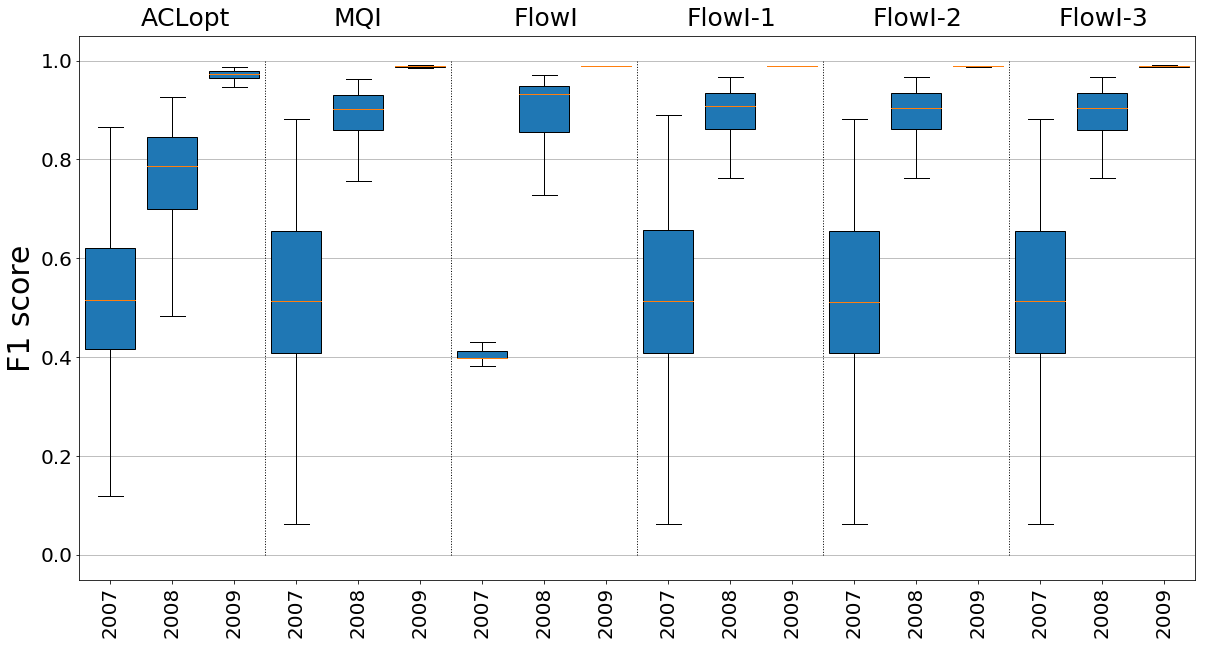

In [16]:
all_data = []
xlabels_ = []
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1score_best_cond_acl[i,j])
    all_data.append(temp_f1)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1_mqi[i,j])
    all_data.append(temp_f1)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1score_acl_flow_flowImprove[i,j])
    all_data.append(temp_f1)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1_acl_flow_localflowImprove_parameter1[i,j])
    all_data.append(temp_f1)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1_acl_flow_localflowImprove_parameter2[i,j])
    all_data.append(temp_f1)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1_acl_flow_localflowImprove_parameter3[i,j])
    all_data.append(temp_f1)
    
    xlabels_.append(int(info_ref_nodes[i,1]))

fig = plt.figure(figsize=(20, 10))
axes = plt.gca()

# notch shape box plot
bplot2 = axes.boxplot(all_data,
                         notch=False,  # notch shape
                         vert=True,   # vertical box aligmnent
                         patch_artist=True,   # fill with color
                         showfliers=False,widths=0.8)

# adding horizontal grid lines
axes.yaxis.grid(True)
axes.set_xticks([y+1 for y in range(len(all_data))])
axes.set_ylabel('F1 score',fontsize=30)
#axes.set_xlabel('Year')

# add x-tick labels
#plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],
#         xticklabels=[info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1]], info_ref_nodes[0][1], info_ref_nodes[0][1])

plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],xticklabels=xlabels_)
axes.set_xticklabels(axes.xaxis.get_majorticklabels(), rotation=90)

axes.tick_params(labelsize=20)

plt.text(1.5, 1.07, 'ACLopt', fontsize=25)
plt.text(4.6, 1.07, 'MQI', fontsize=25)
plt.text(7.5, 1.07, 'FlowI', fontsize=25)
plt.text(10.3, 1.07, 'FlowI-1', fontsize=25)
plt.text(13.3, 1.07, 'FlowI-2', fontsize=25)
plt.text(16.3, 1.07, 'FlowI-3', fontsize=25)

#plt.text(0.75, 0.18, 'Prec.', fontsize=10, rotation=90)
#plt.text(1.8, 0.18, 'Rec.', fontsize=10, rotation=90)

plt.plot([3.5, 3.5], [0, 1], 'k:', linewidth=1)
plt.plot([6.5, 6.5], [0, 1], 'k:', linewidth=1)
plt.plot([9.5, 9.5], [0, 1], 'k:', linewidth=1)
plt.plot([12.5, 12.5], [0, 1], 'k:', linewidth=1)
plt.plot([15.5, 15.5], [0, 1], 'k:', linewidth=1)

plt.savefig('figures/boxplot_Colgate88_f1.png')

plt.show()

## Generate scatter plot for precision

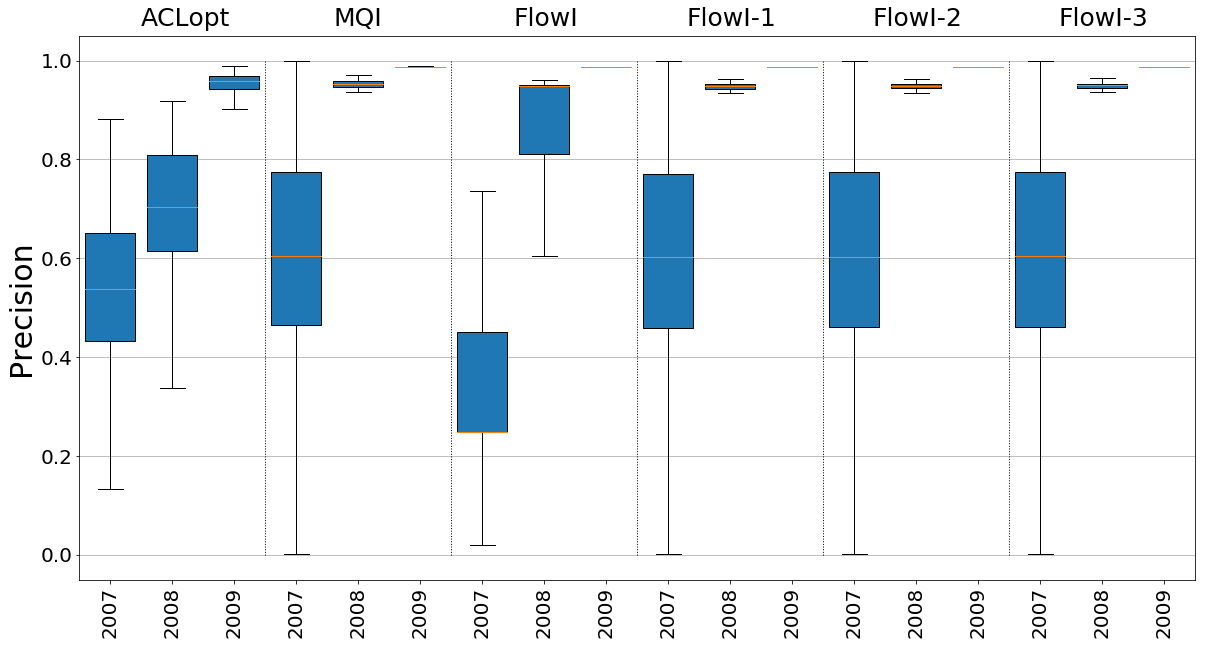

In [17]:
all_data = []
xlabels_ = []
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_best_cond_acl[i,j])
    all_data.append(temp_pre)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_mqi[i,j])
    all_data.append(temp_pre)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove[i,j])
    all_data.append(temp_pre)
    
    xlabels_.append(int(info_ref_nodes[i,1])) 
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter1[i,j])
    all_data.append(temp_pre)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter2[i,j])
    all_data.append(temp_pre)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter3[i,j])
    all_data.append(temp_pre)
    
    xlabels_.append(int(info_ref_nodes[i,1]))

fig = plt.figure(figsize=(20, 10))
axes = plt.gca()

# notch shape box plot
bplot2 = axes.boxplot(all_data,
                         notch=False,  # notch shape
                         vert=True,   # vertical box aligmnent
                         patch_artist=True,   # fill with color
                         showfliers=False,widths=0.8)

# adding horizontal grid lines
axes.yaxis.grid(True)
axes.set_xticks([y+1 for y in range(len(all_data))])
axes.set_ylabel('Precision',fontsize=30)
#axes.set_xlabel('Year')

# add x-tick labels
#plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],
#         xticklabels=[info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1]], info_ref_nodes[0][1], info_ref_nodes[0][1])

plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],xticklabels=xlabels_)
axes.set_xticklabels(axes.xaxis.get_majorticklabels(), rotation=90)

axes.tick_params(labelsize=20)

plt.text(1.5, 1.07, 'ACLopt', fontsize=25)
plt.text(4.6, 1.07, 'MQI', fontsize=25)
plt.text(7.5, 1.07, 'FlowI', fontsize=25)
plt.text(10.3, 1.07, 'FlowI-1', fontsize=25)
plt.text(13.3, 1.07, 'FlowI-2', fontsize=25)
plt.text(16.3, 1.07, 'FlowI-3', fontsize=25)

#plt.text(0.75, 0.18, 'Prec.', fontsize=10, rotation=90)
#plt.text(1.8, 0.18, 'Rec.', fontsize=10, rotation=90)

plt.plot([3.5, 3.5], [0, 1], 'k:', linewidth=1)
plt.plot([6.5, 6.5], [0, 1], 'k:', linewidth=1)
plt.plot([9.5, 9.5], [0, 1], 'k:', linewidth=1)
plt.plot([12.5, 12.5], [0, 1], 'k:', linewidth=1)
plt.plot([15.5, 15.5], [0, 1], 'k:', linewidth=1)

plt.savefig('figures/boxplot_Colgate88_precision.png')

plt.show()

## Generate scatter plot for recall

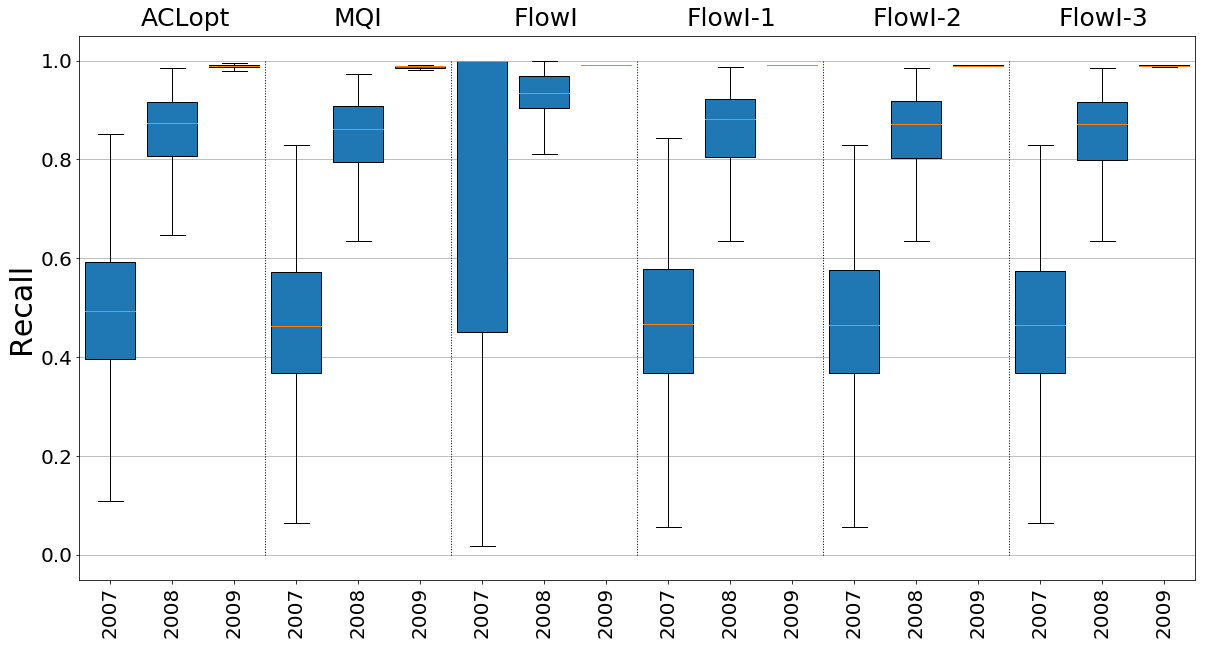

In [18]:
all_data = []
xlabels_ = []

for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_best_cond_acl[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))

for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_mqi[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_acl_flow_localflowImprove[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_acl_flow_localflowImprove_parameter1[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_acl_flow_localflowImprove_parameter2[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_acl_flow_localflowImprove_parameter3[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))

fig = plt.figure(figsize=(20, 10))
axes = plt.gca()

# notch shape box plot
bplot2 = axes.boxplot(all_data,
                         notch=False,  # notch shape
                         vert=True,   # vertical box aligmnent
                         patch_artist=True,   # fill with color
                         showfliers=False,widths=0.8)

# adding horizontal grid lines
axes.yaxis.grid(True)
axes.set_xticks([y+1 for y in range(len(all_data))])
axes.set_ylabel('Recall',fontsize=30)
#axes.set_xlabel('Year')

# add x-tick labels
#plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],
#         xticklabels=[info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1]], info_ref_nodes[0][1], info_ref_nodes[0][1])

plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],xticklabels=xlabels_)
axes.set_xticklabels(axes.xaxis.get_majorticklabels(), rotation=90)

axes.tick_params(labelsize=20)

plt.text(1.5, 1.07, 'ACLopt', fontsize=25)
plt.text(4.6, 1.07, 'MQI', fontsize=25)
plt.text(7.5, 1.07, 'FlowI', fontsize=25)
plt.text(10.3, 1.07, 'FlowI-1', fontsize=25)
plt.text(13.3, 1.07, 'FlowI-2', fontsize=25)
plt.text(16.3, 1.07, 'FlowI-3', fontsize=25)

#plt.text(0.75, 0.18, 'Prec.', fontsize=10, rotation=90)
#plt.text(1.8, 0.18, 'Rec.', fontsize=10, rotation=90)

plt.plot([3.5, 3.5], [0, 1], 'k:', linewidth=1)
plt.plot([6.5, 6.5], [0, 1], 'k:', linewidth=1)
plt.plot([9.5, 9.5], [0, 1], 'k:', linewidth=1)
plt.plot([12.5, 12.5], [0, 1], 'k:', linewidth=1)
plt.plot([15.5, 15.5], [0, 1], 'k:', linewidth=1)

plt.savefig('figures/boxplot_Colgate88_recall.png')

plt.show()

In [19]:
all_data = []
xlabels_ = []

print('Results for ACL')
sum_precision = 0
sum_recall = 0
sum_f1 = 0
sum_conductance = 0
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    temp_conductance = []
    
    for j in nodes[i]:
        temp_pre.append(precision_best_cond_acl[i,j])
        temp_rec.append(recall_best_cond_acl[i,j])
        temp_f1.append(f1score_best_cond_acl[i,j])
        temp_conductance.append(external_best_cond_acl[i,j])

    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1), 'Cond.', stat_.median(temp_conductance))
    sum_precision += stat_.median(temp_pre)
    sum_recall += stat_.median(temp_rec)
    sum_f1 += stat_.median(temp_f1)
    sum_conductance += stat_.median(temp_conductance)
    
avg_precision = sum_precision/l_info_ref_nodes
avg_recall = sum_recall/l_info_ref_nodes
avg_f1 = sum_f1/l_info_ref_nodes
avg_conductance = sum_conductance/l_info_ref_nodes
    
print('Average precision', avg_precision, 'Average recall', avg_recall, 'Average F1', avg_f1, 'Av. Cond.', avg_conductance)
print(" ")
    
print('Results for MQI')
sum_precision = 0
sum_recall = 0
sum_f1 = 0
sum_conductance = 0
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    temp_conductance = []
    
    for j in nodes[i]:
        temp_pre.append(precision_mqi[i,j])
        temp_rec.append(recall_mqi[i,j])
        temp_f1.append(f1_mqi[i,j])
        temp_conductance.append(external_cond_acl_flow_mqi[i,j])
        
    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1), 'Cond.', stat_.median(temp_conductance))
    sum_precision += stat_.median(temp_pre)
    sum_recall += stat_.median(temp_rec)
    sum_f1 += stat_.median(temp_f1)
    sum_conductance += stat_.median(temp_conductance)
    
avg_precision = sum_precision/l_info_ref_nodes
avg_recall = sum_recall/l_info_ref_nodes
avg_f1 = sum_f1/l_info_ref_nodes
avg_conductance = sum_conductance/l_info_ref_nodes
    
print('Average precision', avg_precision, 'Average recall', avg_recall, 'Average F1', avg_f1, 'Av. Cond.', avg_conductance)
print(" ")

print('Results for FlowI')
sum_precision = 0
sum_recall = 0
sum_f1 = 0
sum_conductance = 0
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    temp_conductance = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove[i,j])
        temp_rec.append(recall_acl_flow_localflowImprove[i,j])
        temp_f1.append(f1score_acl_flow_flowImprove[i,j])
        temp_conductance.append(external_cond_acl_flow_flowImprove[i,j])
        
    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1), 'Cond.', stat_.median(temp_conductance))
    sum_precision += stat_.median(temp_pre)
    sum_recall += stat_.median(temp_rec)
    sum_f1 += stat_.median(temp_f1)
    sum_conductance += stat_.median(temp_conductance)
    
avg_precision = sum_precision/l_info_ref_nodes
avg_recall = sum_recall/l_info_ref_nodes
avg_f1 = sum_f1/l_info_ref_nodes
avg_conductance = sum_conductance/l_info_ref_nodes
    
print('Average precision', avg_precision, 'Average recall', avg_recall, 'Average F1', avg_f1, 'Av. Cond.', avg_conductance)
print(" ")

print('Results for FlowI-1')
sum_precision = 0
sum_recall = 0
sum_f1 = 0
sum_conductance = 0
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    temp_conductance = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter1[i,j])
        temp_rec.append(recall_acl_flow_localflowImprove_parameter1[i,j])
        temp_f1.append(f1_acl_flow_localflowImprove_parameter1[i,j])
        temp_conductance.append(external_cond_acl_flow_localflowImprove_parameter1[i,j])

    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1), 'Cond.', stat_.median(temp_conductance))
    sum_precision += stat_.median(temp_pre)
    sum_recall += stat_.median(temp_rec)
    sum_f1 += stat_.median(temp_f1)
    sum_conductance += stat_.median(temp_conductance)
    
avg_precision = sum_precision/l_info_ref_nodes
avg_recall = sum_recall/l_info_ref_nodes
avg_f1 = sum_f1/l_info_ref_nodes
avg_conductance = sum_conductance/l_info_ref_nodes
    
print('Average precision', avg_precision, 'Average recall', avg_recall, 'Average F1', avg_f1, 'Av. Cond.', avg_conductance)
print(" ")

print('Results for FlowI-2')
sum_precision = 0
sum_recall = 0
sum_f1 = 0
sum_conductance = 0
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    temp_conductance = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter2[i,j])
        temp_rec.append(recall_acl_flow_localflowImprove_parameter2[i,j])
        temp_f1.append(f1_acl_flow_localflowImprove_parameter2[i,j])
        temp_conductance.append(external_cond_acl_flow_localflowImprove_parameter2[i,j])
        
    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1), 'Cond.', stat_.median(temp_conductance))
    sum_precision += stat_.median(temp_pre)
    sum_recall += stat_.median(temp_rec)
    sum_f1 += stat_.median(temp_f1)
    sum_conductance += stat_.median(temp_conductance)
    
avg_precision = sum_precision/l_info_ref_nodes
avg_recall = sum_recall/l_info_ref_nodes
avg_f1 = sum_f1/l_info_ref_nodes
avg_conductance = sum_conductance/l_info_ref_nodes
    
print('Average precision', avg_precision, 'Average recall', avg_recall, 'Average F1', avg_f1, 'Av. Cond.', avg_conductance)
print(" ")

print('Results for FlowI-3')
sum_precision = 0
sum_recall = 0
sum_f1 = 0
sum_conductance = 0
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    temp_conductance = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter3[i,j])
        temp_rec.append(recall_acl_flow_localflowImprove_parameter3[i,j])
        temp_f1.append(f1_acl_flow_localflowImprove_parameter3[i,j])
        temp_conductance.append(external_cond_acl_flow_localflowImprove_parameter3[i,j])
        
    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1), 'Cond.', stat_.median(temp_conductance))
    sum_precision += stat_.median(temp_pre)
    sum_recall += stat_.median(temp_rec)
    sum_f1 += stat_.median(temp_f1)
    sum_conductance += stat_.median(temp_conductance)
    
avg_precision = sum_precision/l_info_ref_nodes
avg_recall = sum_recall/l_info_ref_nodes
avg_f1 = sum_f1/l_info_ref_nodes
avg_conductance = sum_conductance/l_info_ref_nodes
    
print('Average precision', avg_precision, 'Average recall', avg_recall, 'Average F1', avg_f1, 'Av. Cond.', avg_conductance)
print(" ")

Results for ACL
Feature: 2007 Precision 0.5370673102553303 Recall 0.49415773387344436 F1 0.5154481149823301 Cond. 0.4956311613318852
Feature: 2008 Precision 0.7034025411323834 Recall 0.8743452562110557 F1 0.7867857614949116 Cond. 0.359121590269578
Feature: 2009 Precision 0.9588969680340239 Recall 0.9897085017953575 F1 0.9731856155909868 Cond. 0.12171916917885886
Average precision 0.7331222731405792 Average recall 0.7860704972932858 Average F1 0.7584731640227428 Av. Cond. 0.3254906402601074
 
Results for MQI
Feature: 2007 Precision 0.6046509097076298 Recall 0.46249689241163483 F1 0.5128407191347857 Cond. 0.47552498392385867
Feature: 2008 Precision 0.9521814232095318 Recall 0.8623155905108203 F1 0.9012613825913112 Cond. 0.3071534402185044
Feature: 2009 Precision 0.9876763051527743 Recall 0.9893692216347649 F1 0.9884648509749107 Cond. 0.10846433913804296
Average precision 0.848169546023312 Average recall 0.7713939015190734 Average F1 0.8008556509003358 Av. Cond. 0.29704758776013535
 
Resu

There are  1  connected components in the graph
Make an NCP object for Improve Algo
There are  1  connected components in the graph
Going into improve mode


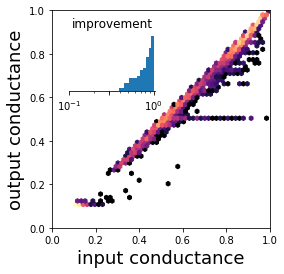

In [6]:
# Read graph. This also supports gml and graphml format.
g.discard_weights()

ncp = lgc.NCPData(g,store_output_clusters=True)
ncp.approxPageRank(ratio=0.8,nthreads=24,localmins=False,neighborhoods=False,random_neighborhoods=False)
sets = [st["output_cluster"] for st in ncp.results]
print("Make an NCP object for Improve Algo")
ncp2 = lgc.NCPData(g)
print("Going into improve mode")
output = ncp2.refine(sets, method='mqi', methodname='MQI', nthreads=24, timeout=1000000, **{"delta": 0})
fig = lgc.NCPPlots(ncp2).mqi_input_output_cond_plot()[0]
#fig.axes[0].set_title(gname + " " + methodname+"-NCP")
fig.savefig("figures/" + 'mqi' + "-ncp-"+'Colgate88'+".pdf", bbox_inches="tight", figsize=(100,100))
plt.show()

Make an NCP object for Improve Algo
There are  1  connected components in the graph
Going into improve mode


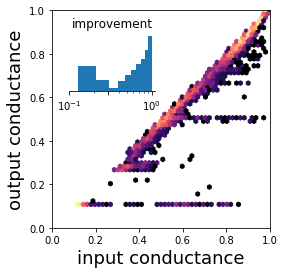

In [7]:
print("Make an NCP object for Improve Algo")
ncp2 = lgc.NCPData(g)
print("Going into improve mode")
output = ncp2.refine(sets, method='sl', methodname='FlowImprove', nthreads=24, timeout=1000000, **{"delta": 0.00001})
fig = lgc.NCPPlots(ncp2).mqi_input_output_cond_plot()[0]
#fig.axes[0].set_title(gname + " " + methodname+"-NCP")
fig.savefig("figures/" + 'FlowImprove' + "-ncp-"+'Colgate88'+".pdf", bbox_inches="tight", figsize=(100,100))
plt.show()

Make an NCP object for Improve Algo
There are  1  connected components in the graph
Going into improve mode


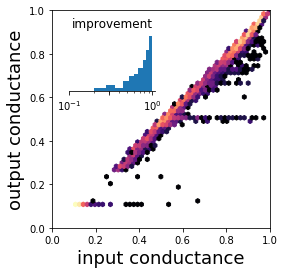

In [8]:
print("Make an NCP object for Improve Algo")
ncp2 = lgc.NCPData(g)
print("Going into improve mode")
output = ncp2.refine(sets, method='sl', methodname='SimpleLocal', nthreads=24, timeout=1000000, **{"delta": 0.3})
fig = lgc.NCPPlots(ncp2).mqi_input_output_cond_plot()[0]
#fig.axes[0].set_title(gname + " " + methodname+"-NCP")
fig.savefig("figures/" + 'SimpleLocal_0_3' + "-ncp-"+'Colgate88'+".pdf", bbox_inches="tight", figsize=(100,100))
plt.show()

Make an NCP object for Improve Algo
There are  1  connected components in the graph
Going into improve mode


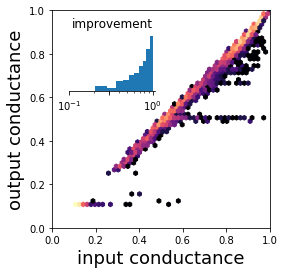

In [9]:
print("Make an NCP object for Improve Algo")
ncp2 = lgc.NCPData(g)
print("Going into improve mode")
output = ncp2.refine(sets, method='sl', methodname='SimpleLocal', nthreads=24, timeout=1000000, **{"delta": 0.6})
fig = lgc.NCPPlots(ncp2).mqi_input_output_cond_plot()[0]
#fig.axes[0].set_title(gname + " " + methodname+"-NCP")
fig.savefig("figures/" + 'SimpleLocal_0_6' + "-ncp-"+'Colgate88'+".pdf", bbox_inches="tight", figsize=(100,100))
plt.show()

Make an NCP object for Improve Algo
There are  1  connected components in the graph
Going into improve mode


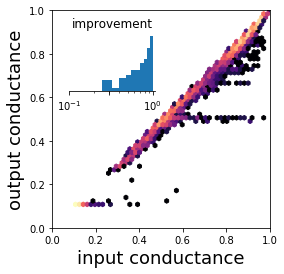

In [10]:
print("Make an NCP object for Improve Algo")
ncp2 = lgc.NCPData(g)
print("Going into improve mode")
output = ncp2.refine(sets, method='sl', methodname='SimpleLocal', nthreads=24, timeout=1000000, **{"delta": 0.9})
fig = lgc.NCPPlots(ncp2).mqi_input_output_cond_plot()[0]
#fig.axes[0].set_title(gname + " " + methodname+"-NCP")
fig.savefig("figures/" + 'SimpleLocal_0_9' + "-ncp-"+'Colgate88'+".pdf", bbox_inches="tight", figsize=(100,100))
plt.show()